In [1]:
from os.path import join
import os
import pandas as pd
pd.set_option("display.max_colwidth", None)
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
#plt.style.use("apa.mplstyle") #custom matplotlib style

In [2]:
folder_path = "/data/NewsGuard/full-metadata/"
figures_path = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
tables_path = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

In [3]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    sns.despine(ax=ax)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

# Dataset construction

In [4]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith(".csv")] 

df_total = pd.DataFrame()
for csv in csv_files: #taking all files in the folder
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    # taking name of file, removing the extension and "metadata-"
    df["file_date"]=csv.split(".")[0].split("-")[1]
    # converting file_date to datetime, with format YYYYMMDD00
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_total = pd.concat([df_total, df], axis=0)

In [5]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("1501.csv")] 
df_15 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_15 = pd.concat([df_15, df], axis=0)

In [6]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("0201.csv")] 
df_02 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_02 = pd.concat([df_02, df], axis=0)

In [7]:
df_recent = df_15[df_15["file_date"] == df_15["file_date"].max()]
df_first = df_15[df_15["file_date"] == df_15["file_date"].min()]

print(f'In the most recent file, there are {len(df_recent)} entries, '
      f'with {df_recent["UUID"].nunique()} rating IDs '
      f'and {df_recent["Domain"].nunique()} domains.')

print(f'In the first file, there are {len(df_first)} entries, '
      f'with {df_first["UUID"].nunique()} IDs '
      f'and {df_first["Domain"].nunique()} domains.')

In the most recent file, there are 12097 entries, with 6971 rating IDs and 10683 domains.
In the first file, there are 2647 entries, with 2647 IDs and 2641 domains.


In [8]:
rating_counts = df_recent.Rating\
    .value_counts(normalize=False)\
    .reset_index()\
    .rename(columns={"count":"Count"})

rating_countsp = df_recent.Rating\
    .value_counts(normalize=True)\
    .reset_index()\
    .rename(columns={"proportion":"Percent"})

ratings = pd.merge(rating_counts, rating_countsp, 
                   on="Rating")

rating_mean = df_recent\
    .groupby("Rating").Score\
    .mean()\
    .reset_index()\
    .rename(columns={"Score":"Mean"})

pd.merge(ratings, rating_mean, on="Rating")

Rating  Count   Percent       Mean
0      T   6795  0.561710  87.290581
1      N   4438  0.366868  25.673727
2     FL    731  0.060428        NaN
3      P     70  0.005787        NaN
4      S     63  0.005208        NaN

In [9]:
#for rating in df_recent.Rating.unique():
#    print(rating, df_recent[df_recent.Rating == rating].Domain.unique()[:3])

In [10]:
p_rating = df_recent[df_recent["Rating"] == "FL"]
if not p_rating["Score"].isnull().all():
    mean_score = p_rating["Score"].mean(skipna=True)
    print(f"Mean score for rating FL: {mean_score}")
else:
    print(f"No scores available for rating FL.")

No scores available for rating FL.


In [11]:
print(f'Number of rows without Score: {df_recent.Score.isna().sum()}')
print(f'Percentage: {round(df_recent.Score.isna().sum()/len(df_recent)*100,2)}%')

Number of rows without Score: 864
Percentage: 7.14%


In [12]:
print(f'Number of rows with Score: {len(df_recent)}')
print(f'Number of rows with Score: {len(df_recent) - df_recent.Score.isna().sum()}')

Number of rows with Score: 12097
Number of rows with Score: 11233


## How volatile are trustworthiness ratings?

### Coverage

In [13]:
print(f'In the most recent df, there are {len(df_recent)} entries, '
      f'while there are {len(df_first)} in the first version.')
print(f'In the most recent df, there are {len(df_recent[df_recent["Score"].notnull()])} '
      f'rated domains while there are {len(df_first[df_first["Score"].notnull()])} '
      'in the first version of the database.')
print(f'The domains belong to {df_recent["Parent Domain"].nunique()} parent domains.')
print(f'The number of entries has grown by {round((len(df_recent)/len(df_first)-1)*100,2)}%')

In the most recent df, there are 12097 entries, while there are 2647 in the first version.
In the most recent df, there are 11233 rated domains while there are 2615 in the first version of the database.
The domains belong to 436 parent domains.
The number of entries has grown by 357.01%


In [14]:
df_recent["Parent Domain"]\
    .notnull()\
    .value_counts()

Parent Domain
False    6443
True     5654
Name: count, dtype: int64

In [15]:
df_recent_p = df_recent[df_recent["Parent Domain"]\
                        .notnull()]\
                        .sort_values("Parent Domain")

df_recent_p.groupby("Parent Domain")\
    .Score\
    .nunique()\
    .value_counts()

Score
1    423
0     13
Name: count, dtype: int64

In [16]:
parent_domains_std = df_recent_p\
    .groupby("Parent Domain")\
    .Score.std()\
        .reset_index()\
        .rename(columns={"Score":"std"})

def filter_different_scores(df):
    #filter based on standard deviation
    score_std = df["Score"].std()
    if score_std != 0:
        return True
    else:
        return False

grouped = df_recent_p.groupby("Parent Domain")
different_scores_rows = grouped.filter(filter_different_scores)

different_scores_rows\
    .Rating\
        .value_counts()

Rating
FL    40
P     32
S      6
Name: count, dtype: int64

In [17]:
#counting number of ratings for sampling mid-month
counts_15 = df_15.groupby(df_15.file_date)\
    .size()\
    .reset_index(name="Counts")

#counting number of ratings for sampling beginning of month
counts_02 = df_02.groupby(df_02.file_date)\
    .size()\
    .reset_index(name="Counts")

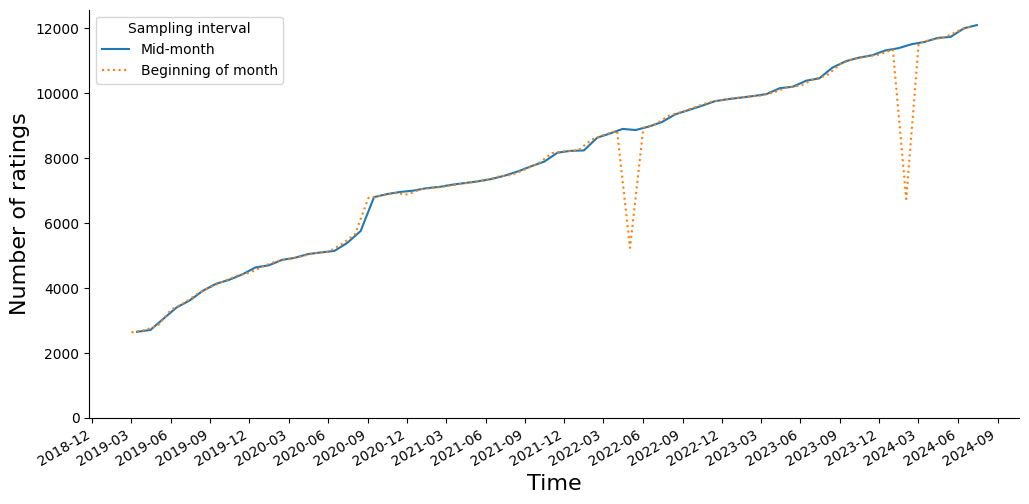

In [18]:
plt.figure(figsize=(12,6))
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Mid-month"
             )

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Beginning of month", 
             linestyle="dotted")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()

plt.ylim(0)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(title="Sampling interval")
custom_plots()

plt.show()

### Added and removed sources

In [19]:
domain_changes = {}
#getting list of unique months to iterate through
unique_months = df_15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)): #iterate through months
    current_month = unique_months[i] #set as current months
    previous_month = unique_months[i - 1] #set month minus one as previous month
    
    #compare domains from current month to previous month
    added_month = set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month


data = []
for date, (added, removed) in domain_changes.items():
    data.append({"Date": date, 
                 "Added": len(added), 
                 "Removed": len(removed)})

domain_changes_df = pd.DataFrame(data)

In [20]:
print(f'Total number of added sources: {domain_changes_df["Added"].sum()}')
print(f'Total number of removed sources: {domain_changes_df["Removed"].sum()}')

Total number of added sources: 8713
Total number of removed sources: 671


In [21]:
print(f'Average number of added sources per month: {domain_changes_df["Added"].mean()}')
print(f'Average number of removed sources per month: {domain_changes_df["Removed"].mean()}')

Average number of added sources per month: 138.3015873015873
Average number of removed sources per month: 10.65079365079365


### Duplicates

In [22]:
#extracting duplicated domains
dup_domains = \
    df_recent[df_recent\
                .duplicated(subset="Domain", 
                            keep=False)]

#looking at only relevant columns
#dup_domains[["Domain", "Country", "Language", "Score"]]\
#    .head(10)

In [23]:
#counting if the score is the same for domains
#dup_domains \
#    .groupby("Domain").Score \
#    .nunique() \
#    .reset_index(name="nunique") \
#    .sort_values(by="nunique", 
#                 ascending=False)

In [24]:
#dup_domains[dup_domains["Domain"] == "2020news.de"]

In [25]:
#dup_domains[dup_domains["Domain"] == "msn.com"]

## Trustworthiness distribution

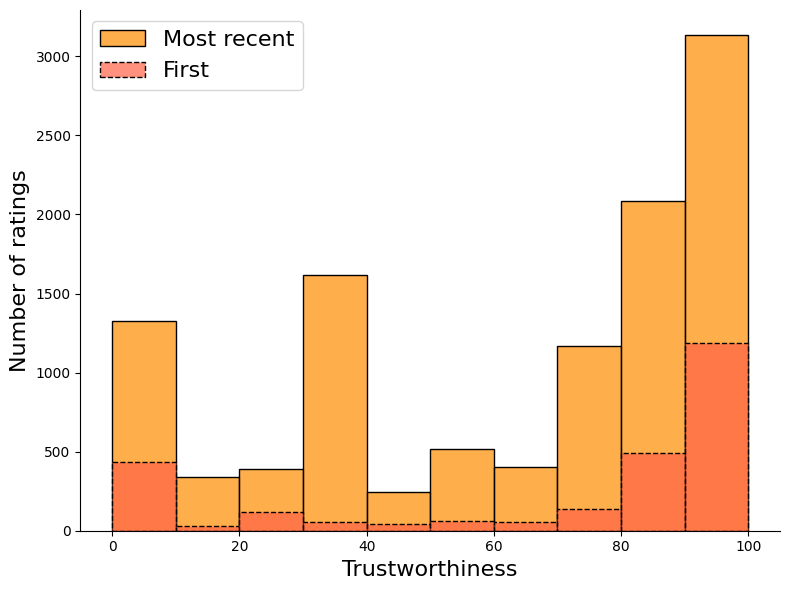

In [26]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.7,
             color="darkorange",
             edgecolor="black",
             label="Most recent")

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",  
             alpha=0.7,
             color="tomato",
             linestyle="dashed",
             label="First")

plt.xlabel("Trustworthiness", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
custom_plots()

plt.show()

In [27]:
df_15["file_year"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("Y")
df_15["file_month"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("M")

year_scores = df_15\
    .groupby("file_year")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.532554  32.412332  0.0  100.0
5      2024  63.836077  32.546907  0.0  100.0


In [28]:
month_scores = df_15\
    .groupby("file_month")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()

#print first and last entry
print(month_scores.head(1))
print(month_scores.tail(1))

  file_month       mean        std  min    max
0    2019-03  70.786424  35.328616  0.0  100.0
   file_month      mean       std  min    max
63    2024-07  62.94663  32.93547  0.0  100.0


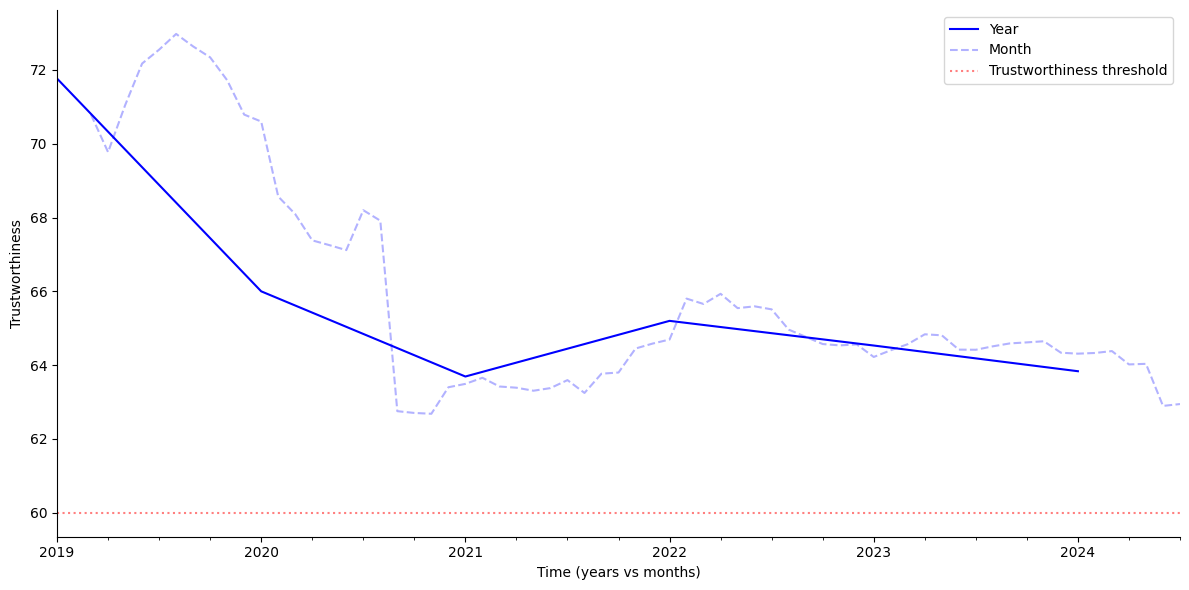

In [29]:
plt.figure(figsize=(12,6))

df_15.groupby(df_15.file_year).Score\
    .mean()\
    .plot(color="blue", label="Year")

df_15.groupby(df_15.file_month).Score\
    .mean()\
    .plot(color="blue", label="Month",
            alpha=0.3, linestyle="--")
plt.xlabel("Time (years vs months)")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, 
            color= "red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.legend()
custom_plots()
plt.tight_layout()

plt.show()

/tmp/ipykernel_4191584/1883049141.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


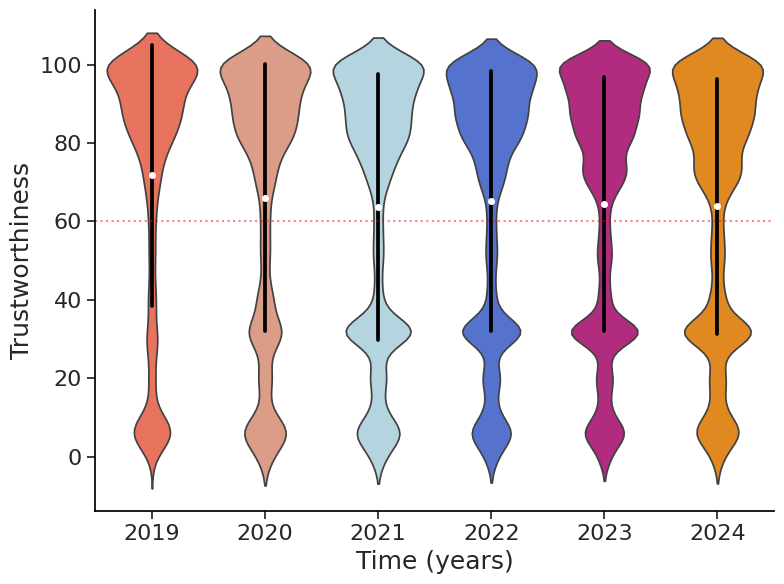

In [30]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

df_15_year = df_15.groupby("file_year")\
    .apply(lambda x: x\
           .drop_duplicates())\
            .reset_index(drop=True)

year_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred", "darkorange"]

sns.pointplot(
    data=df_15_year, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    markersize=2,
    linestyle='none') 

sns.pointplot(
    data=year_scores, 
    y="mean", 
    x="file_year", 
    estimator="mean",
    color="white", 
    linestyle='none',  
    markers="o",
    markersize=3) 

sns.violinplot(x="file_year", 
               y="Score",
               hue="file_year",
               density_norm="count",
               data=df_15_year,
               inner=None,
               palette=year_colors
               )


plt.axhline(y=60, color="red", 
            linestyle="dotted",
            alpha=0.5, 
            label="Trustworthiness threshold")

plt.xlabel("Time (years)", fontsize=18)
plt.ylabel("Trustworthiness", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
custom_plots()

plt.savefig(join(figures_path, 
                 "score_per_year-violinplot.png"), 
                 dpi=300)

plt.savefig(join(figures_path, 
                 "score_per_year-violinplot.pdf"), 
                 dpi=300)

plt.show()

### By added vs. removed sources

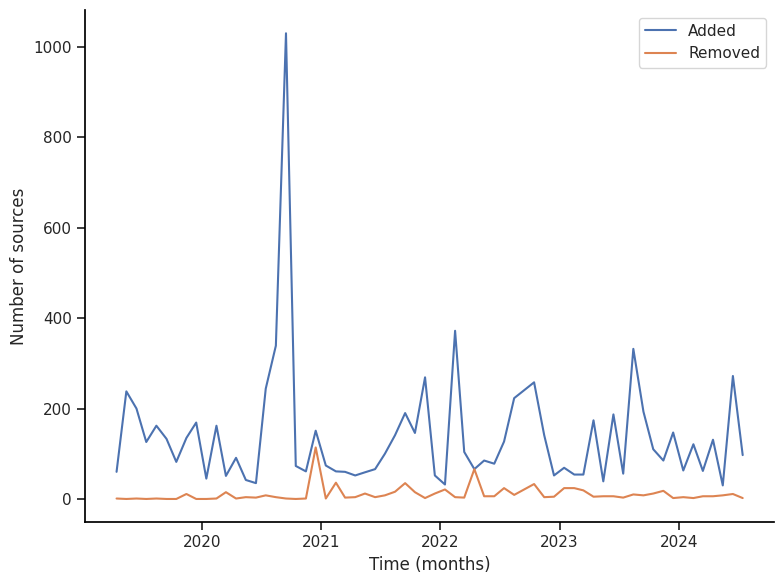

In [31]:
domain_changes_df_long = \
    domain_changes_df\
        .melt(id_vars="Date",
              value_vars=["Added", "Removed"],
              var_name="Change",
              value_name="Count")

plt.figure(figsize=(8, 6))
sns.lineplot(data=domain_changes_df_long,
             x="Date",
             y="Count",
             hue="Change")

plt.xlabel("Time (months)")
plt.ylabel("Number of sources") 

plt.legend()
custom_plots()
plt.tight_layout()
plt.show()

In [32]:
added_means = []
removed_means = []
added_sds = []
removed_sds = []
months = []

for date in domain_changes.keys():
    added_sources = df_15[df_15.Domain.isin(domain_changes[date][0])]
    removed_sources = df_15[df_15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_sd = added_sources["Score"].std()
    removed_sd = removed_sources["Score"].std()

    added_means.append(added_mean)
    removed_means.append(removed_mean)
    added_sds.append(added_sd)
    removed_sds.append(removed_sd)
    months.append(date)

added_df = pd.DataFrame({
    "Date": months,
    "Added_Mean": added_means,
    "Added_SD": added_sds})

removed_df = pd.DataFrame({
    "Date": months,
    "Removed_Mean": removed_means,
    "Removed_SD": removed_sds})

added_df["Change"] = "Added"
added_df = added_df\
            .rename(
                columns={
                    "Added_Mean": "Mean", 
                    "Added_SD": "SD"})

removed_df["Change"] = "Removed"
removed_df = removed_df\
            .rename(
                columns={
                    "Removed_Mean": "Mean", 
                    "Removed_SD": "SD"})

averages_df = pd.concat([added_df, removed_df])

domain_changes_df_long = \
    domain_changes_df_long\
        .merge(averages_df, 
               on=["Date", "Change"])

domain_changes_df_long[domain_changes_df_long["Change"] == "Added"]\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(3)

Date Change  Count       Mean         SD
17 2020-09-15 01:00:00  Added   1030  35.319316  14.203259
34 2022-02-15 01:00:00  Added    372  88.278136  15.641526
16 2020-08-15 01:00:00  Added    339  60.616460  35.688466

In [33]:
print(f'Added sources: '
        f'Mean={round(added_df["Mean"].mean(), 2)}, '
        f'SD={round(added_df["SD"].mean(), 2)}')
print(f'Removed sources: '
        f'Mean={round(removed_df["Mean"].mean(), 2)}, '
        f'SD={round(removed_df["SD"].mean(), 2)}')

Added sources: Mean=59.87, SD=27.5
Removed sources: Mean=53.63, SD=18.86


In [34]:
date_means = df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"file_date": "Date"})


domain_changes_df = date_means\
    .merge(domain_changes_df, 
           on="Date")

#calculate difference in subsequent dates in score
domain_changes_df = domain_changes_df.sort_values("Date")
domain_changes_df["Score_diff"] = domain_changes_df["Score"].diff()

top_changes = \
    domain_changes_df.reindex(domain_changes_df["Score_diff"]\
                              .abs()\
                                .sort_values(ascending=False)\
                                    .index)\
                                    .head(5)
top_changes

Date      Score  Added  Removed  Score_diff
17 2020-09-15 01:00:00  62.753501   1030        1   -5.162048
10 2020-02-15 01:00:00  68.570712    162        1   -2.031907
1  2019-05-15 01:00:00  71.042249    238        0    1.268653
61 2024-06-15 01:00:00  62.895994    272       11   -1.140367
2  2019-06-15 01:00:00  72.173881    200        1    1.131632

### By country

In [35]:
list(domain_changes.keys())[17]

Timestamp('2020-09-15 01:00:00')

In [36]:
#extract list of domains added
added_20200915 = \
    domain_changes[list(domain_changes.keys())[17]][0]

df_2015 = \
    df_15[df_15["file_date"] == list(
        domain_changes.keys())[17]]

df_2015_added = \
    df_2015[df_2015["Domain"]\
            .isin(added_20200915)][["Domain", "Country"]]

df_2015_added.Country.value_counts()

Country
US     1015
ALL      15
IT        6
DE        5
FR        4
Name: count, dtype: int64

In [37]:
country_count = df_15\
    .groupby("file_date")\
        .agg(
            Count=("Country", 
                   "nunique"),
            Score=("Score", 
                   "mean"),
            SD=("Score", 
                "std"),
            Countries=("Country", lambda x: ", ".join(sorted(x.unique())))
            )\
    .reset_index()

In [38]:
#remove something from strings
country_count["Added_Countries"] = country_count["Countries"]\
    .str.replace("ALL, GB, IT, US", "ALL, IT")\
    .str.replace("ALL, DE, FR, GB, IT, US", "DE, FR")\
    .str.replace("ALL, CA, DE, FR, GB, IT, US", "CA")\
    .str.replace("ALL, AU, CA, DE, FR, GB, IT, US", "AU")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, US", "AT")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, NZ, US", "NZ")

In [39]:
#from df_15, calculate the number of rows per country per file_date
country_size = df_15\
    .groupby(["file_date", "Country"])\
        .size()\
    .reset_index(name="Size")

#keep only the first ones
added_countries_size = country_size\
    .drop_duplicates(subset="Country", 
                     keep="first")

#per date, calculate sum of Size
added_countries_size = added_countries_size\
    .groupby("file_date")\
        .Size\
        .sum()\
        .reset_index(name="Added_Countries_Size")

In [40]:
#keep only dates with changes
country_change = \
    country_count[country_count["Count"].diff() != 0]

country_change = country_count\
    .merge(added_countries_size, 
           on="file_date")

In [41]:
#extract file_date and countries as dictionary
country_change_dict = country_change\
    .set_index("file_date")\
    .to_dict()["Added_Countries"]

#remove ALL
country_change_dict = {k: v.replace("ALL, ", "") for k, v in country_change_dict.items()}
country_change_dict

{Timestamp('2019-03-15 01:00:00'): 'GB, US',
 Timestamp('2019-05-15 01:00:00'): 'IT',
 Timestamp('2019-06-15 01:00:00'): 'DE, FR',
 Timestamp('2021-10-15 01:00:00'): 'CA',
 Timestamp('2022-07-15 01:00:00'): 'AU',
 Timestamp('2022-10-15 01:00:00'): 'AT',
 Timestamp('2023-01-15 01:00:00'): 'NZ'}

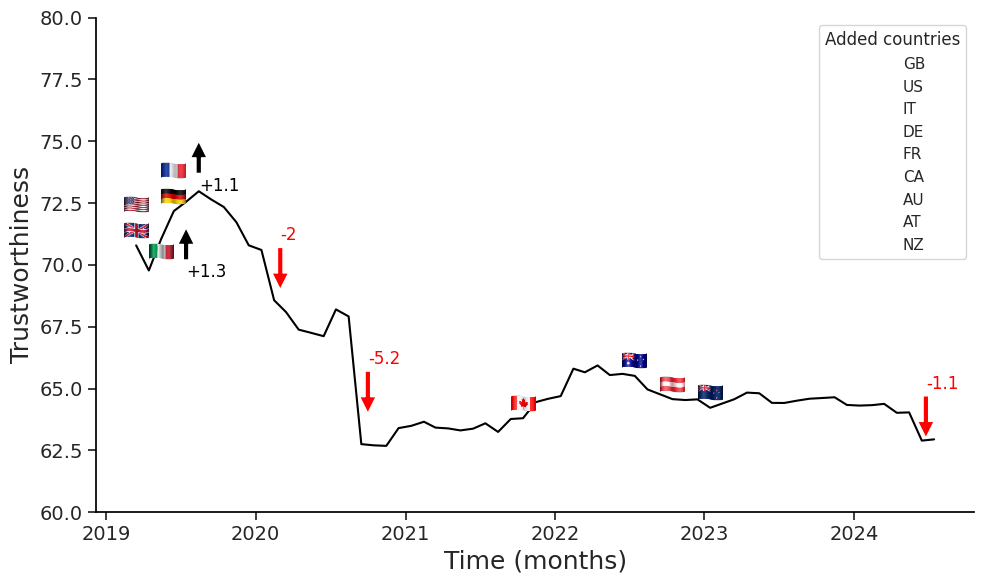

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=country_count, 
             x="file_date", 
             y="Score", 
             color="black",
             ax=ax)

#add emoji flags
y_positions = {}
for date, countries in country_change_dict.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"

        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue

        flag = plt.imread(flag_path)
        country_x = pd.to_datetime(date)
        country_score = country_count.loc[
            country_count["file_date"] == date, 
                "Score"].iloc[0]

        if country == "IT":
            y_position = country_score + idx - 0.5
        else:
            if date in y_positions:
                y_position = country_score + idx + 0.65
            else:
                y_position = country_score + idx + 0.6
        
        imagebox = OffsetImage(flag, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (country_x, y_position), 
                            frameon=False)
        ax.add_artist(ab)
        
        if date not in y_positions:
            y_positions[date] = [y_position]
        else:
            y_positions[date].append(y_position)

#add legend with flag emojis
legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax.plot([], [], 
                                       linestyle="none", 
                                       label=c)[0])

#only text
ax.annotate("-5.2",
            xy=(pd.to_datetime("2020-10-01"), 64), 
            xytext=(pd.to_datetime("2020-10-01"), 66),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("-2", 
            xy=(pd.to_datetime("2020-03-01"), 69), 
            xytext=(pd.to_datetime("2020-03-01"), 71),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("-1.1", 
            xy=(pd.to_datetime("2024-06-25"), 63), 
            xytext=(pd.to_datetime("2024-06-25"), 65),
            arrowprops=dict(facecolor="red"),
            color="red", #alpha=0.6,
            fontsize=12)

ax.annotate("+1.3", 
            xy=(pd.to_datetime("2019-07-15"),71.5), 
            xytext=(pd.to_datetime("2019-07-15"), 69.5),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=12)


ax.annotate("+1.1", 
            xy=(pd.to_datetime("2019-08-15"), 75), 
            xytext=(pd.to_datetime("2019-08-15"), 73),
            arrowprops=dict(facecolor="black"),
            color="black", 
            fontsize=12)


ax.legend(handles=legend_elements, 
          title="Added countries",
          loc="upper right",
          )
#dotted legend frame
#ax.get_legend().get_frame().set_linestyle(":")
#ax.get_legend().get_frame().set_edgecolor("black")

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(60,80)
ax.set_xlabel("Time (months)", fontsize=18)
ax.set_ylabel("Trustworthiness", fontsize=18)
custom_plots(ax=ax)
plt.tight_layout()


plt.show()

### Updates

In [43]:
df_15["Last Updated"]=pd.to_datetime(df_15["Last Updated"],unit="ms")
df_15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [44]:
#inspect the duplicates
df_dups = \
    df_recent[df_recent\
              .duplicated(
                  subset="UUID",
                  keep=False)]

#df_dups[["UUID", "Domain", 
#            "Parent Domain", "Country", 
#            "Language", "Score"]]\
#            .sort_values(by="UUID")\
#            .head(5)

In [45]:
df_15_UUID = \
    df_15.drop_duplicates(
        subset=["UUID", "Domain"], 
        keep="first")

print(f'Without UUID length = {len(df_15)}, '
      f'with UUID = {len(df_15_UUID)}.')

Without UUID length = 503871, with UUID = 58178.


In [46]:
#df_dups[df_dups.duplicated(keep=False)] #only 2 are identical

In [47]:
df_15_sorted = \
    df_15.groupby(["Domain", "Country", "Language"],
                    group_keys=False)\
            .apply(lambda x: x\
            .sort_values("file_date",
                            ascending=True))\
            .reset_index(drop=True)

df_15_updates = \
    df_15_sorted[[
        "Domain", "Parent Domain", "Country", 
        "Language", "file_date", "Last Updated", 
        "Score", 
        "Does not repeatedly publish false content",
        "Does not repeatedly publish false or egregiously misleading content",
        "Gathers and presents information responsibly",
        "Regularly corrects or clarifies errors",
        "Has effective practices for correcting errors",
        "Handles the difference between news and opinion responsibly",
        "Avoids deceptive headlines",
        "Website discloses ownership and financing",
        "Clearly labels advertising",
        "Reveals who's in charge, including any possible conflicts of interest",
        "The site provides names of content creators, along with either contact or biographical information"]]

/tmp/ipykernel_4191584/2219613241.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


In [48]:
#size of each date
updates_summary = df_15_updates\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_All")

#add means 
updates_means = df_15_updates \
    .groupby("file_date")["Score"]\
        .mean()\
    .reset_index(name="Mean_All")

#merge
updates_summary = updates_summary\
    .merge(updates_means, 
           on="file_date")   

updates_summary.head(3)

file_date  Count_All   Mean_All
0 2019-03-15 01:00:00       2647  70.786424
1 2019-04-15 01:00:00       2704  69.773596
2 2019-05-15 01:00:00       3047  71.042249

In [49]:
#differences in updated and score
df_15_updates["Score_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Score"].diff()

df_15_updates["Updated_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Last Updated"].diff()

#df_15_updates.head(10)

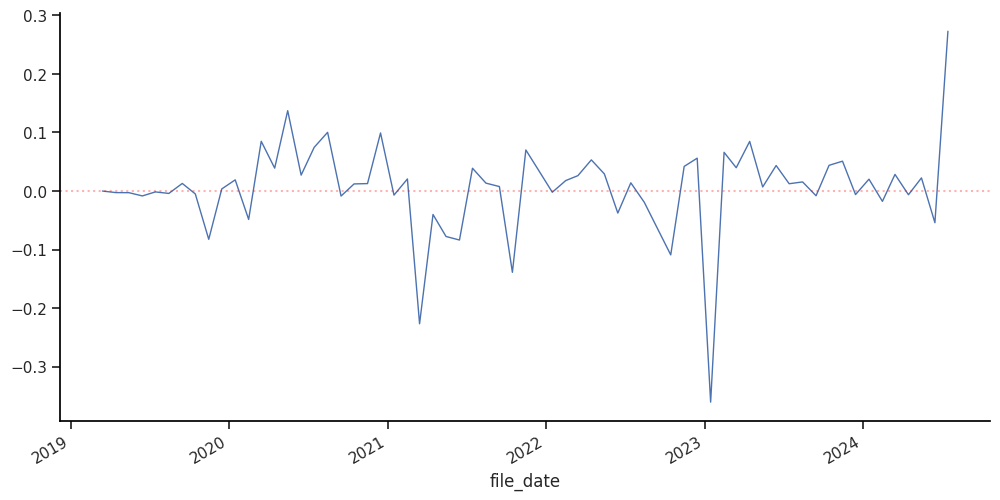

In [50]:
#when were the biggest changes?
plt.figure(figsize=(12, 6))
df_15_updates\
    .groupby(df_15_updates["file_date"])["Score_diff"]\
    .mean()\
    .plot(linewidth=1)
plt.axhline(0, color="red", linestyle=":", alpha=0.3)
custom_plots()

In [51]:
#filter out the ones that have never been updated
df_15_updates["Added"] = \
    df_15_updates\
        .apply(lambda row: pd.isna(row["Updated_diff"]), axis=1) #where there is no prior date to compare to

In [52]:
#Updated == True when time_diff is not 0 or not NaN
df_15_updates["Updated"] = \
    df_15_updates\
        .apply(lambda row: 
               not pd.isna(row["Updated_diff"]) and #added
               row["Updated_diff"] != pd.Timedelta(0), axis=1) #actual time difference

#df_15_updates.head(5)

In [53]:
added_df_15 = df_15_updates[df_15_updates["Added"] == True] #only the freshly added ones 

added_counts = added_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Added")

added_means = added_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Added"})

added_sd = added_df_15\
    .groupby("file_date")["Score"]\
    .std()\
    .reset_index()\
    .rename(columns={"Score": "Std_Added"})

updates_summary = \
    updates_summary\
        .merge(added_counts, 
               on="file_date", 
               how="left")\
        .merge(added_means, 
               on="file_date", 
               how="left")\
        .merge(added_sd,
                on="file_date",
                how="left")

updates_summary.head(20)

file_date  Count_All   Mean_All  Count_Added  Mean_Added  \
0  2019-03-15 01:00:00       2647  70.786424         2645   70.800421   
1  2019-04-15 01:00:00       2704  69.773596           61   25.144068   
2  2019-05-15 01:00:00       3047  71.042249          334   81.140673   
3  2019-06-15 01:00:00       3399  72.173881          365   82.238095   
4  2019-07-15 01:00:00       3611  72.550352          212   78.726829   
5  2019-08-15 01:00:00       3914  72.976265          304   77.943522   
6  2019-09-15 01:00:00       4129  72.637761          215   66.185714   
7  2019-10-15 01:00:00       4249  72.341583          120   62.222222   
8  2019-11-15 01:00:00       4420  71.721048          182   60.146409   
9  2019-12-15 01:00:00       4631  70.790524          211   51.152174   
10 2020-01-15 01:00:00       4697  70.602620           67   55.081967   
11 2020-02-15 01:00:00       4865  68.570712          169   14.547337   
12 2020-03-15 01:00:00       4926  68.093189           76   33.794521   
13 2020-04-15 01:00:00       5042  67.382187          117   34.902655   
14 2020-05-15 01:00:00       5093  67.253994           54   40.296296   
15 2020-06-15 01:00:00       5139  67.117729           51   50.176471   
16 2020-07-15 01:00:00       5388  68.199623          256   87.865234   
17 2020-08-15 01:00:00       5753  67.915549          370   61.928962   
18 2020-09-15 01:00:00       6797  62.753501         1044   34.924808   
19 2020-10-15 01:00:00       6890  62.705394           91   58.222222   

    Std_Added  
0   35.314062  
1   27.674844  
2   20.359351  
3   22.964602  
4   23.207103  
5   21.024513  
6   30.631141  
7   29.420733  
8   29.893363  
9   24.271018  
10  30.065093  
11  26.264012  
12  32.225425  
13  33.118689  
14  32.658831  
15  35.076035  
16  25.754048  
17  36.216724  
18  12.626763  
19  30.939966

In [54]:
updates_summary.head(32)

file_date  Count_All   Mean_All  Count_Added  Mean_Added  \
0  2019-03-15 01:00:00       2647  70.786424         2645   70.800421   
1  2019-04-15 01:00:00       2704  69.773596           61   25.144068   
2  2019-05-15 01:00:00       3047  71.042249          334   81.140673   
3  2019-06-15 01:00:00       3399  72.173881          365   82.238095   
4  2019-07-15 01:00:00       3611  72.550352          212   78.726829   
5  2019-08-15 01:00:00       3914  72.976265          304   77.943522   
6  2019-09-15 01:00:00       4129  72.637761          215   66.185714   
7  2019-10-15 01:00:00       4249  72.341583          120   62.222222   
8  2019-11-15 01:00:00       4420  71.721048          182   60.146409   
9  2019-12-15 01:00:00       4631  70.790524          211   51.152174   
10 2020-01-15 01:00:00       4697  70.602620           67   55.081967   
11 2020-02-15 01:00:00       4865  68.570712          169   14.547337   
12 2020-03-15 01:00:00       4926  68.093189           76   33.794521   
13 2020-04-15 01:00:00       5042  67.382187          117   34.902655   
14 2020-05-15 01:00:00       5093  67.253994           54   40.296296   
15 2020-06-15 01:00:00       5139  67.117729           51   50.176471   
16 2020-07-15 01:00:00       5388  68.199623          256   87.865234   
17 2020-08-15 01:00:00       5753  67.915549          370   61.928962   
18 2020-09-15 01:00:00       6797  62.753501         1044   34.924808   
19 2020-10-15 01:00:00       6890  62.705394           91   58.222222   
20 2020-11-15 01:00:00       6956  62.683168           68   57.409091   
21 2020-12-15 01:00:00       6996  63.401622          155   75.295455   
22 2021-01-15 01:00:00       7073  63.493189           79   72.818841   
23 2021-02-15 01:00:00       7114  63.658747           80   62.506849   
24 2021-03-15 01:00:00       7179  63.422027           67   61.888060   
25 2021-04-15 01:00:00       7233  63.389435           61   66.098361   
26 2021-05-15 01:00:00       7284  63.307692           67   61.061538   
27 2021-06-15 01:00:00       7356  63.378777           77   74.467105   
28 2021-07-15 01:00:00       7457  63.595468          111   74.724771   
29 2021-08-15 01:00:00       7589  63.247594          146   40.482877   
30 2021-09-15 01:00:00       7749  63.769306          198   86.868687   
31 2021-10-15 01:00:00       7891  63.800668          189   69.767380   

    Std_Added  
0   35.314062  
1   27.674844  
2   20.359351  
3   22.964602  
4   23.207103  
5   21.024513  
6   30.631141  
7   29.420733  
8   29.893363  
9   24.271018  
10  30.065093  
11  26.264012  
12  32.225425  
13  33.118689  
14  32.658831  
15  35.076035  
16  25.754048  
17  36.216724  
18  12.626763  
19  30.939966  
20  30.898084  
21  20.735071  
22  28.492642  
23  32.280723  
24  35.664240  
25  32.292391  
26  34.814745  
27  27.444166  
28  22.087629  
29  37.189005  
30  23.115917  
31  25.892834

In [55]:
#only the ones that were already in the database
included_df_15 = df_15_updates[df_15_updates["Added"] == False]

included_counts = included_df_15 \
    .groupby("file_date") \
        .size() \
    .reset_index(name="Count_Included")

included_means = included_df_15 \
    .groupby("file_date")["Score"] \
    .mean() \
    .reset_index() \
    .rename(columns={"Score": "Mean_Included"})

updates_summary = \
    updates_summary \
        .merge(included_counts, 
               on="file_date", 
               how="left") \
        .merge(included_means, 
               on="file_date", 
               how="left")

In [56]:
#updated/checked sources
updated_df_15 = df_15_updates[df_15_updates["Updated"] == True]

updated_counts = updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Updated")

updated_means = updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Updated"})

updates_summary = \
    updates_summary\
        .merge(updated_counts, 
               on="file_date", 
               how="left")\
        .merge(updated_means, 
               on="file_date", 
               how="left")

In [57]:
#included but not updated
not_updated_df_15 = included_df_15[included_df_15["Updated"] == False]

not_updated_counts = not_updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Not_Updated")

not_updated_means = not_updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Not_Updated"})

updates_summary = \
    updates_summary\
        .merge(not_updated_counts, 
               on="file_date", 
               how="left")\
        .merge(not_updated_means, 
               on="file_date", 
               how="left")

In [58]:
df_15_updates["Changed"] = df_15_updates\
    .apply(lambda row: 
           row["Score_diff"] != 0 and not pd.isna(row["Score_diff"]),
             axis=1)

changed_df_15 = df_15_updates[df_15_updates["Changed"] == True]


changed_counts = changed_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Changed")

changed_means = changed_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Changed"})

updates_summary = \
    updates_summary\
        .merge(changed_counts, 
               on="file_date", 
               how="left")\
        .merge(changed_means, 
               on="file_date", 
               how="left")

In [59]:
stable_df_15 = df_15_updates[(df_15_updates["Changed"] == False) & (df_15_updates["Updated"] == True)] #updated but never changed

#count number of sources per date
stable_counts = stable_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Stable")

stable_means = stable_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Stable"})

updates_summary = \
    updates_summary\
        .merge(stable_counts, 
               on="file_date", 
               how="left")\
        .merge(stable_means, 
               on="file_date", 
               how="left")
updates_summary

file_date  Count_All   Mean_All  Count_Added  Mean_Added  \
0  2019-03-15 01:00:00       2647  70.786424         2645   70.800421   
1  2019-04-15 01:00:00       2704  69.773596           61   25.144068   
2  2019-05-15 01:00:00       3047  71.042249          334   81.140673   
3  2019-06-15 01:00:00       3399  72.173881          365   82.238095   
4  2019-07-15 01:00:00       3611  72.550352          212   78.726829   
..                 ...        ...        ...          ...         ...   
59 2024-03-15 01:00:00      11576  64.382001           71   67.242857   
60 2024-04-15 01:00:00      11702  64.020407          130   20.307692   
61 2024-05-15 01:00:00      11733  64.036361           35   60.857143   
62 2024-06-15 01:00:00      11998  62.895994          274   17.357414   
63 2024-07-15 01:00:00      12097  62.946630          102   36.813725   

    Std_Added  Count_Included  Mean_Included  Count_Updated  Mean_Updated  \
0   35.314062               2      52.500000              2     52.500000   
1   27.674844            2643      70.782076            287     16.036842   
2   20.359351            2713      69.809630            109     57.899083   
3   22.964602            3034      70.973438            116     62.813043   
4   23.207103            3399      72.172388             89     83.687500   
..        ...             ...            ...            ...           ...   
59  28.652166           11505      64.372671           1405     40.577006   
60  25.849970           11572      64.389993           1425     39.089185   
61  31.643224           11698      64.044566            652     57.795349   
62  23.882537           11724      63.997700            921     25.818281   
63  25.901940           11995      63.186102            591     38.815567   

    Count_Not_Updated  Mean_Not_Updated  Count_Changed  Mean_Changed  \
0                 NaN               NaN            NaN           NaN   
1              2356.0         77.489897           16.0     68.343750   
2              2604.0         70.314786            5.0     83.400000   
3              2918.0         71.299514           20.0     75.950000   
4              3310.0         71.861741           36.0     87.625000   
..                ...               ...            ...           ...   
59            10100.0         67.930805           66.0     69.636364   
60            10147.0         68.247832           83.0     75.066265   
61            11046.0         64.439583           79.0     60.778481   
62            10803.0         67.523312          118.0     47.389831   
63            11404.0         64.552609          187.0     58.930481   

    Count_Stable  Mean_Stable  
0              2    52.500000  
1            271    12.925651  
2            104    56.673077  
3             96    60.047368  
4             53    80.961538  
..           ...          ...  
59          1339    39.134962  
60          1342    36.862416  
61           573    57.378975  
62           803    22.640449  
63           404    29.504950  

[64 rows x 16 columns]

In [60]:
#for each domain, what is the average time to get an update?
updated_time_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Updated_diff": "Updated_mean"})

updated_time_means["Updated_mean"].describe()

count                          10982
mean     248 days 00:30:29.456389440
std      107 days 12:49:42.369377686
min                -1 days +19:00:00
25%         164 days 18:37:58.013600
50%         253 days 12:19:13.999300
75%      332 days 18:45:13.694237500
max         790 days 14:27:07.865000
Name: Updated_mean, dtype: object

In [61]:
#for each domain, what is the average change in score?
updated_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Score_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score_diff": "Updated_mean"})

updated_means["Updated_mean"].describe()

count    10859.000000
mean         0.083242
std          3.565295
min        -50.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: Updated_mean, dtype: float64

In [62]:
#per domain, what is the number of times the score has actually changed?
score_changes = df_15_updates\
    .groupby(["Domain", "Country", "Language"])["Changed"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Changed": "Score_changes_count"})

score_changes["Score_changes_count"].describe()

count    12879.000000
mean         0.634832
std          0.938455
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: Score_changes_count, dtype: float64

In [63]:
#what is the time difference between actual score changes? 
actual_changes = df_15_updates[(df_15_updates["Changed"] == True) | (df_15_updates["Added"] == True)]

#difference in time
actual_changes["Actual_Updated_diff"] = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Last Updated"]\
    .diff()

#calculate the average time between updates per domain
actual_updated_means = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Actual_Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Actual_Updated_diff": "Actual_Updated_mean"})

actual_updated_means["Actual_Updated_mean"].describe()

count                           5149
mean     570 days 05:27:18.650871664
std      299 days 02:41:27.322418780
min           6 days 04:14:43.022000
25%         397 days 00:33:56.396000
50%         468 days 18:59:07.780000
75%         670 days 02:42:47.995000
max        1969 days 21:59:24.252000
Name: Actual_Updated_mean, dtype: object

In [64]:
#show me the row with the highest value in Score_diff
#actual_changes[actual_changes["Score_diff"] == actual_changes["Score_diff"].min()]

In [65]:
#make a bar chart with percentage of added vs updated and their mean score
updates_changed = updates_summary[["file_date", "Count_Added", "Mean_Added", "Count_Changed", "Mean_Changed"]]

#turn NaN into 0
updates_changed.fillna(0, inplace=True)
updates_changed["Count_All"] = updates_changed["Count_Added"] + updates_changed["Count_Changed"]
updates_changed["Mean_All"] = (updates_changed["Mean_Added"] + updates_changed["Mean_Changed"]) / 2
updates_changed["Percentage_Added"] = updates_changed["Count_Added"] / updates_changed["Count_All"]
updates_changed["Percentage_Changed"] = updates_changed["Count_Changed"] / updates_changed["Count_All"]
updates_changed

file_date  Count_Added  Mean_Added  Count_Changed  Mean_Changed  \
0  2019-03-15 01:00:00         2645   70.800421            0.0      0.000000   
1  2019-04-15 01:00:00           61   25.144068           16.0     68.343750   
2  2019-05-15 01:00:00          334   81.140673            5.0     83.400000   
3  2019-06-15 01:00:00          365   82.238095           20.0     75.950000   
4  2019-07-15 01:00:00          212   78.726829           36.0     87.625000   
..                 ...          ...         ...            ...           ...   
59 2024-03-15 01:00:00           71   67.242857           66.0     69.636364   
60 2024-04-15 01:00:00          130   20.307692           83.0     75.066265   
61 2024-05-15 01:00:00           35   60.857143           79.0     60.778481   
62 2024-06-15 01:00:00          274   17.357414          118.0     47.389831   
63 2024-07-15 01:00:00          102   36.813725          187.0     58.930481   

    Count_All   Mean_All  Percentage_Added  Percentage_Changed  
0      2645.0  35.400210          1.000000            0.000000  
1        77.0  46.743909          0.792208            0.207792  
2       339.0  82.270336          0.985251            0.014749  
3       385.0  79.094048          0.948052            0.051948  
4       248.0  83.175915          0.854839            0.145161  
..        ...        ...               ...                 ...  
59      137.0  68.439610          0.518248            0.481752  
60      213.0  47.686979          0.610329            0.389671  
61      114.0  60.817812          0.307018            0.692982  
62      392.0  32.373622          0.698980            0.301020  
63      289.0  47.872103          0.352941            0.647059  

[64 rows x 9 columns]

In [66]:
count_values = pd.melt(updates_changed, id_vars='file_date', 
                       value_vars=['Count_Added', 'Count_Changed'], 
                       var_name='Count_Type', value_name='Count')
count_values["Count_Type"] = count_values["Count_Type"].str.replace("Count_", "")

count_values = count_values.rename(columns={"Count_Type": "Type"})
mean_values = pd.melt(updates_changed, id_vars='file_date', 
                      value_vars=['Mean_Added', 'Mean_Changed'], 
                      var_name='Mean_Type', value_name='Mean')
mean_values["Mean_Type"] = mean_values["Mean_Type"].str.replace("Mean_", "")
mean_values = mean_values.rename(columns={"Mean_Type": "Type"})

perc_values = pd.melt(updates_changed, id_vars='file_date',
                        value_vars=['Percentage_Added', 'Percentage_Changed'],
                        var_name='Percentage_Type', value_name='Percentage')
perc_values["Percentage_Type"] = perc_values["Percentage_Type"].str.replace("Percentage_", "")
perc_values = perc_values.rename(columns={"Percentage_Type": "Type"})


In [67]:
updates_long = pd.merge(count_values, mean_values, 
                        on=["file_date", "Type"], 
                        how='left')

updates_long = pd.merge(updates_long, perc_values,
                        on=["file_date", "Type"],
                        how='left')
updates_long.sort_values(by="file_date", inplace=True)
updates_long.head(4)

file_date     Type   Count       Mean  Percentage
0  2019-03-15 01:00:00    Added  2645.0  70.800421    1.000000
64 2019-03-15 01:00:00  Changed     0.0   0.000000    0.000000
65 2019-04-15 01:00:00  Changed    16.0  68.343750    0.207792
1  2019-04-15 01:00:00    Added    61.0  25.144068    0.792208

In [68]:
#turn into quartal
updates_long["file_quartal"] = updates_long["file_date"].dt.to_period("Q")

updates_quartal = updates_long\
    .groupby(["file_quartal", "Type"])\
    .mean()\
    .reset_index()

updates_quartal.head(4)

file_quartal     Type           file_date        Count       Mean  \
0       2019Q1    Added 2019-03-15 01:00:00  2645.000000  70.800421   
1       2019Q1  Changed 2019-03-15 01:00:00     0.000000   0.000000   
2       2019Q2    Added 2019-05-15 09:00:00   253.333333  62.840945   
3       2019Q2  Changed 2019-05-15 09:00:00    13.666667  75.897917   

   Percentage  
0    1.000000  
1    0.000000  
2    0.908503  
3    0.091497

In [69]:
#turn into quartal form 
updates_changed["file_quartal"] = updates_changed["file_date"].dt.to_period("Q")
updates_changed_q = updates_changed.groupby("file_quartal").mean().reset_index()
#remove first quartal
#updates_changed_q = updates_changed_q.iloc[1:]

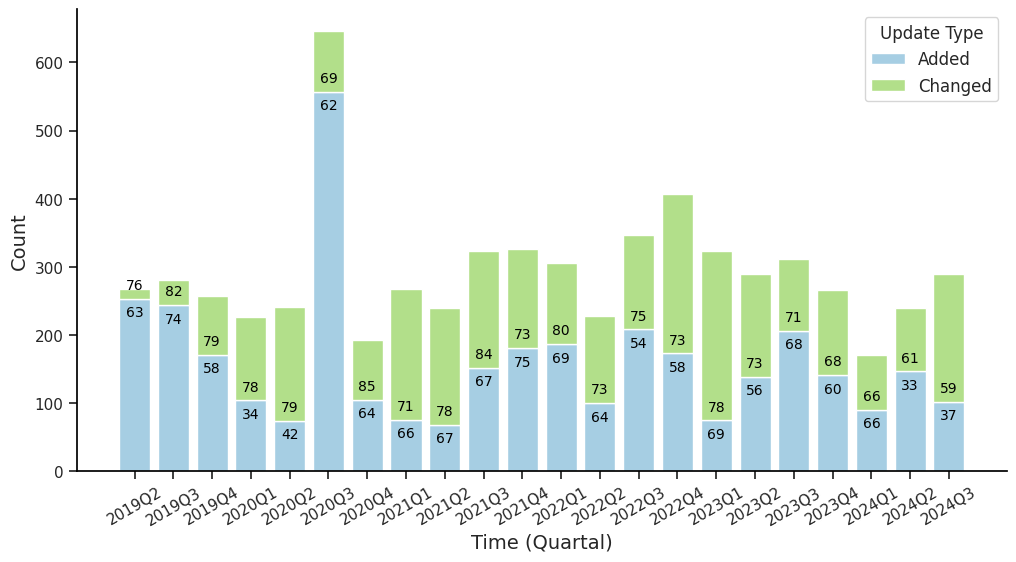

In [70]:
plt.figure(figsize=(12, 6))

#as string
updates_changed_q["file_quartal_str"] = updates_changed_q["file_quartal"].astype(str)

#remove first quartal 
updates_changed_w1 = updates_changed_q.iloc[1:]
# Initialize bottom position to zero
bottom = [0] * len(updates_changed_q)

# Plot the "Count_Added" bars
bars1 = plt.bar(updates_changed_w1["file_quartal_str"], 
                updates_changed_w1["Count_Added"], 
                color="#a6cee3", 
                label="Added")

# Plot the "Count_Changed" bars on top of "Count_Added"
bars2 = plt.bar(updates_changed_w1["file_quartal_str"], 
                updates_changed_w1["Count_Changed"], 
                bottom=updates_changed_w1["Count_Added"], 
                color="#b2df8a", 
                label="Changed")


#add text annotations for Mean_Added and Mean_Changed
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + bottom[i] - 20, 
             f'{updates_changed_w1["Mean_Added"].iloc[i]:.0f}', 
             ha="center", va="center", color="black", fontsize=10)
    
for i, bar in enumerate(bars1):
    #if this value is lower than 
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + bottom[i] + 20, 
             f'{updates_changed_w1["Mean_Changed"].iloc[i]:.0f}', 
             ha="center", va="center", color="black", fontsize=10)


#add legend
plt.legend(title="Update Type", fontsize=12)
plt.xlabel("Time (Quartal)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=30)

custom_plots()

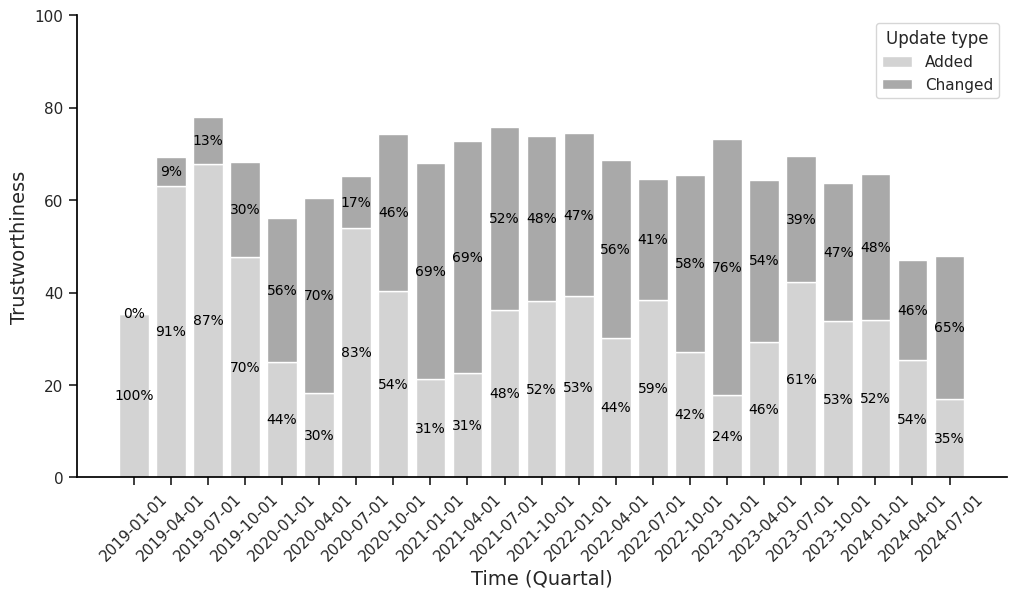

In [71]:
plt.figure(figsize=(12, 6))
colors = ["lightgrey", "darkgrey"]

updates_changed_q["file_quartal_dt"] = updates_changed_q["file_quartal"].dt.to_timestamp()
updates_changed_q['file_quartal_dt_str'] = updates_changed_q['file_quartal_dt'].dt.strftime('%Y-%m-%d')

bottom = np.zeros(len(updates_changed_q))  
for i, (date, mean, pct1, pct2) in enumerate(zip(updates_changed_q["file_quartal_dt_str"], updates_changed_q["Mean_All"], updates_changed_q["Percentage_Added"], updates_changed_q["Percentage_Changed"])):
    plt.bar(date, mean * pct1, bottom=bottom[i], color=colors[0], alpha=1, width=0.8, label="Added" if i == 0 else None)
    plt.text(date, mean * pct1 / 2 + bottom[i], f"{pct1 * 100:.0f}%", ha="center", va="center", color="black", fontsize=10)
    bottom[i] += mean  * pct1
    plt.bar(date, mean * pct2, bottom=bottom[i], color=colors[1], width=0.8, label="Changed" if i == 0 else None)
    plt.text(date, mean * pct2 / 2 + bottom[i], f"{pct2 * 100:.0f}%", ha="center", va="center", color="black", fontsize=10)
    bottom[i] += mean 

plt.xlabel("Time (Quartal)", fontsize=14)
plt.ylabel("Trustworthiness", fontsize=14)
plt.xticks(updates_changed_q["file_quartal_dt_str"], rotation=45)
plt.ylim(0, 100) 
custom_plots()

plt.legend(["Added", "Changed"], title="Update type", loc="upper right")

plt.show()

In [72]:
updates_changed_q["Mean_Added_Percentage"] = updates_changed_q["Mean_All"] * updates_changed_q["Percentage_Added"]

In [73]:
country_count["file_date_month"] = country_count["file_date"].dt.strftime('%Y-%m').astype(str)

In [74]:
updates_changed_q["file_quartal_dt"] = updates_changed_q["file_quartal_dt"] + pd.DateOffset(months=2)
updates_changed_q["file_quartal_dt_month"] = updates_changed_q["file_quartal_dt"].dt.strftime('%Y-%m').astype(str)

In [75]:
updates_changed_q["file_quartal_dt_month"].dtype == country_count["file_date_month"].dtype

True

In [76]:
print("country_count date range:", country_count["file_date_month"].min(), "to", country_count["file_date_month"].max())
print("updates_changed_q date range:", updates_changed_q["file_quartal_dt_month"].min(), "to", updates_changed_q["file_quartal_dt_month"].max())

country_count date range: 2019-03 to 2024-07
updates_changed_q date range: 2019-03 to 2024-09


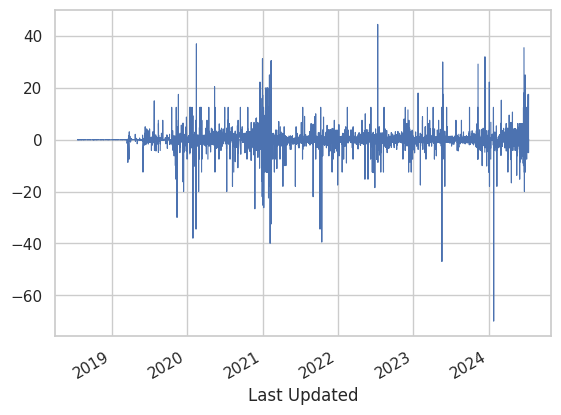

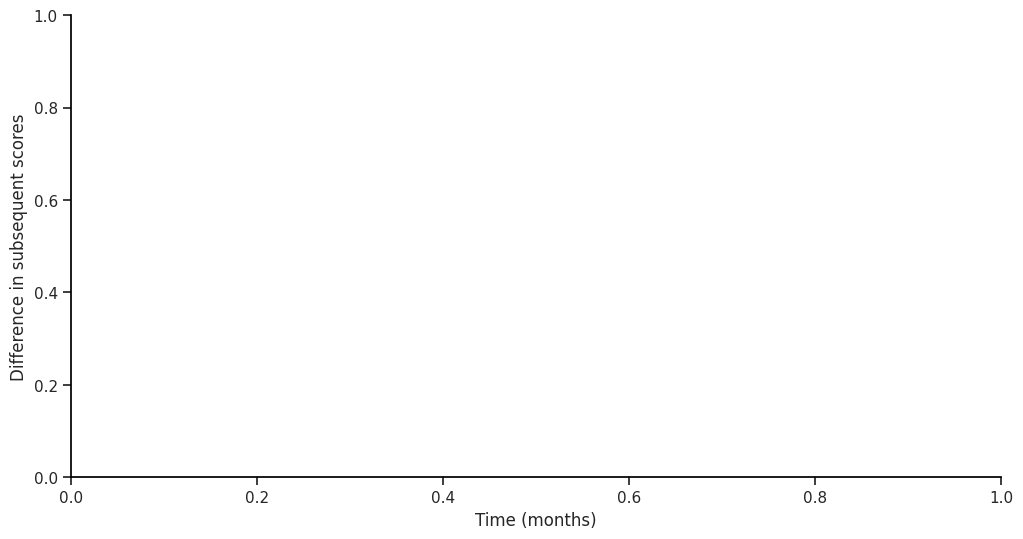

In [77]:
df_15_updates\
    .groupby(["Last Updated"]).Score_diff\
    .mean()\
    .plot(linewidth=0.8)

plt.figure(figsize=(12, 6))
plt.ylabel("Difference in subsequent scores")
plt.xlabel("Time (months)")
plt.xticks(rotation=0)
custom_plots()

plt.savefig(join(figures_path, "score_updates.png"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.savefig(join(figures_path, "score_updates.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

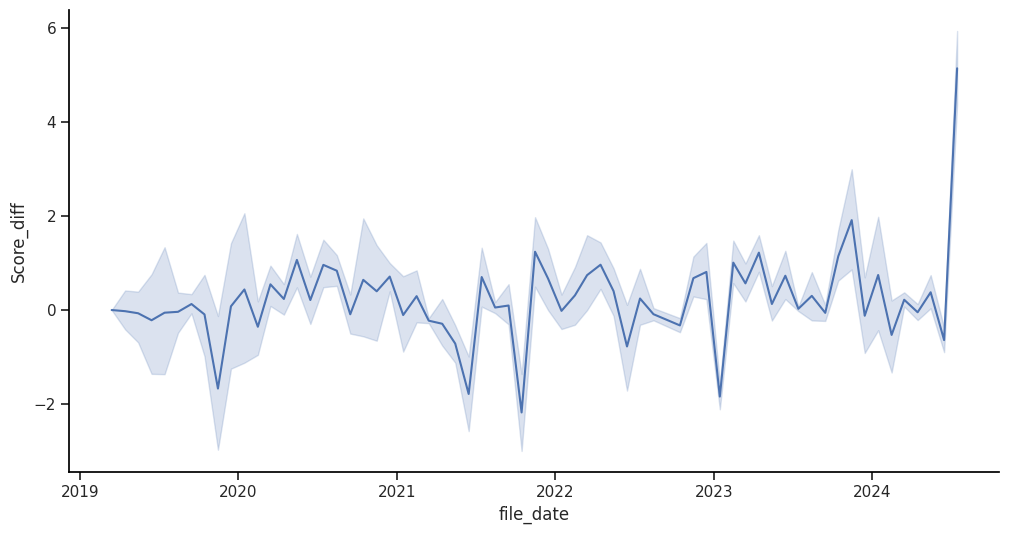

In [78]:
#plot Score_diff
plt.figure(figsize=(12, 6))

sns.lineplot(data=updated_df_15,
                x="file_date",
                y="Score_diff")

custom_plots()

In [79]:
#updated_df_15\
#        .sort_values(
#            "Score_diff", ascending=True)\
#                [["Domain", "Score_diff", "Last Updated"]]\
#        .head(5)

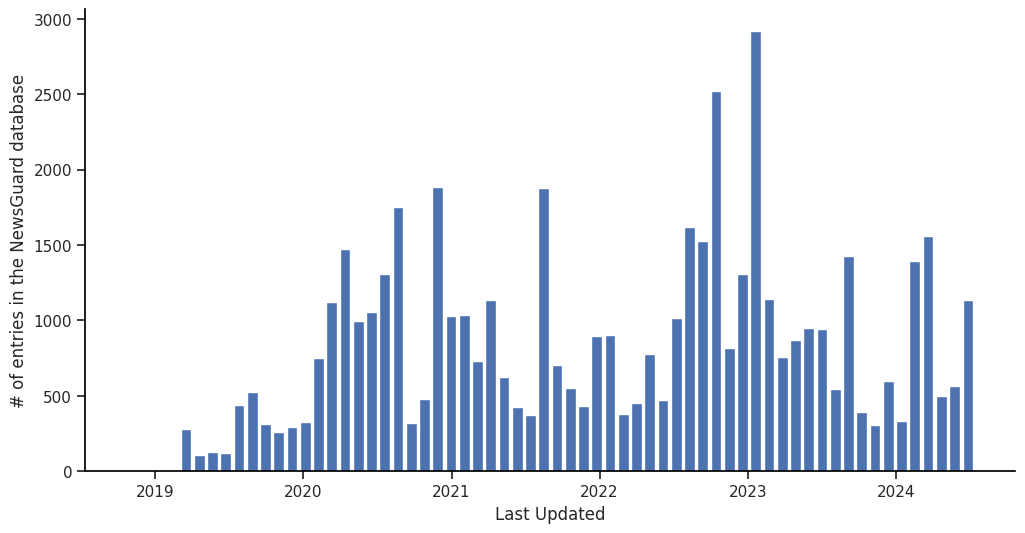

In [80]:
plt.figure(figsize=(12, 6))
updated_df_15["Last Updated"].hist(bins=updated_df_15["file_date"].nunique(), 
                               #color="blue", 
                               rwidth=0.8,
                               grid=False)

custom_plots()
plt.xlabel("Last Updated")
plt.ylabel("# of entries in the NewsGuard database")
plt.show()

In [81]:
#how many times do parent domains get updates?
parent_df_changes = actual_changes[actual_changes["Parent Domain"].notna()]

parent_df_changes["Parent_Update_diff"] = parent_df_changes\
    .groupby(["Parent Domain"])["Last Updated"]\
    .diff()

#calculate the average time between updates per domain
parent_changes = parent_df_changes\
    .groupby(["Parent Domain", "Country", "Language"])["Parent_Update_diff"]\
    .mean()\
    .reset_index()

parent_changes["Parent_Update_diff"].describe()

count                            464
mean      39 days 04:10:22.628373999
std      143 days 06:45:28.320750672
min      -1094 days +04:50:17.284500
25%      -1 days +23:59:59.996987500
50%           0 days 00:00:00.106500
75%       25 days 07:03:49.137917856
max        1138 days 21:23:12.619000
Name: Parent_Update_diff, dtype: object

In [82]:
#keep only rows with parent domain
parent_df_changes["Parent_Score_diff"] = \
    actual_changes\
        .groupby("Parent Domain")["Score"]\
        .diff()

#parent_df_changes\
#        .sort_values(
#            "Parent_Score_diff", ascending=True)\
#                [["Parent Domain", "Parent_Score_diff", "Last Updated"]]\
#        .head(3)

In [83]:
parent_score_diff = parent_df_changes\
                            .groupby("Parent Domain")["Parent_Score_diff"]\
                            .mean()

print(f'The average score difference between updates is: '
      f'{parent_score_diff.mean()}, '
      f'SD = {parent_score_diff.std()}.')
print(f'The range of score differences is: '
      f'max = {parent_score_diff.max()}, '
      f'min={parent_score_diff.min()}.')

The average score difference between updates is: 0.2835551244404176, SD = 2.5799797178835395.
The range of score differences is: max = 27.5, min=-15.666666666666666.


## Composition of trustworthiness score

In [84]:
#rename variable name
criteria_recent_list = [
                    "Does not repeatedly publish false or egregiously misleading content",
                    "Gathers and presents information responsibly",
                    "Has effective practices for correcting errors",
                    "Handles the difference between news and opinion responsibly",
                    "Avoids deceptive headlines",
                    "Website discloses ownership and financing",
                    "Clearly labels advertising",
                    "Reveals who's in charge, including any possible conflicts of interest",
                    "The site provides names of content creators, along with either contact or biographical information"] 

criteria_recent_list_numbers = [
                    "1 - Does not repeatedly publish false or egregiously misleading content",
                    "2 - Gathers and presents information responsibly",
                    "3 - Has effective practices for correcting errors",
                    "4 - Handles the difference between news and opinion responsibly",
                    "5 - Avoids deceptive headlines",
                    "6 - Website discloses ownership and financing",
                    "7 - Clearly labels advertising",
                    "8 - Reveals who's in charge, including any possible conflicts of interest",
                    "9 - The site provides names of content creators, along with either contact or biographical information"] 

In [85]:
#subset criteria and file_date
df_criteria_recent = df_recent[criteria_recent_list]
df_criteria_recent.columns = range(1,10)
df_criteria_recent = df_criteria_recent.astype(str)

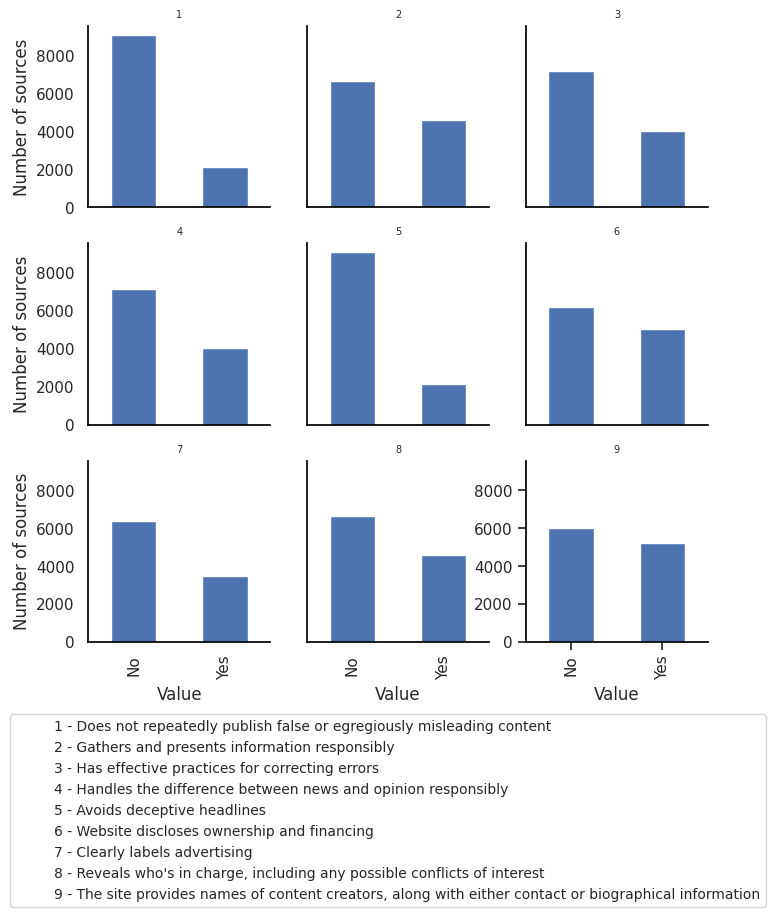

In [86]:
def plot_yesno(df):
    fig, axs = plt.subplots(nrows=3, 
                            ncols=3, 
                            sharex=True,
                            sharey=True,
                            figsize=(8, 8))

    for i, col in enumerate(df.columns):
        row = i // 3 
        col_in_row = i % 3 
        df[col] = df[col].replace("nan", np.nan)
        df[col]\
            .value_counts()\
            .plot(kind="bar",
                  ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f"{col}", fontsize=7)
        custom_plots(ax=axs[row, col_in_row])

    handles = [plt.Line2D([0,1],[0,1], 
                          linestyle="none", 
                          marker = " ", 
                          color="black") for _ in criteria_recent_list_numbers]
    labels = criteria_recent_list_numbers
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.23), 
               fontsize="small")
        
    plt.show()

plot_yesno(df_criteria_recent)

In [87]:
df_recent_critera = pd.melt(df_criteria_recent, 
                      value_vars=df_criteria_recent, 
                      var_name="Criteria", 
                      value_name="Label")
criteria_counts = df_recent_critera\
                    .groupby(["Criteria", "Label"])\
                    .size()\
                    .unstack(fill_value=0)\
                    .reset_index()

criteria_counts["Total"] = criteria_counts["Yes"] + criteria_counts["No"]
criteria_counts["Yes%"] = criteria_counts["Yes"] / criteria_counts["Total"] * 100
criteria_counts["No%"] = criteria_counts["No"] / criteria_counts["Total"] * 100

criteria_counts.sort_values(by="Yes", ascending=False)

Label  Criteria    No   Yes  Total       Yes%        No%
0             1  2126  9107  11233  81.073622  18.926378
4             5  2113  9107  11220  81.167558  18.832442
3             4  4033  7133  11166  63.881426  36.118574
1             2  4572  6661  11233  59.298496  40.701504
7             8  4572  6658  11230  59.287622  40.712378
6             7  3506  6374   9880  64.514170  35.485830
8             9  5996  5201  11197  46.449942  53.550058
5             6  6200  5033  11233  44.805484  55.194516
2             3  7198  4034  11232  35.915242  64.084758

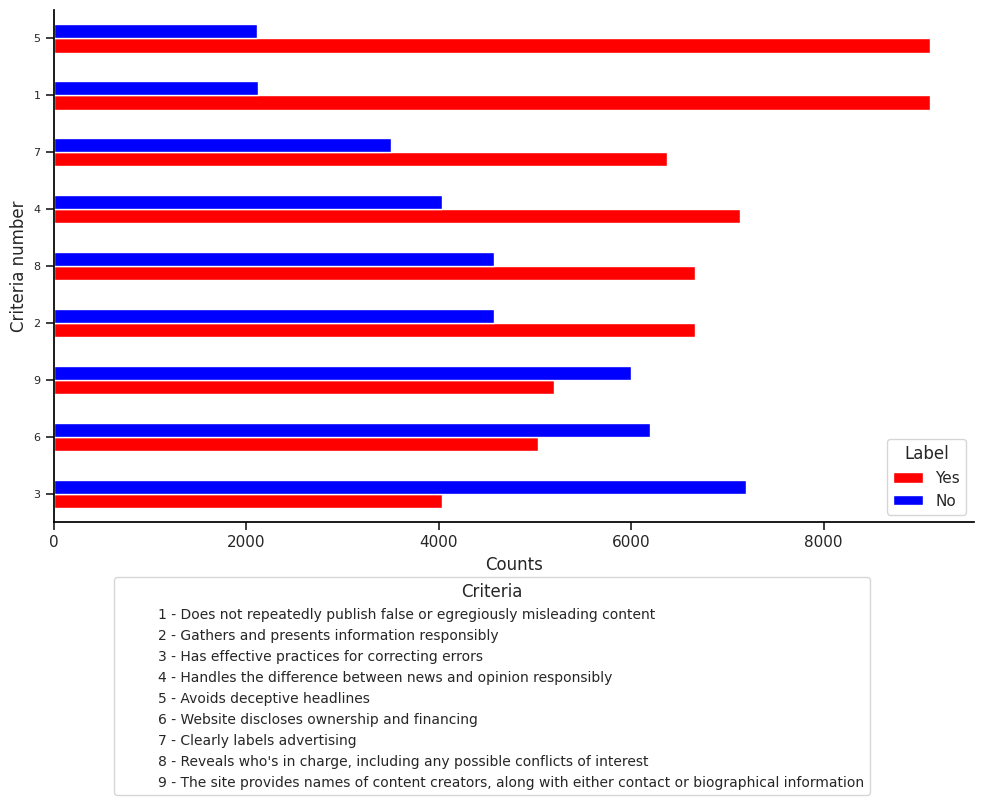

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
    
criteria_counts\
    .sort_values("No", ascending=False)\
    .plot(x="Criteria", 
              y=["Yes", "No"],
              kind="barh", 
              stacked=False,
              color=["red", "blue"], 
              ax=ax)
    
ax.set_xlabel("Counts")
ax.set_ylabel("Criteria number")
ax.tick_params(axis='y', labelsize=8)
ax.legend(title="Label", loc="lower right")

handles = [plt.Line2D([0], [0], color='black', lw=0) for _ in criteria_recent_list_numbers]
labels = criteria_recent_list_numbers
fig.legend(handles, labels, title="Criteria", 
           loc="lower center", bbox_to_anchor=(0.5, -0.35), fontsize="small")

plt.tight_layout()
custom_plots()

plt.show()

In [89]:
df_criteria_recent = \
    df_criteria_recent\
        .replace({"Yes": 1, "No": 0})\
        .fillna(0)

cooccurrence = \
    df_criteria_recent\
        .T\
        .dot(df_criteria_recent)
cooccurrence

/tmp/ipykernel_4191584/722380647.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})\


1       2       3       4       5       6       7       8       9
1  9107.0  6661.0  4030.0  6791.0  8947.0  4758.0  5804.0  5677.0  4857.0
2  6661.0  6661.0  3838.0  6162.0  6648.0  4480.0  4991.0  5318.0  4528.0
3  4030.0  3838.0  4034.0  3725.0  4018.0  2942.0  3383.0  3187.0  3230.0
4  6791.0  6162.0  3725.0  7133.0  6814.0  4494.0  5261.0  5326.0  4554.0
5  8947.0  6648.0  4018.0  6814.0  9107.0  4792.0  5754.0  5741.0  4923.0
6  4758.0  4480.0  2942.0  4494.0  4792.0  5033.0  3915.0  4160.0  3336.0
7  5804.0  4991.0  3383.0  5261.0  5754.0  3915.0  6374.0  4403.0  3832.0
8  5677.0  5318.0  3187.0  5326.0  5741.0  4160.0  4403.0  6658.0  4262.0
9  4857.0  4528.0  3230.0  4554.0  4923.0  3336.0  3832.0  4262.0  5201.0

In [90]:
#correlation matrix
corr = df_criteria_recent.corr()
corr.style.background_gradient(cmap="coolwarm")

In [91]:
#save as latex table
#round to 2 decimals
corr = corr.round(2)
corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))

In [92]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(df_criteria_recent)
chi_square_value, p_value # there is a significant correlation among the variables

(68504.9570967584, 0.0)

In [93]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(df_criteria_recent)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/newsguard/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.857028674137999

In [94]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_criteria_recent, 25)
ev, v = fa.get_eigenvalues()
ev #2 factors have eigenvalues > 1

array([4.85352373, 1.12610459, 0.72562125, 0.66086227, 0.53052344,
       0.41417903, 0.40574363, 0.2142402 , 0.06920187])

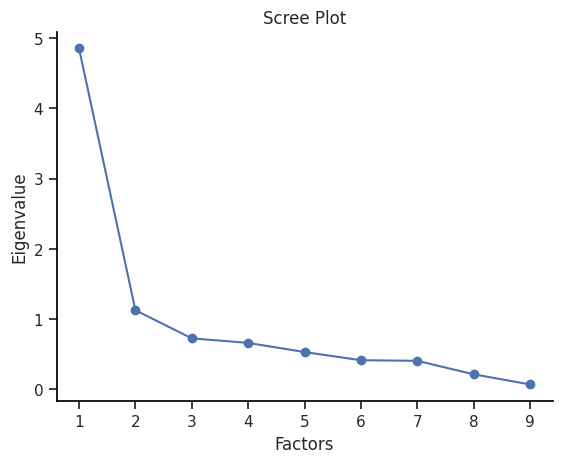

In [95]:
#screeplot
plt.scatter(range(1,df_criteria_recent.shape[1]+1),ev)
plt.plot(range(1,df_criteria_recent.shape[1]+1),ev)
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
custom_plots()
plt.show()

In [96]:
fa = FactorAnalyzer(n_factors=2, 
                    rotation="oblimin")
fa.fit(df_criteria_recent)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, 
                           index=df_criteria_recent.columns)
loadings_df

0         1
1 -0.016279  1.007858
2  0.773456  0.173081
3  0.658098  0.006051
4  0.704403  0.144479
5  0.068986  0.886352
6  0.698492 -0.042629
7  0.553331  0.051918
8  0.734128 -0.183371
9  0.708897 -0.060265

In [97]:
#variance explained
fa.get_factor_variance()[0]

array([3.36808067, 1.89403624])

In [98]:
#in percentage
fa.get_factor_variance()[2]*100

array([37.42311852, 58.46796564])

### Trustworthiness

In [99]:
#regression: which criteria are most important for the overall score?
for criteria in criteria_recent_list:
    df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
    df_recent = df_recent.dropna(subset=[criteria])
    df_recent = df_recent.dropna(subset=["Score"])
    X = df_recent[criteria]
    y = df_recent["Score"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(f'Criteria: {criteria}')
    print(f'Coefficient: {model.params[criteria]}')
    print(f'P-value: {model.pvalues[criteria]}')

/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to t

Criteria: Does not repeatedly publish false or egregiously misleading content
Coefficient: 63.37777820933242
P-value: 0.0
Criteria: Gathers and presents information responsibly
Coefficient: 60.13365717815339
P-value: 0.0
Criteria: Has effective practices for correcting errors
Coefficient: 47.440082444540465
P-value: 0.0
Criteria: Handles the difference between news and opinion responsibly
Coefficient: 55.28630902805531
P-value: 0.0
Criteria: Avoids deceptive headlines
Coefficient: 62.93141647616408
P-value: 0.0
Criteria: Website discloses ownership and financing
Coefficient: 42.55416997812936
P-value: 0.0
Criteria: Clearly labels advertising
Coefficient: 37.040906454173594
P-value: 0.0
Criteria: Reveals who's in charge, including any possible conflicts of interest
Coefficient: 30.244000236399874
P-value: 0.0
Criteria: The site provides names of content creators, along with either contact or biographical information
Coefficient: 39.72589678492312
P-value: 0.0


/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
/tmp/ipykernel_4191584/2990186667.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to t

In [100]:
#multiple combinations of criteria
combinations = df_criteria_recent\
                .groupby(df_criteria_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(df_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(10)

1    2    3    4    5    6    7    8    9  Counts  Percentage
210  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0    1533   15.606230
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1447   14.730734
69   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    1339   13.631274
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     549    5.588924
177  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     485    4.937392
202  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     476    4.845770
176  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0     451    4.591265
165  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0     387    3.939733
209  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     342    3.481625
208  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     340    3.461264

### Criteria changes over time

In [101]:
criteria_all_list = [
       "Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]

In [102]:
counts_data = []

for column in criteria_all_list:
    column_counts = df_15\
                        .groupby("file_date")[column]\
                        .count()\
                        .reset_index()
    column_counts = column_counts\
                        .rename(columns={column: "count"})
    column_counts["criteria"] = column
    counts_data.append(column_counts)

counts_table = pd.concat(counts_data, ignore_index=True)

counts_table = counts_table[["file_date", "criteria", "count"]]

first_ratings = counts_table[counts_table["count"] > 0]

first_ratings = first_ratings\
    .groupby("criteria")\
        .agg(
            min_date=("file_date", "min"),
            max_date=("file_date", "max"))\
    .reset_index()

first_ratings

criteria  \
0                                                                           Avoids deceptive headlines   
1                                                                           Clearly labels advertising   
2                                                            Does not repeatedly publish false content   
3                                  Does not repeatedly publish false or egregiously misleading content   
4                                                         Gathers and presents information responsibly   
5                                          Handles the difference between news and opinion responsibly   
6                                                        Has effective practices for correcting errors   
7                                                               Regularly corrects or clarifies errors   
8                                Reveals who's in charge, including any possible conflicts of interest   
9   The site provides names of content creators, along with either contact or biographical information   
10                                                           Website discloses ownership and financing   

              min_date            max_date  
0  2019-03-15 01:00:00 2024-07-15 01:00:00  
1  2019-03-15 01:00:00 2024-07-15 01:00:00  
2  2019-03-15 01:00:00 2023-11-15 01:00:00  
3  2023-12-15 01:00:00 2024-07-15 01:00:00  
4  2019-03-15 01:00:00 2024-07-15 01:00:00  
5  2019-03-15 01:00:00 2024-07-15 01:00:00  
6  2023-12-15 01:00:00 2024-07-15 01:00:00  
7  2019-03-15 01:00:00 2023-11-15 01:00:00  
8  2019-03-15 01:00:00 2024-07-15 01:00:00  
9  2019-03-15 01:00:00 2024-07-15 01:00:00  
10 2019-03-15 01:00:00 2024-07-15 01:00:00

In [103]:
df_criteria_15 = df_15[
       ["Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]
       ]

In [104]:
#criteria changes over time 
df_15 = df_15\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_avg = df_15\
    .groupby("file_date")[criteria_all_list]\
    .sum()

#collapse two columns and calculate mean
criteria_avg["Does not repeatedly publish false or egregiously misleading content"] = \
    criteria_avg[[
        "Does not repeatedly publish false content", 
        "Does not repeatedly publish false or egregiously misleading content"]]\
    .mean(axis=1)

criteria_avg["Has effective practices for correcting errors"] = \
    criteria_avg[[
        "Regularly corrects or clarifies errors", 
        "Has effective practices for correcting errors"]]\
    .mean(axis=1)

criteria_avg = \
    criteria_avg.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

criteria_avg.columns = \
    [f"{i + 1} - {col}" for i, col in enumerate(criteria_avg.columns)]

/tmp/ipykernel_4191584/1525396100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1,


In [105]:
#calculate the total number per year
criteria_sum = criteria_avg\
    .reset_index()\
    .melt(id_vars="file_date", 
          value_vars=criteria_avg.columns, 
          var_name="Criteria", 
          value_name="Count")

criteria_sum = criteria_sum\
    .groupby("file_date")["Count"]\
    .sum()\
    .reset_index(name="Total")

#merge 
criteria_avg = criteria_avg\
    .merge(criteria_sum, 
           on="file_date")

In [106]:
#standardize by number of sources per month 
n_sources_month = df_15\
    .groupby("file_date")\
    .size()\
    .reset_index(name="N")

#merge
criteria_avg = criteria_avg\
    .merge(n_sources_month, 
           on="file_date")

#standardize criteria columns by number of sources 
for column in criteria_avg.columns[1:11]:
    criteria_avg[column] = criteria_avg[column] / criteria_avg["N"] * 100

criteria_avg.head(3)

file_date  \
0 2019-03-15 01:00:00   
1 2019-04-15 01:00:00   
2 2019-05-15 01:00:00   

   1 - Does not repeatedly publish false or egregiously misleading content  \
0                                                                39.516434   
1                                                                39.127219   
2                                                                39.990154   

   2 - Gathers and presents information responsibly  \
0                                         71.212694   
1                                         69.970414   
2                                         71.808336   

   3 - Has effective practices for correcting errors  \
0                                          26.917265   
1                                          26.497781   
2                                          26.206104   

   4 - Handles the difference between news and opinion responsibly  \
0                                                        67.434832   
1                                                        66.124260   
2                                                        68.231047   

   5 - Avoids deceptive headlines  \
0                       73.517189   
1                       72.226331   
2                       74.236954   

   6 - Website discloses ownership and financing  \
0                                      57.725727   
1                                      56.360947   
2                                      57.630456   

   7 - Clearly labels advertising  \
0                       80.204005   
1                       79.326923   
2                       80.275681   

   8 - Reveals who's in charge, including any possible conflicts of interest  \
0                                                                  66.981488   
1                                                                  66.715976   
2                                                                  67.804398   

   9 - The site provides names of content creators, along with either contact or biographical information  \
0                                                                                               64.185871   
1                                                                                               63.054734   
2                                                                                               60.846734   

        Total     N  
0  547.695504  2647  
1  539.404586  2704  
2  547.029865  3047

<Figure size 1200x800 with 0 Axes>

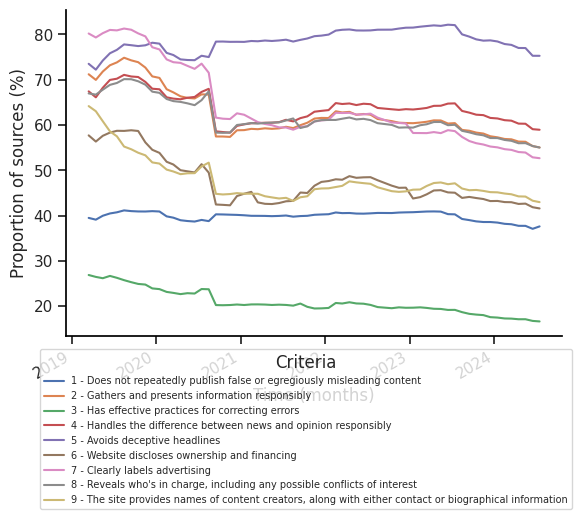

In [107]:
plt.figure(figsize=(12,8))
criteria_avg.iloc[:, :-2].plot(
         kind="line",
         x="file_date"
         #stacked=True
         )

#add line with total
#criteria_avg["Total"]\
#    .plot(
#        color="black", 
#        linestyle="--", 
#        linewidth=2)

plt.xlabel("Time (months)")
plt.ylabel("Proportion of sources (%)")
plt.legend(title="Criteria",
           fontsize=7,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.17),
            bbox_transform=plt.gcf().transFigure,
            ncol=1)
custom_plots()
plt.show()

In [108]:
#turn into year fomat
criteria_avg["file_year"] = criteria_avg["file_date"].dt.year

#aggregate per year
criteria_avg_year = criteria_avg\
    .groupby("file_year")\
    .mean()

criteria_avg_year

file_date  \
file_year                                 
2019      2019-07-30 17:48:00.000000000   
2020      2020-06-30 09:00:00.000000000   
2021      2021-06-30 13:00:00.000000000   
2022      2022-06-23 14:05:27.272727296   
2023      2023-06-30 13:00:00.000000000   
2024      2024-04-15 01:00:00.000000000   

           1 - Does not repeatedly publish false or egregiously misleading content  \
file_year                                                                            
2019                                                                     40.494189   
2020                                                                     39.646235   
2021                                                                     40.004910   
2022                                                                     40.572612   
2023                                                                     39.943600   
2024                                                                     37.870406   

           2 - Gathers and presents information responsibly  \
file_year                                                     
2019                                              72.646755   
2020                                              64.036724   
2021                                              59.776122   
2022                                              61.862501   
2023                                              59.683151   
2024                                              56.312420   

           3 - Has effective practices for correcting errors  \
file_year                                                      
2019                                               25.745466   
2020                                               22.266910   
2021                                               20.190487   
2022                                               20.214641   
2023                                               18.949857   
2024                                               17.131069   

           4 - Handles the difference between news and opinion responsibly  \
file_year                                                                    
2019                                                             69.192883   
2020                                                             64.025721   
2021                                                             61.182020   
2022                                                             64.129406   
2023                                                             63.396739   
2024                                                             60.311297   

           5 - Avoids deceptive headlines  \
file_year                                   
2019                            76.104560   
2020                            76.367077   
2021                            78.816205   
2022                            80.948647   
2023                            80.742492   
2024                            76.942902   

           6 - Website discloses ownership and financing  \
file_year                                                  
2019                                           57.577744   
2020                                           48.235201   
2021                                           44.308445   
2022                                           47.680464   
2023                                           44.409517   
2024                                           42.569450   

           7 - Clearly labels advertising  \
file_year                                   
2019                            80.100355   
2020                            69.692691   
2021                            60.305352   
2022                            61.769662   
2023                            57.480321   
2024                            53.979681   

           8 - Reveals who's in charge, including any possible conflicts of interest  \
file_year                                                     

### Updates

In [109]:
#subset the first entry and the updates only
df_15_criteria_updates = \
    df_15_updates[df_15_updates["Added"] | df_15_updates["Updated"]]

#recode criteria columns recent to 1 and 0
df_15_criteria_updates = df_15_criteria_updates\
    .replace({"Yes": 1, "No": 0})

/tmp/ipykernel_4191584/2297463855.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})


In [110]:
#collapse the two columns
df_15_criteria_updates["Does not repeatedly publish false or egregiously misleading content"] = \
    df_15_criteria_updates[["Does not repeatedly publish false content", 
                "Does not repeatedly publish false or egregiously misleading content"]]\
    .max(axis=1)

df_15_criteria_updates["Has effective practices for correcting errors"] = \
    df_15_criteria_updates[["Regularly corrects or clarifies errors", 
                "Has effective practices for correcting errors"]]\
    .max(axis=1)

df_15_criteria_updates = \
    df_15_criteria_updates.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

In [111]:
for criterion in criteria_recent_list:
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates\
            .groupby(["Domain", "Country", "Language"])[criterion]\
            .diff()
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates[f'Diff_{criterion}']
    
    df_15_criteria_updates.head(10)

In [112]:
df_15_criteria_updates["Updated_Any_Criterion"] = \
    df_15_criteria_updates\
        .apply(lambda row: 
               any(row[f'Diff_{c}'] != 0 and 
                   not pd.isna(row[f'Diff_{c}']) 
                   for c in criteria_recent_list),
                axis=1)

In [113]:
#per domain, count the number of times the criteria have changed
criteria_domain_changes = df_15_criteria_updates\
    .groupby(["Domain", "Country", "Language"])["Updated_Any_Criterion"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Updated_Any_Criterion": "Criteria_changes_count"})

#how many zeros?
criteria_domain_changes["Criteria_changes_count"]\
    .value_counts(
        normalize=True)

Criteria_changes_count
0    0.600047
1    0.237596
2    0.105288
3    0.042705
4    0.012035
5    0.002096
6    0.000155
7    0.000078
Name: proportion, dtype: float64

In [114]:
df_15_criteria_diffs = df_15_criteria_updates[
    [col for col in df_15_criteria_updates.columns 
     if col.startswith("Diff_")]]

In [115]:
criteria_change = \
    df_15_criteria_diffs\
        .mean()\
        .reset_index()\
        .rename(columns={"index": "Criteria", 
                         0: "Avg Change"})

total_change = df_15_criteria_diffs\
                    .astype(bool)\
                    .sum()

negative_changes = (df_15_criteria_diffs < 0).sum()
positive_changes = (df_15_criteria_diffs > 0).sum()

negative_changes_percentage = \
    (negative_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)


positive_changes_percentage = \
    (positive_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)

criteria_changes = pd.DataFrame({
    "Criteria": criteria_change["Criteria"],
    "Total Change": total_change.values,
    "Avg. Change": criteria_change["Avg Change"],
    "Negative Changes": negative_changes_percentage.values,
    "Positive Changes": positive_changes_percentage.values}
    )

criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .str.replace("Diff_", "")

criteria_changes.sort_values(by="Total Change")

Criteria  \
0                                 Does not repeatedly publish false or egregiously misleading content   
1                                                        Gathers and presents information responsibly   
4                                                                          Avoids deceptive headlines   
3                                         Handles the difference between news and opinion responsibly   
7                               Reveals who's in charge, including any possible conflicts of interest   
8  The site provides names of content creators, along with either contact or biographical information   
2                                                       Has effective practices for correcting errors   
5                                                           Website discloses ownership and financing   
6                                                                          Clearly labels advertising   

   Total Change  Avg. Change  Negative Changes  Positive Changes  
0         13781     0.003678              0.93              2.61  
1         13806    -0.000700              2.04              1.72  
4         13845     0.002123              1.40              2.37  
3         14400     0.004282              2.42              4.36  
7         14675    -0.000292              5.79              5.65  
8         15154     0.004774              6.43              8.60  
2         15540     0.001771              9.14              9.94  
5         16000    -0.003795             12.44             10.72  
6         19171    -0.013611             10.11              4.41

In [116]:
#df_15_criteria_updates\
#    [df_15_criteria_updates["Diff_Website discloses ownership and financing"] == -1]\
#    ["Domain"].unique()

In [117]:
#bar chart with change percentages
#change the label of one of the criteria
criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .replace({"Does not repeatedly publish false or egregiously misleading content": 
                   "1",
                   "Gathers and presents information responsibly":
                    "2",
                    "Has effective practices for correcting errors":
                    "3",
                   "Handles the difference between news and opinion responsibly":
                   "4",
                   "Avoids deceptive headlines":
                    "5",
                    "Website discloses ownership and financing":
                    "6",
                    "Clearly labels advertising":
                    "7",
                    "Reveals who's in charge, including any possible conflicts of interest":
                    "8",
                   "The site provides names of content creators, along with either contact or biographical information":
                   "9"
                   })

#reshape negative and positive change to long format
criteria_changes = \
    criteria_changes.melt(
        id_vars=["Criteria"],
        value_vars=["Negative Changes", "Positive Changes"],
        var_name="Change",
        value_name="Value")


criteria_changes =\
    criteria_changes.sort_values(
        by="Value", 
        ascending=False)

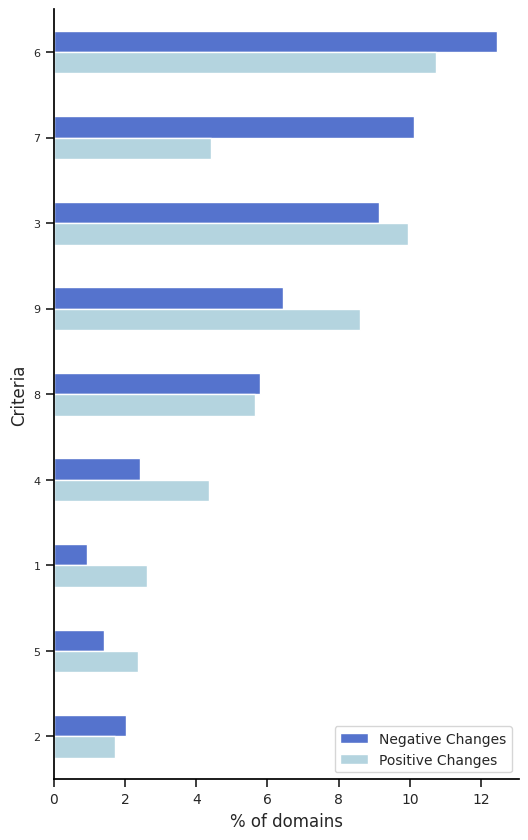

In [118]:
plt.figure(figsize=(6, 10))
sns.barplot(data=criteria_changes, 
            x="Value", 
            y="Criteria", 
            hue="Change",
            palette={"Negative Changes": year_colors[3], 
                     "Positive Changes": year_colors[2]},
            width=0.5)

plt.xlabel("% of domains")
plt.ylabel("Criteria")
plt.yticks(fontsize=8)
plt.xticks(fontsize=10)
plt.legend(prop={"size": 10})
custom_plots()
plt.show()

## Countries

In [119]:
lang = df_recent\
    .groupby("Language")\
    .size()\
    .reset_index()

lang\
    .columns = ["Language", "n"]

lang["%"] = \
    (lang["n"] / lang["n"].sum()) * 100

lang

Language     n          %
0       de   349   3.552886
1       en  8646  88.017917
2       fr   361   3.675048
3       it   467   4.754148

In [120]:
countries_lang = df_recent\
    .groupby(["Country", "Language"])\
    .size()\
    .reset_index()

countries_lang\
    .columns = ["Country", "Language", "n"]

countries_lang["\%"] = \
    round((countries_lang["n"] / len(df_recent)) *100, 1)

countries_lang

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4191584/3125748545.py:9: SyntaxWarning: invalid escape sequence '\%'
  countries_lang["\%"] = \


Country Language     n    \%
0      ALL       en  1173  11.9
1       AT       de    40   0.4
2       AU       en   141   1.4
3       CA       en   393   4.0
4       CA       fr    47   0.5
5       DE       de   309   3.1
6       FR       fr   314   3.2
7       GB       en   499   5.1
8       IT       it   467   4.8
9       NZ       en    19   0.2
10      US       en  6421  65.4

In [121]:
#save table as latex >turn into function for later tables?
countries_lang_latex = countries_lang \
    .sort_values("n", ascending=False) \
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:countries_language", 
        position='H',
        column_format=' X c c c c',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
countries_lang_latex = \
    countries_lang_latex\
    .replace("\\end{tabular}", "\\end{tabularx}")

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} As of July 15th, 2024.")

with open(join(tables_path, 
               "countries_language.tex"), 'w') as f:
    f.write(countries_lang_latex)

In [122]:
country_means = \
    df_recent\
        .groupby("Country")\
        .agg({"Score": ["mean", "std", "size"]})\
        .reset_index()\
        .round(1)

country_means\
    .columns = ["Country", "Score_mean", "Score_std", "n"]

country_means["Trustworthiness (SD)"] = \
    country_means\
        .apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', 
               axis=1)

country_means = \
    country_means\
        .drop(["Score_mean", "Score_std"], 
              axis=1)

#percentage
country_means["%"] = \
    (country_means["n"] / len(df_recent) * 100)\
        .round(1)

#order
country_means = \
    country_means\
        .sort_values("n", ascending=False)\
        .reset_index(drop=True)

country_means["n (\%)"] = \
    country_means\
        .apply(lambda row: f'{row["n"]} ({row["%"]})', 
               axis=1)

country_means = \
    country_means\
        .drop("%", 
              axis=1)

#reorder columns
country_means = \
    country_means[["Country", "n (\%)", 
                   "Trustworthiness (SD)"]]

country_means

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:44: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:44: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4191584/3567747754.py:32: SyntaxWarning: invalid escape sequence '\%'
  country_means["n (\%)"] = \
/tmp/ipykernel_4191584/3567747754.py:44: SyntaxWarning: invalid escape sequence '\%'
  country_means[["Country", "n (\%)",


Country       n (\%) Trustworthiness (SD)
0      US  6421 (65.4)          59.2 (33.6)
1     ALL  1173 (11.9)          75.1 (25.0)
2      GB    499 (5.1)          80.9 (20.7)
3      IT    467 (4.8)          74.0 (20.9)
4      CA    440 (4.5)          88.3 (14.4)
5      FR    314 (3.2)          70.9 (25.7)
6      DE    309 (3.1)          80.1 (29.1)
7      AU    141 (1.4)          74.1 (22.6)
8      AT     40 (0.4)          77.2 (29.6)
9      NZ     19 (0.2)          79.7 (21.2)

In [123]:
df_recent\
    .groupby("Language")["Score"]\
    .mean()\
    .sort_values(ascending=False)

Language
de    79.792264
it    74.021413
fr    71.889197
en    64.305170
Name: Score, dtype: float64

In [124]:
country_score_time = df_15\
    .groupby(["Country","file_date"])\
    .agg({"Score": ["mean", "std"]})\
    .reset_index()
country_score_time.columns = ["Country", "file_date", "Score", "SD"]

In [125]:
country_score_count = df_15\
    .groupby(["file_date", "Country"])\
    .size()\
    .reset_index(name="Count")

country_score_time = country_score_time\
    .merge(country_score_count, 
           on=["Country", "file_date"])

country_score_time

Country           file_date      Score         SD  Count
0       ALL 2019-05-15 01:00:00  80.255319  19.311920     95
1       ALL 2019-06-15 01:00:00  82.393701  20.395364    258
2       ALL 2019-07-15 01:00:00  81.885294  20.598961    344
3       ALL 2019-08-15 01:00:00  81.072917  20.561403    485
4       ALL 2019-09-15 01:00:00  79.387387  22.296076    560
..      ...                 ...        ...        ...    ...
467      US 2024-03-15 01:00:00  58.628518  33.600791   7682
468      US 2024-04-15 01:00:00  58.146648  33.798455   7802
469      US 2024-05-15 01:00:00  58.161771  33.798273   7813
470      US 2024-06-15 01:00:00  56.606808  34.420013   8064
471      US 2024-07-15 01:00:00  56.803269  34.252442   8120

[472 rows x 5 columns]

In [126]:
country_score_time.groupby("Country").Score\
                .mean()\
                .sort_values(ascending=False)

Country
CA     86.733248
GB     79.728674
NZ     79.136866
DE     78.011721
AT     73.405310
IT     72.890127
ALL    72.331913
AU     71.817467
FR     66.320156
US     61.857929
Name: Score, dtype: float64

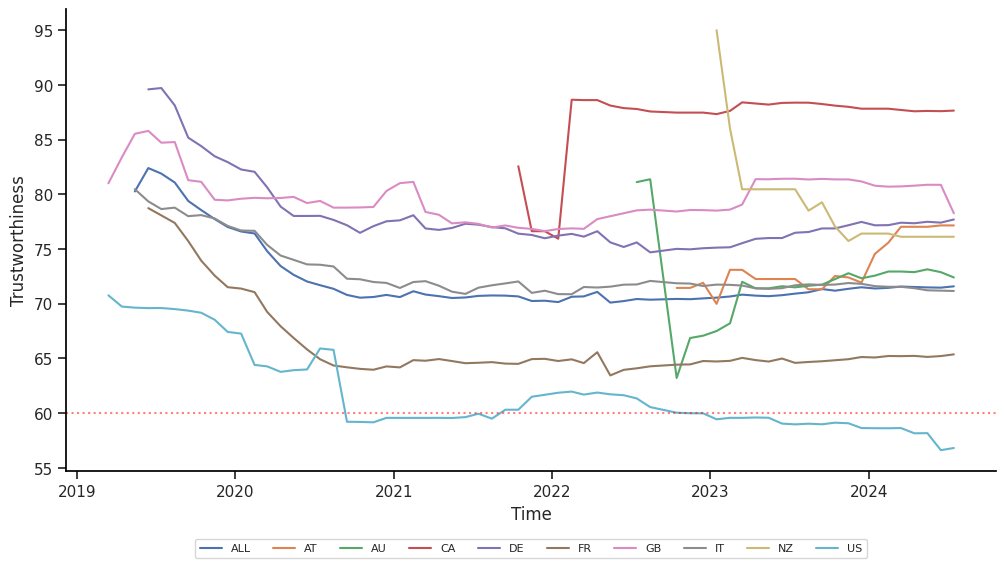

In [127]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=country_score_time, 
             x="file_date", 
             y="Score", 
             hue="Country", 
             estimator="mean")

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Trustworthiness")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=10, 
           fontsize=8)
custom_plots()
plt.show()

/tmp/ipykernel_4191584/1897072828.py:11: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df_15_ALL,
/tmp/ipykernel_4191584/1897072828.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.pointplot(data=df_15_ALL,


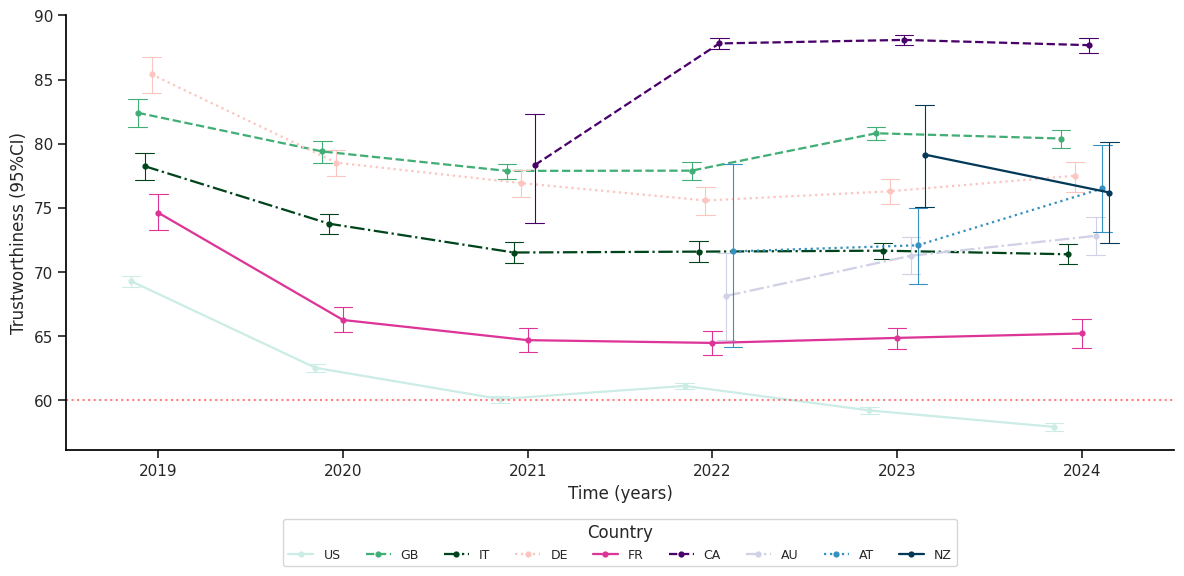

In [128]:
plt.figure(figsize=(12, 6))

country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
country_linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--"]
country_palette = ['#ccece6','#41ae76','#00441b', '#fcc5c0','#dd3497','#49006a', '#d0d1e6','#3690c0','#023858']
#sns.color_palette("tab10", 10)

#remove ALL
df_15_ALL = df_15_year[df_15_year["Country"] != "ALL"]

sns.pointplot(data=df_15_ALL,
              x="file_year", 
              y="Score", 
              hue="Country",
              scale=0.6,
              capsize=0.1,
              errwidth=0.8,
              estimator="mean",
              dodge=0.3,
              errorbar="ci",
              palette=country_palette,
              linestyles=country_linestyles
              )

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness (95%CI)")

plt.legend(
    title="Country",
    loc="lower center", 
    bbox_to_anchor=(0.5, -0.28), 
    ncol=10, 
    fontsize=9)
plt.tight_layout()
custom_plots()

plt.show()

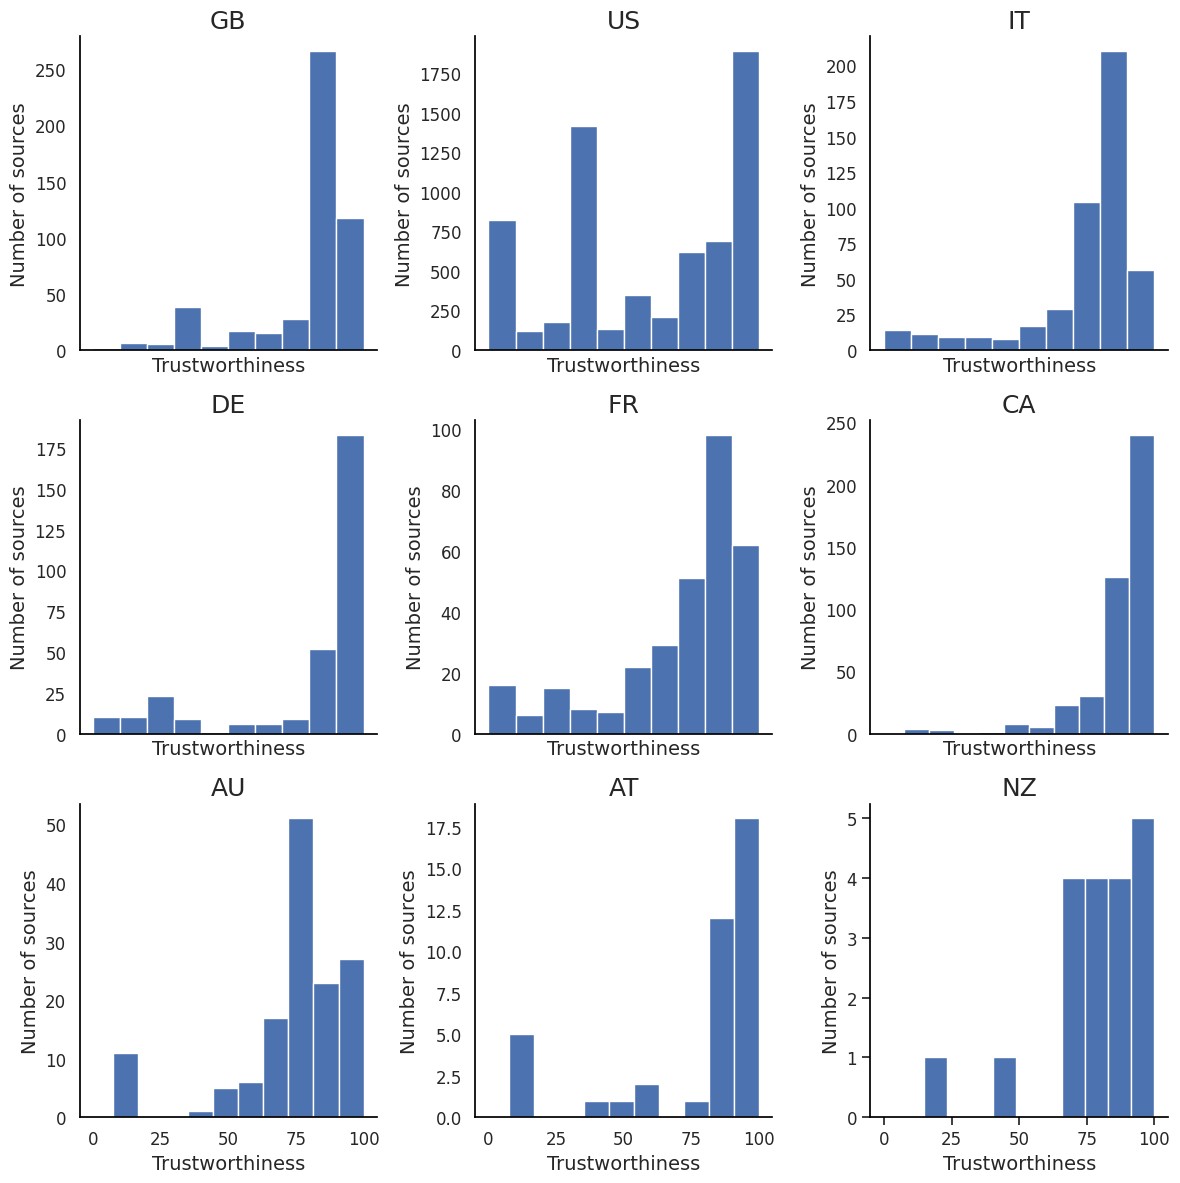

In [129]:
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.7, wspace=0.7)

country_df = df_recent[df_recent["Country"] != "ALL"] 
for i, country in enumerate(country_df["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = country_df[country_df["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness", fontsize=14)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="both", labelsize=12)
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()

plt.savefig(join(figures_path,"scores_per_country_recent.png"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.savefig(join(figures_path,"scores_per_country_recent.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

In [130]:
#do the same with the number of domains over time
country_domains = df_15\
    .groupby(["Country","file_date"])\
    .size()\
    .reset_index(name="Count")

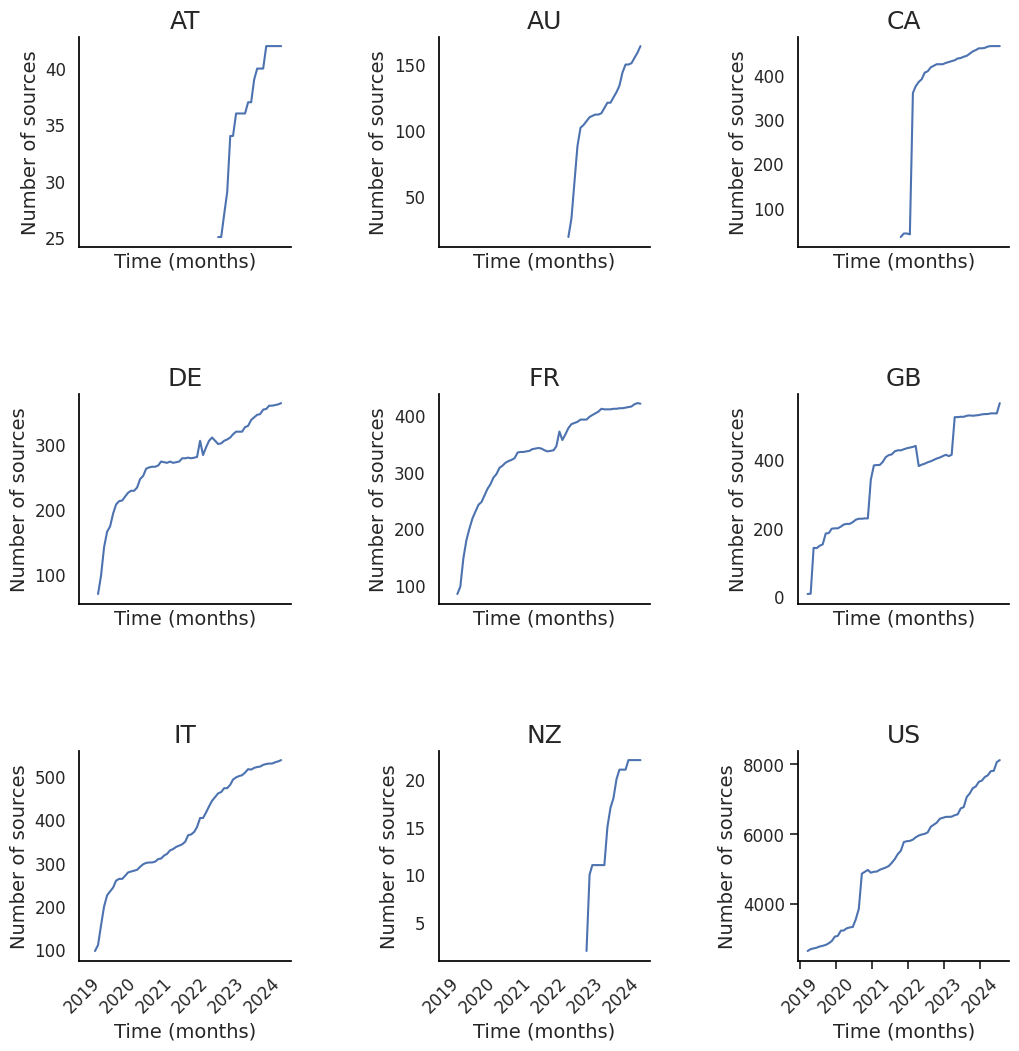

In [131]:
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.7, wspace=0.7)

filtered_countries = \
    country_domains[country_domains["Country"] != "ALL"]["Country"].unique()
for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Count"], label=country)
    axs[row, col_in_row].set_xlabel("Time (months)", fontsize=14)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    custom_plots(ax=axs[row, col_in_row])

plt.savefig(join(figures_path,"n_sources_per_country_over_time.png"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.savefig(join(figures_path,"n_sources_per_country_over_time.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

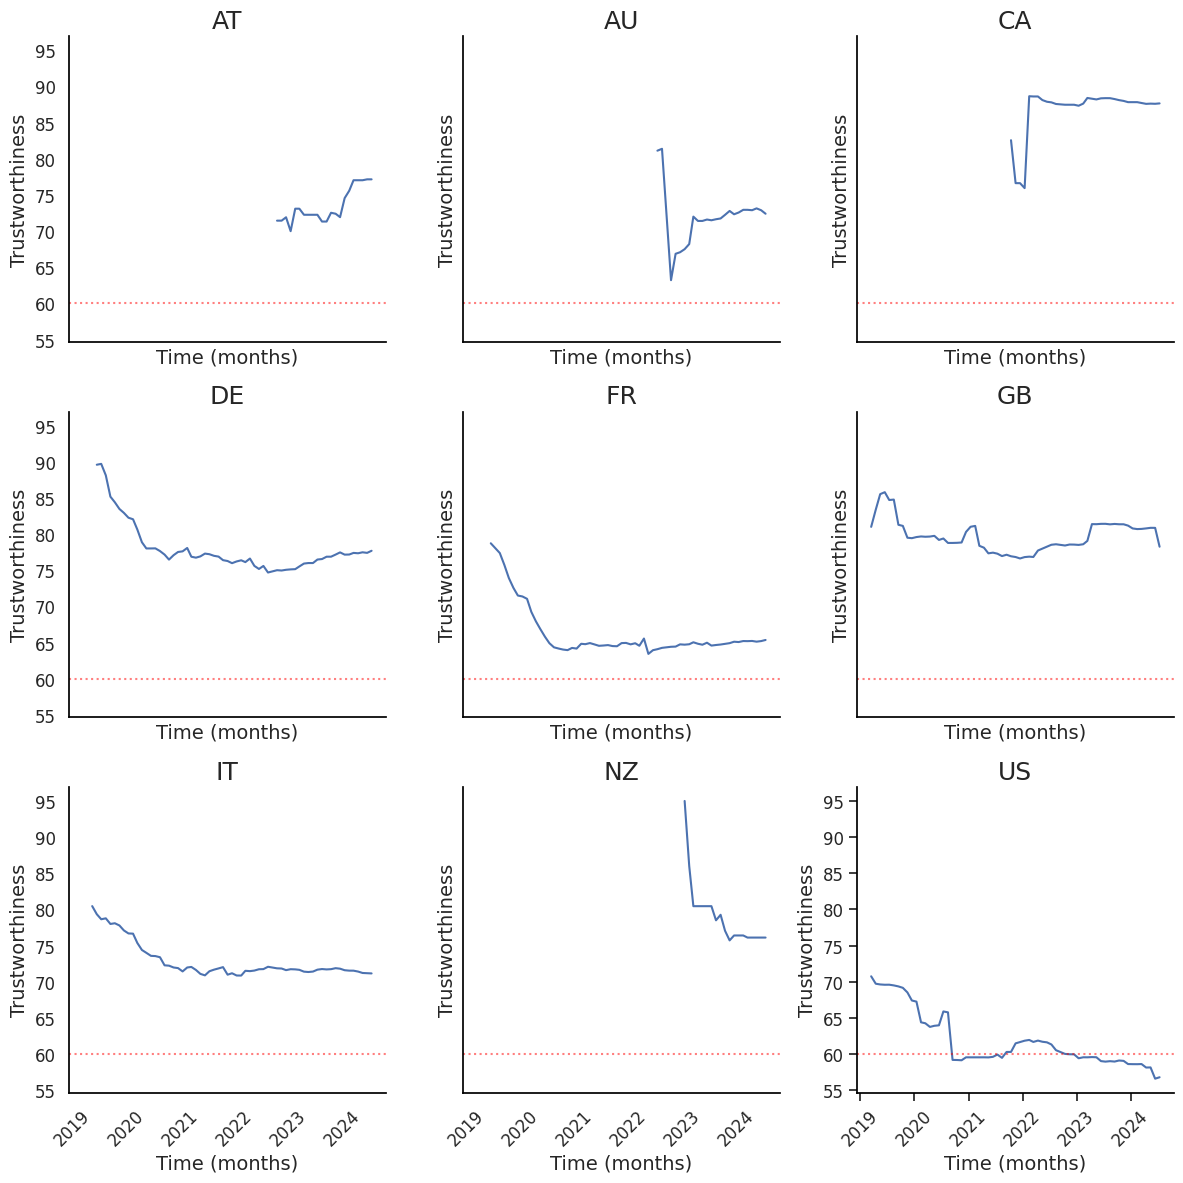

In [132]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.7, wspace=0.7)

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score_time[country_score_time["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time (months)", fontsize=14)
    axs[row, col_in_row].set_ylabel("Trustworthiness", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()
plt.savefig(join(figures_path,"scores_per_country_over_time.png"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.savefig(join(figures_path,"scores_per_country_over_time.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

### Updates

In [133]:
updated_df_15.head(3)

Domain        Parent Domain Country Language           file_date  \
19  100fedup.com  100percentfedup.com      US       en 2019-10-15 01:00:00   
22  100fedup.com  100percentfedup.com      US       en 2020-01-15 01:00:00   
24  100fedup.com  100percentfedup.com      US       en 2020-03-15 01:00:00   

              Last Updated  Score Does not repeatedly publish false content  \
19 2019-10-04 23:22:52.632    7.5                                        No   
22 2019-12-27 19:08:32.749    7.5                                        No   
24 2020-02-28 19:59:19.811   44.5                                       Yes   

   Does not repeatedly publish false or egregiously misleading content  \
19                                                                 NaN   
22                                                                 NaN   
24                                                                 NaN   

   Gathers and presents information responsibly  ...  \
19                                           No  ...   
22                                           No  ...   
24                                           No  ...   

   Handles the difference between news and opinion responsibly  \
19                                                          No   
22                                                          No   
24                                                          No   

   Avoids deceptive headlines Website discloses ownership and financing  \
19                         No                                        No   
22                         No                                        No   
24                        Yes                                        No   

   Clearly labels advertising  \
19                        Yes   
22                        Yes   
24                         No   

   Reveals who's in charge, including any possible conflicts of interest  \
19                                                                    No   
22                                                                    No   
24                                                                    No   

   The site provides names of content creators, along with either contact or biographical information  \
19                                                                                                 No   
22                                                                                                 No   
24                                                                                                 No   

   Score_diff             Updated_diff  Added Updated  
19        0.0 391 days 00:56:19.427000  False    True  
22        0.0  83 days 19:45:40.117000  False    True  
24       37.0  63 days 00:50:47.062000  False    True  

[3 rows x 22 columns]

In [134]:
#take average per domain
updated_country = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()

#average per country
time_diff_country = updated_country\
    .groupby("Country")["Updated_diff"]\
    .mean()\
    .reset_index()

#turn into day format
time_diff_country["Updated"] = \
    time_diff_country["Updated_diff"].dt.days

In [135]:
changed_country = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

#changed_country per country
actual_time_diff = changed_country\
    .groupby("Country")["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

#turn into day format and keep "days"
actual_time_diff["Changed"] = \
    actual_time_diff["Actual_Updated_diff"].dt.days

In [136]:
score_diff_per_domain = updated_df_15\
                                    .groupby(["Country", "Domain", "Language"])["Score_diff"]\
                                    .mean()\
                                    .reset_index()

score_diff_per_domain.groupby("Country")["Score_diff"]\
                        .mean()\
                        .reset_index()

Country  Score_diff
0     ALL    0.511158
1      AT    3.057796
2      AU   -0.321895
3      CA    0.864025
4      DE    0.865169
5      FR    0.486762
6      GB   -0.458880
7      IT    0.249471
8      NZ   -2.857143
9      US   -0.068928

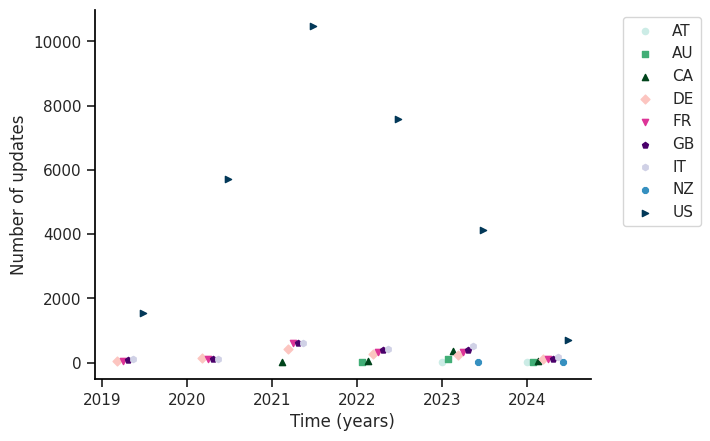

In [137]:
updated_df_15["file_year"] = updated_df_15["file_date"].dt.year

unique_updates = updated_df_15\
                    .groupby(["Country", "file_year"])["Last Updated"]\
                    .nunique()\
                    .reset_index()
unique_updates.columns = ["Country", "Year", "Update intervals"]
unique_updates["Year"] = unique_updates["Year"]\
                            .astype(str)

#remove ALL
unique_updates = unique_updates[unique_updates["Country"] != "ALL"]
unique_updates["Year"] = pd.to_numeric(
                                unique_updates["Year"], 
                                errors="coerce")

dodge = 0.06

for i, country in enumerate(unique_updates["Country"].unique()):
    country_df = unique_updates[\
                    unique_updates["Country"] == country]
    plt.scatter(
            country_df["Year"] + i * dodge, 
            country_df["Update intervals"], 
            label=country, 
            marker=country_markers[i % len(country_markers)],  
            color=country_palette[i % len(country_palette)],
            s=20)
plt.xlabel("Time (years)")
plt.ylabel("Number of updates")
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc="upper left")
custom_plots()
plt.show()

In [138]:
#merge time_diff_per_country with country_means
country_means_diff = country_means\
                    .merge(time_diff_country.filter(["Country", "Updated"]), 
                           on="Country")

country_means_diff = country_means_diff\
                       .merge(actual_time_diff.filter(["Country", "Changed"]), 
                               on="Country")

#rename columns 
country_means_diff = country_means_diff\
                    .rename(columns={"Updated_diff": "Updated", 
                                     "Actual_Updated_diff": "Changed"})
country_means_diff

Country       n (\%) Trustworthiness (SD)  Updated  Changed
0      US  6421 (65.4)          59.2 (33.6)      224      554
1     ALL  1173 (11.9)          75.1 (25.0)      308      645
2      GB    499 (5.1)          80.9 (20.7)      224      472
3      IT    467 (4.8)          74.0 (20.9)      289      656
4      CA    440 (4.5)          88.3 (14.4)      305      427
5      FR    314 (3.2)          70.9 (25.7)      320      632
6      DE    309 (3.1)          80.1 (29.1)      307      666
7      AU    141 (1.4)          74.1 (22.6)      331      358
8      AT     40 (0.4)          77.2 (29.6)      338      375
9      NZ     19 (0.2)          79.7 (21.2)      278      292

In [139]:
populations = {"AT": 9132380, 
               "AU": 26638540,
                "CA": 40097760,
                 "DE": 84482270,
                  "FR": 68170230,
                  "GB": 68350000,
                  "IT": 58761150,
                  "NZ": 5223100,
                  "US": 334914900
}

country_pops = pd.DataFrame(list(populations.items()),
                            columns=["Country", "Population"])

countries_size = df_recent\
    .groupby("Country")\
    .size()\
    .reset_index(name="N")

countries_size_standardized = \
    countries_size\
        .merge(country_pops)

#order by Population
countries_size_standardized = \
    countries_size_standardized\
        .sort_values("Population", ascending=False)

#round to millions
countries_size_standardized["Population_in_millions"] = \
    countries_size_standardized["Population"] / 1_000_000


#standardize by population
countries_size_standardized["N_per_capita"] = \
    countries_size_standardized["N"] / countries_size_standardized["Population_in_millions"]

countries_size_standardized

Country     N  Population  Population_in_millions  N_per_capita
8      US  6421   334914900               334.91490     19.172034
3      DE   309    84482270                84.48227      3.657572
5      GB   499    68350000                68.35000      7.300658
4      FR   314    68170230                68.17023      4.606116
6      IT   467    58761150                58.76115      7.947428
2      CA   440    40097760                40.09776     10.973182
1      AU   141    26638540                26.63854      5.293083
0      AT    40     9132380                 9.13238      4.380019
7      NZ    19     5223100                 5.22310      3.637686

In [140]:
#add "days" as string to Updated and Changed columns
country_means_diff["Updated"] = \
    country_means_diff["Updated"].astype(str) + " days"

country_means_diff["Changed"] = \
    country_means_diff["Changed"].astype(str) + " days"

country_means_latex = country_means_diff\
    .to_latex(
        index=False, 
        escape=False,
        caption="Country descriptives.",
        label="table:countries", 
        position='H',
        column_format=' X c c c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

country_means_latex = \
    country_means_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")

country_means_latex = \
    country_means_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

country_means_latex = \
    country_means_latex \
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of July 15th, 2024. Sorted by size.}"
                 )

with open(join(tables_path, "countries.tex"), 'w') as f:
    f.write(country_means_latex)

In [141]:
#per country i want to see the number of sources that have 1 in a criterion
df_recent = df_recent\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_country_sum = df_recent\
    .groupby("Country")\
    [criteria_recent_list]\
    .sum()\
    .reset_index()

sources_country_count = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

criteria_country_sum = \
    criteria_country_sum\
        .merge(sources_country_count, 
               on="Country")

/tmp/ipykernel_4191584/2588792903.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1,


In [142]:
#make table with percentages
criteria_country_perc = criteria_country_sum.copy()

for col in criteria_recent_list:
    criteria_country_perc[col] = \
        round(criteria_country_perc[col] / criteria_country_perc["Total"] * 100, 1)

criteria_country_perc\
    .drop(columns="Total", 
          inplace=True)

criteria_country_perc\
    .set_index("Country", inplace=True)

criteria_country = \
    criteria_country_perc\
        .transpose()\
            .reset_index()

criteria_country\
    .rename(columns={"index": "Criteria"}, 
            inplace=True)

criteria_weights = [22, 18, 12.5, 12.5, 10, 7.5, 7.5, 5, 5]

criteria_weights_df = pd.DataFrame({
    "Criteria": criteria_recent_list,
    "Weight": criteria_weights
})

criteria_country = criteria_country\
    .merge(criteria_weights_df, 
           on="Criteria")

criteria_country["Criteria"] = \
    criteria_country["Criteria"] + " (" + \
    criteria_country["Weight"].astype(str) + ")"

#drop weight
criteria_country = criteria_country\
    .drop(columns="Weight")

def insert_line_breaks(text, n=6):
    words = text.split()
    lines = [" ".join(words[i:i+n]) for i in range(0, len(words), n)]
    return " \\\\ ".join(lines)

criteria_country["Criteria"] = criteria_country["Criteria"].apply(insert_line_breaks)

criteria_country

Criteria  \
0                                   Does not repeatedly publish false or \\ egregiously misleading content (22.0)   
1                                                             Gathers and presents information responsibly (18.0)   
2                                                         Has effective practices for correcting errors \\ (12.5)   
3                                           Handles the difference between news and \\ opinion responsibly (12.5)   
4                                                                               Avoids deceptive headlines (10.0)   
5                                                                 Website discloses ownership and financing (7.5)   
6                                                                                Clearly labels advertising (7.5)   
7                                  Reveals who's in charge, including any \\ possible conflicts of interest (5.0)   
8  The site provides names of content \\ creators, along with either contact or \\ biographical information (5.0)   

    ALL    AT    AU    CA    DE    FR    GB    IT     NZ    US  
0  88.7  87.5  91.5  98.0  84.5  86.9  97.2  91.9   89.5  82.9  
1  80.2  80.0  86.5  95.0  79.0  72.9  84.8  84.6   89.5  52.1  
2  36.4  57.5  35.5  81.6  67.3  31.8  29.1  17.3   57.9  36.9  
3  81.8  77.5  81.6  96.4  83.5  79.6  85.6  80.9   94.7  57.4  
4  88.9  87.5  90.8  98.2  84.8  87.3  97.0  92.1  100.0  81.7  
5  68.5  72.5  58.2  53.0  74.8  59.9  77.4  70.9   57.9  35.3  
6  84.2  97.5  58.2  93.0  93.2  75.5  88.0  86.1   84.2  53.8  
7  83.1  72.5  56.7  64.1  90.6  82.2  80.8  82.4   47.4  51.5  
8  37.0  30.0  62.4  69.8  57.6  34.7  76.4  24.0   36.8  48.0

In [143]:
criteria_country_latex = criteria_country\
    .to_latex(
        index=False, 
        escape=False,
        caption="Criteria per country.",
        label="tab:criteria_country", 
        position='H',
        column_format=' l X X X X X X X X X X ',
        longtable=False,
        header=True,
        na_rep='---',
        bold_rows=True)

criteria_country_latex = \
    criteria_country_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
criteria_country_latex = \
    criteria_country_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

criteria_country_latex = \
    criteria_country_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of July 15th, 2024. Weights in brackets.}"
                 )

with open(join(tables_path, "criteria_country.tex"), 'w') as f:
    f.write(criteria_country_latex)

In [144]:
#make table with percentages
#copy the dataframe
criteria_country_miss = criteria_country_sum.copy()
#drop ALL
criteria_country_miss = criteria_country_miss[
    criteria_country_miss["Country"] != "ALL"]

for col in criteria_recent_list:
    criteria_country_miss[col] = \
        criteria_country_miss["Total"] - criteria_country_miss[col] 
    
for col in criteria_recent_list:
    criteria_country_miss[col] = \
        round(criteria_country_miss[col] / criteria_country_miss["Total"] * 100, 1)

criteria_country_miss\
    .drop(columns="Total", 
          inplace=True)

#set country as index
criteria_country_miss\
    .set_index("Country", inplace=True)

#replace column names with list
criteria_country_miss\
    .columns = criteria_recent_list_numbers


criteria_country_miss = criteria_country_miss\
    .reset_index()\
    .melt(id_vars="Country", 
          value_vars=criteria_recent_list_numbers, 
          var_name="Criteria", 
          value_name="Percentage")

criteria_country_miss["Criteria_num"] = \
    criteria_country_miss["Criteria"].str.extract("(\d+)")

criteria_country_miss

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_4191584/1181985079.py:37: SyntaxWarning: invalid escape sequence '\d'
  criteria_country_miss["Criteria"].str.extract("(\d+)")


Country  \
0       AT   
1       AU   
2       CA   
3       DE   
4       FR   
..     ...   
76      FR   
77      GB   
78      IT   
79      NZ   
80      US   

                                                                                                  Criteria  \
0                                  1 - Does not repeatedly publish false or egregiously misleading content   
1                                  1 - Does not repeatedly publish false or egregiously misleading content   
2                                  1 - Does not repeatedly publish false or egregiously misleading content   
3                                  1 - Does not repeatedly publish false or egregiously misleading content   
4                                  1 - Does not repeatedly publish false or egregiously misleading content   
..                                                                                                     ...   
76  9 - The site provides names of content creators, along with either contact or biographical information   
77  9 - The site provides names of content creators, along with either contact or biographical information   
78  9 - The site provides names of content creators, along with either contact or biographical information   
79  9 - The site provides names of content creators, along with either contact or biographical information   
80  9 - The site provides names of content creators, along with either contact or biographical information   

    Percentage Criteria_num  
0         12.5            1  
1          8.5            1  
2          2.0            1  
3         15.5            1  
4         13.1            1  
..         ...          ...  
76        65.3            9  
77        23.6            9  
78        76.0            9  
79        63.2            9  
80        52.0            9  

[81 rows x 4 columns]

In [145]:
criteria_country_miss.sort_values(by="Country", ascending=False).head(9)

Country  \
80      US   
44      US   
35      US   
53      US   
8       US   
26      US   
71      US   
62      US   
17      US   

                                                                                                  Criteria  \
80  9 - The site provides names of content creators, along with either contact or biographical information   
44                                                                          5 - Avoids deceptive headlines   
35                                         4 - Handles the difference between news and opinion responsibly   
53                                                           6 - Website discloses ownership and financing   
8                                  1 - Does not repeatedly publish false or egregiously misleading content   
26                                                       3 - Has effective practices for correcting errors   
71                               8 - Reveals who's in charge, including any possible conflicts of interest   
62                                                                          7 - Clearly labels advertising   
17                                                        2 - Gathers and presents information responsibly   

    Percentage Criteria_num  
80        52.0            9  
44        18.3            5  
35        42.6            4  
53        64.7            6  
8         17.1            1  
26        63.1            3  
71        48.5            8  
62        46.2            7  
17        47.9            2

## Overlap with other lists

In [146]:
gond = pd.read_csv("../GONDv1_domains.csv")
print(gond["domain"].nunique())

1147


In [147]:
gond["type"]\
    .value_counts(
        normalize=False)

type
legacy press                561
digital-born news outlet    206
commercial broadcaster      116
hyperpartisan news           94
public broadcaster           92
tabloid newspaper            78
Name: count, dtype: int64

In [148]:
df15_unique = \
    df_15\
    .drop_duplicates(
        subset="Domain", 
        keep="first")

gond_unqiue = \
    gond\
    .drop_duplicates(
        subset="domain", 
        keep="first")

overlap = pd.merge(gond_unqiue, df15_unique, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")

len(overlap)

552

In [149]:
#keep only the columns of interest
overlap_interest = \
    overlap[["domain", "type", "language", 
             "Domain", "Country", "Language", "Score", "Rating"]]

#rename into Type
overlap_interest["GOND Type"] = overlap_interest["type"] 
overlap_interest = overlap_interest.drop(columns="type")

In [150]:
overlap_type_score = \
    overlap_interest\
        .groupby("GOND Type")\
        ["Score"]\
        .mean()\
        .round(1)\
        .reset_index(name="NewsGuard Score")

overlap_type_n = \
    overlap_interest\
        .groupby("GOND Type")\
        .size()\
        .reset_index(name="Overlap")

overlap_type_perc = overlap_interest["GOND Type"]\
    .value_counts(normalize=True)\
    .mul(100)\
    .round(1)\
    .reset_index()

overlap_type_sum = \
    overlap_type_score\
        .merge(overlap_type_n,
                on="GOND Type")\
        .merge(overlap_type_perc,
                on="GOND Type")

#rename column to percentage
overlap_type_sum = overlap_type_sum\
    .rename(columns={"proportion": "\%"})
                     
overlap_type_sum

<>:30: SyntaxWarning: invalid escape sequence '\%'
<>:30: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4191584/2287689945.py:30: SyntaxWarning: invalid escape sequence '\%'
  .rename(columns={"proportion": "\%"})


GOND Type  NewsGuard Score  Overlap    \%
0    commercial broadcaster             89.4       58  10.5
1  digital-born news outlet             84.5       66  12.0
2        hyperpartisan news             43.0       56  10.1
3              legacy press             91.0      292  52.9
4        public broadcaster             89.0       40   7.2
5         tabloid newspaper             84.6       40   7.2

In [151]:
#save as latex table
overlap_type_sum_latex = overlap_type_sum\
    .to_latex(
        index=False, 
        escape=False,
        caption="Overlap between GOND and NewsGuard.",
        label="tab:overlap_lists", 
        position='H',
        column_format=' X c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

overlap_type_sum_latex = \
    overlap_type_sum_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
overlap_type_sum_latex = \
    overlap_type_sum_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

overlap_type_sum_latex = \
    overlap_type_sum_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of July 15th, 2024.}"
                 )

with open(join(tables_path, "overlap_lists.tex"), 'w') as f:
    f.write(overlap_type_sum_latex)

In [152]:
gond_de = (gond[gond["language"] == "de"]
           .drop_duplicates(
               subset="domain", 
               keep="first")
)
len(gond_de)

573

In [153]:
#overlap between gond and newsguard
df15_de = (df_15[df_15["Language"] == "de"]
           .drop_duplicates(
               subset="Domain", 
               keep="first")
)
overlap_de = pd.merge(gond_de, df15_de, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")
len(overlap_de)

244

In [154]:
overlap_de_type = overlap_de\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")

overlap_de_type

type  Count
0    commercial broadcaster      4
1  digital-born news outlet     20
2        hyperpartisan news     24
3              legacy press    163
4        public broadcaster     18
5         tabloid newspaper     15

In [155]:
#per type of source, what is the overlap?
overlap\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")


type  Count
0    commercial broadcaster     58
1  digital-born news outlet     66
2        hyperpartisan news     56
3              legacy press    292
4        public broadcaster     40
5         tabloid newspaper     40

In [156]:
#what are the sources in NG that dont overlap?
df15_de_unique = df15_de[~df15_de["Domain"].isin(gond_de["domain"])]
#df15_de_unique["Domain"].to_list()

In [157]:
gond_de_unique = gond_de[~gond_de["domain"].isin(df15_de["Domain"])]
#gond_de_unique["domain"].to_list()

## Political Orientation

In [158]:
print(f'In the most recent database, '
      f'{df_recent["Orientation"].isnull().sum()} '
      'have no rating for orientation.\n'
      f'Out of {len(df_recent)} rows, '
      f'{df_recent["Orientation"].notnull().sum()} have a rating.\n'
      f'This is {round(df_recent["Orientation"].notnull().sum()/df_recent["Score"].notnull().sum()*100,2)}% '
      'of all ratings.')

In the most recent database, 6762 have no rating for orientation.
Out of 9823 rows, 3061 have a rating.
This is 31.16% of all ratings.


In [159]:
total_per_country = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

orientation_count = \
    df_recent[df_recent["Orientation"].notnull()]\
        .groupby("Country")\
        .size()\
        .reset_index(name="Count")

country_counts = \
    total_per_country\
        .merge(orientation_count, 
               on="Country", 
               how="left")

country_counts["Percentage"] = \
    round((country_counts["Count"] / country_counts["Total"]) * 100,2)

country_counts

Country  Total  Count  Percentage
0     ALL   1173    151       12.87
1      AT     40     11       27.50
2      AU    141     21       14.89
3      CA    440     13        2.95
4      DE    309     50       16.18
5      FR    314     42       13.38
6      GB    499     44        8.82
7      IT    467     51       10.92
8      NZ     19      3       15.79
9      US   6421   2675       41.66

In [160]:
#count orientation per country
orientation_countries = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .value_counts()\
        .unstack(fill_value=1)

#add number of orientation ratings per country
orientation_countries["Total"] = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .count()
        
orientation_countries["% right"] = \
    (orientation_countries["Right"]/orientation_countries["Total"]*100)\
        .round(2)


orientation_countries["Right"] = \
    orientation_countries["Right"].astype(str) + \
    " (" + orientation_countries["% right"].astype(str) + ")"

orientation_countries["% left"] = \
    (orientation_countries["Left"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Left"] = \
    orientation_countries["Left"].astype(str) + \
    " (" + orientation_countries["% left"].astype(str) + ")"

#drop columns
orientation_countries = \
    orientation_countries\
        .drop(["% right", "% left"], axis=1)\
        .rename(columns={"Left":"Left (%)", "Right":"Right (%)"})

#sort by Total
orientation_countries = \
    orientation_countries\
        .sort_values(by="Total", ascending=False)
orientation_countries

Orientation     Left (%)     Right (%)  Total
Country                                      
US           323 (12.07)  2352 (87.93)   2675
ALL            37 (24.5)    114 (75.5)    151
IT            11 (21.57)    40 (78.43)     51
DE              9 (18.0)     41 (82.0)     50
GB            21 (47.73)    23 (52.27)     44
FR             16 (38.1)     26 (61.9)     42
AU              8 (38.1)     13 (61.9)     21
CA             4 (30.77)     9 (69.23)     13
AT             2 (18.18)     9 (81.82)     11
NZ             1 (33.33)     2 (66.67)      3

In [161]:
#latex table
orientation_countries_latex = \
    orientation_countries\
        .to_latex(index=True, 
                  escape=False,
                  caption="\\textbf{Orientation per country.}",
                  label="tab:orientation_countries", 
                  position='H',
                  column_format=' X c c c',
                  longtable=False, 
                  header=True, 
                  na_rep='---', 
                  bold_rows=True)

orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\begin{tabular}{", 
                 "\\begin{tabularx}{\\textwidth}{")
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\end{tabular}", 
                 "\\end{tabularx}")

orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n"
                 "\\multicolumn{5}{l}{\\textit{Note.} As of July 15h, 2024.}")

#replace all % with \%
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("%", "\%")

with open(join(tables_path, 
               "orientation_countries.tex"), 
               'w') as f:
    f.write(orientation_countries_latex)

<>:33: SyntaxWarning: invalid escape sequence '\%'
<>:33: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4191584/1237587586.py:33: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%")


In [162]:
df_recent\
    .groupby("Orientation")["Score"]\
    .describe()

count       mean        std  min   25%   50%   75%    max
Orientation                                                            
Left          432.0  60.927083  23.248304  7.5  39.5  58.5  80.0  100.0
Right        2629.0  26.341004  19.796093  0.0   5.0  32.0  32.0  100.0

In [163]:
ttest_recent = \
    stats\
        .ttest_ind(
            df_recent[df_recent["Orientation"] == "Left"]["Score"], 
            df_recent[df_recent["Orientation"] == "Right"]["Score"],
            nan_policy="omit")

ttest_recent

TtestResult(statistic=32.788785511546, pvalue=2.452259438935867e-202, df=3059.0)

### Rating change

In [164]:
orientation_palette = {"Far Left": "#4393c3", 
                       "Slightly Left": "#92c5de",
                       "Slightly Right": "#f4a582",
                       "Far Right": "#d6604d", 
                       "Left": "#2166ac", 
                       "Right": "#b2182b"}

orientation_order = ["Far Left", "Slightly Left", 
                     "Slightly Right", "Far Right", 
                     "Left", "Right"]

In [165]:
orientation_count = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_count = orientation_count\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Far Left", "Far Right", "Left", "Right", "Slightly Left", "Slightly Right"], 
          var_name="Orientation", 
          value_name="Count")

orientation_count = orientation_count[orientation_count["Country"] != "ALL"]

In [166]:
orientation_year = orientation_count\
    .groupby(["Country", "file_year", "file_month", "Orientation"])["Count"]\
    .agg("mean")\
    .reset_index()

unique_years = sorted(orientation_year["file_year"].unique())

orientation_year["Orientation"] = pd.Categorical(orientation_year["Orientation"], 
                                       categories=orientation_order, 
                                       ordered=True)

df_15["Orientation"] = \
    pd.Categorical(df_15["Orientation"], 
                   categories=orientation_order, 
                   ordered=True)

In [167]:
#copy the orientation column
df_15["Orientation_before"] = df_15["Orientation"].astype(str)
df_15["Orientation_after"] = df_15["Orientation"].astype(str)

#recode Left and Right in Orientation to NaN
df_15["Orientation_before"] = \
    df_15["Orientation_before"]\
        .replace({"Left": np.nan, 
                  "Right": np.nan})

df_15["Orientation_after"] = \
    df_15["Orientation_after"]\
        .replace({"Far Left": np.nan,
                  "Slightly Left": np.nan,
                  "Far Right": np.nan,
                  "Slightly Right": np.nan})

orientation_counts = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])[["Orientation_before", "Orientation_after"]]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_counts = orientation_counts[orientation_counts["Country"] != "ALL"]
orientation_counts

Orientation_after Country file_month file_year Orientation_before   nan
62                     AT    2022-10      2022                nan    19
63                     AT    2022-11      2022                nan    19
64                     AT    2022-12      2022                nan    20
65                     AT    2023-01      2023                nan    20
66                     AT    2023-02      2023                nan    24
..                    ...        ...       ...                ...   ...
467                    US    2024-03      2024                nan  4806
468                    US    2024-04      2024                nan  4914
469                    US    2024-05      2024                nan  4924
470                    US    2024-06      2024                nan  4959
471                    US    2024-07      2024                nan  4972

[410 rows x 5 columns]

In [168]:
orientation_before = df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation_before"] \
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_before = \
    orientation_before \
        .melt(id_vars=["Country", "file_month", "file_year"], 
            value_vars=["Far Left", "Far Right", "Slightly Left", "Slightly Right"], 
            var_name="Orientation_before", 
            value_name="Count_before")

orientation_before = orientation_before[orientation_before["Country"] != "ALL"]

orientation_year_before = orientation_before\
    .groupby(["Country", "file_year", "Orientation_before"])["Count_before"]\
    .agg("mean")\
    .reset_index()

orientation_year_before

Country file_year Orientation_before  Count_before
0        AT      2022           Far Left      0.000000
1        AT      2022          Far Right      2.000000
2        AT      2022      Slightly Left      1.333333
3        AT      2022     Slightly Right      0.666667
4        AT      2023           Far Left      0.000000
..      ...       ...                ...           ...
163      US      2023     Slightly Right      0.000000
164      US      2024           Far Left      0.000000
165      US      2024          Far Right      0.000000
166      US      2024      Slightly Left      0.000000
167      US      2024     Slightly Right      0.000000

[168 rows x 4 columns]

In [169]:
orientation_after = \
    df_15\
        .groupby(["Country", "file_month", "file_year"])["Orientation_after"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_after = \
 orientation_after\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Left", "Right"], 
          var_name="Orientation_after", 
          value_name="Count_after")

orientation_after = orientation_after[orientation_after["Country"] != "ALL"]

#calculate average per year
orientation_year_after = orientation_after\
    .groupby(["Country", "file_year", "Orientation_after"])["Count_after"]\
    .agg("mean")\
    .reset_index()

orientation_year_after

Country file_year Orientation_after  Count_after
0       AT      2022              Left     0.666667
1       AT      2022             Right     1.666667
2       AT      2023              Left     2.583333
3       AT      2023             Right     7.333333
4       AT      2024              Left     2.000000
..     ...       ...               ...          ...
79      US      2022             Right   220.909091
80      US      2023              Left   369.416667
81      US      2023             Right  2441.333333
82      US      2024              Left   393.285714
83      US      2024             Right  2555.285714

[84 rows x 4 columns]

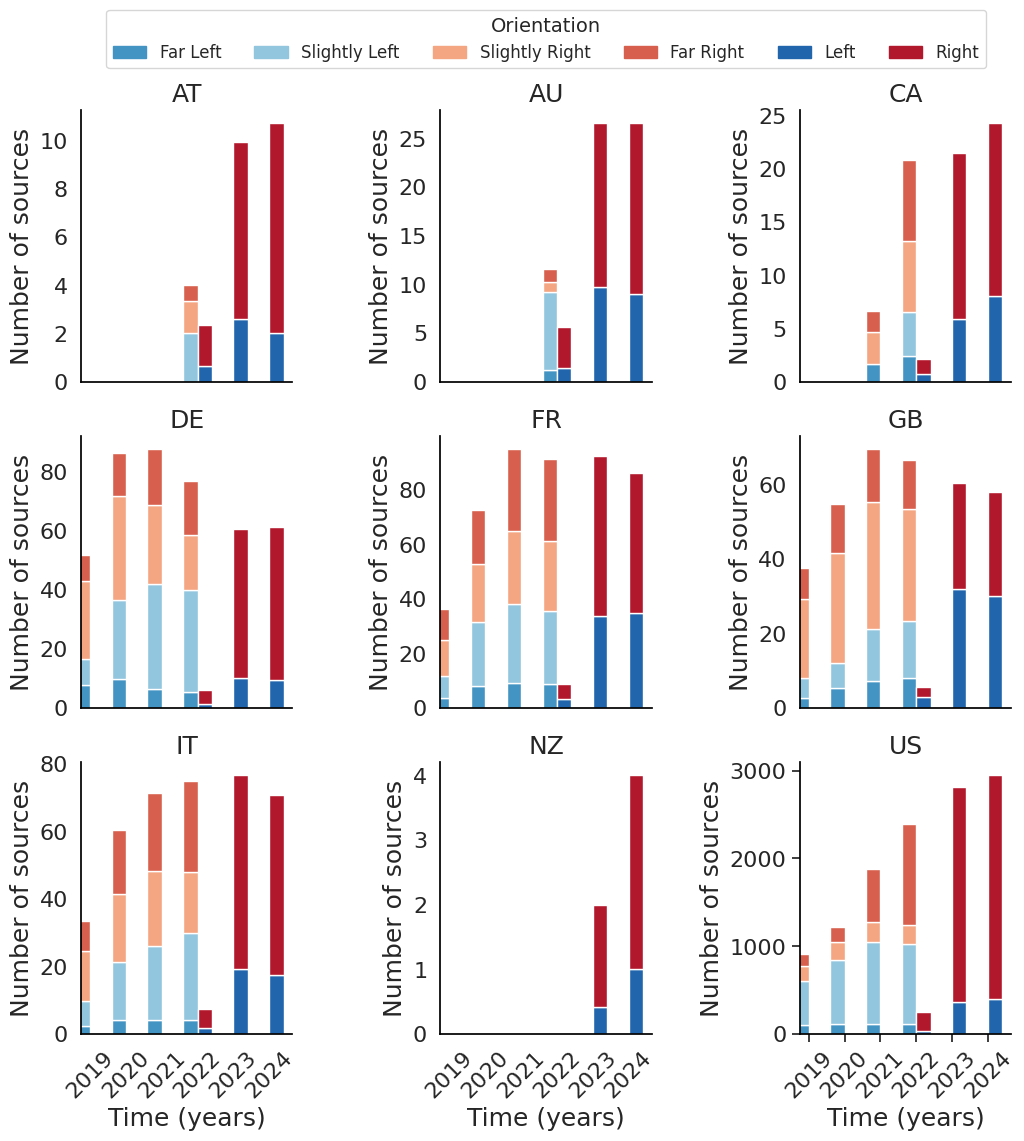

In [170]:
#plot with two variables on the y-axis
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.2, 
                    wspace=0.7)

orientation_palette_before = {
                        "Far Left": "#4393c3", 
                        "Slightly Left": "#92c5de",
                        "Slightly Right": "#f4a582",
                        "Far Right": "#d6604d"}
 
orientation_palette_after = {"Left": "#2166ac",
                             "Right": "#b2182b"}


unique_years = sorted(orientation_year_after["file_year"].unique())

for i, country in enumerate(orientation_year_before["Country"].unique()):
    row = i // 3
    col_in_row = i % 3

    orientation_year_country_before = orientation_year_before[orientation_year_before["Country"] == country]
    orientation_counts_before = orientation_year_country_before.pivot(index="file_year",
                                                                      columns="Orientation_before",
                                                                      values="Count_before")
    orientation_counts_before = orientation_counts_before.reindex(unique_years, fill_value=0)
    orientation_counts_before.plot(kind="bar",
                                   stacked=True,
                                   ax=axs[row, col_in_row],
                                   width=0.4,
                                   position=1,
                                   legend=False,
                                   color=orientation_palette_before.values())


    orientation_year_country_after = orientation_year_after[orientation_year_after["Country"] == country]
    orientation_counts_after = orientation_year_country_after.pivot(index="file_year",
                                                                    columns="Orientation_after",
                                                                    values="Count_after")
    orientation_counts_after = orientation_counts_after.reindex(unique_years, fill_value=0)
    orientation_counts_after.plot(kind="bar",
                                  stacked=True,
                                  ax=axs[row, col_in_row],
                                  width=0.4,
                                  position=0,
                                  legend=False,
                                  color=orientation_palette_after.values())

    axs[row, col_in_row].set_xlabel("Time (years)", fontsize=18)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=18)
    axs[row, col_in_row].set_title(f"{country}", fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=16, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=16)
    custom_plots(ax=axs[row, col_in_row])

# add shared legend
handles = [mpatches.Patch(color=color, label=label) 
           for label, color in orientation_palette_before.items()]
handles += [mpatches.Patch(color=color, label=label) 
            for label, color in orientation_palette_after.items()]

axs[2, 2].legend(handles=handles, 
                 title="Orientation", 
                 loc="upper center", 
                 bbox_to_anchor=(-1.2, 3.8), 
                 ncol=6, 
                 title_fontsize=14,
                 fontsize=12)

plt.savefig(join(figures_path, "orientation_over_time_per_country_before_after.png"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)


plt.savefig(join(figures_path, "orientation_over_time_per_country_before_after.pdf"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

### Collapsed

In [171]:
for df in [df_15, df_15_UUID]:
    df["Orientation_binary"] = df["Orientation"]\
        .replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

left_right_count = df_15["Orientation_binary"]\
    .value_counts()\
    .reset_index()

left_right_count["%"] = \
    ((left_right_count["count"] / left_right_count["count"].sum()) * 100) \
        .round(2)

left_right_count

/tmp/ipykernel_4191584/2857354873.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace(


Orientation_binary   count      %
0              Right  128208  78.87
1               Left   34356  21.13

In [172]:
domains_changed = df_15[["Domain", "file_month", "Orientation"]]\
    .groupby("Domain").filter(lambda x: x["Orientation"].nunique() > 1)

#now keep only specific timeframe in file_date
domains_changed = domains_changed[(domains_changed['file_month'] == "2022-11") | (domains_changed['file_month'] == "2022-12")]
#drop duplicated rows
domains_changed = domains_changed.drop_duplicates(subset=["Domain", "file_month"], keep="first")
domains_changed= domains_changed.sort_values(["Domain", "file_month"])

#drop file_month
domains_changed = domains_changed.drop(columns="file_month")

In [173]:
score_x_orientation_time = df_15\
    .groupby(["file_month", "Orientation"])["Score"]\
    .agg(["mean", "std"])

/tmp/ipykernel_4191584/2783828930.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["file_month", "Orientation"])["Score"]\


In [174]:
score_x_orientation_time_bi = df_15\
    .groupby(["file_month", "Orientation_binary"])["Score"]\
    .agg(["mean", "std"])\
    .reset_index()

/tmp/ipykernel_4191584/1252991259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["file_month", "Orientation_binary"])["Score"]\


In [175]:
score_x_orientation_time\
    .loc["2021-06":"2021-09"]

mean        std
file_month Orientation                         
2021-06    Far Left        54.022876  27.760272
           Slightly Left   81.323821  18.353697
           Slightly Right  59.407563  30.834733
           Far Right       15.903256  20.758654
           Left                  NaN        NaN
           Right                 NaN        NaN
2021-07    Far Left        54.123377  27.659420
           Slightly Left   81.230488  18.446345
           Slightly Right  59.368493  30.881606
           Far Right       15.826350  20.701533
           Left                  NaN        NaN
           Right                 NaN        NaN
2021-08    Far Left        54.353896  27.642733
           Slightly Left   81.118644  18.406131
           Slightly Right  39.556597  20.297690
           Far Right       15.164336  19.691632
           Left                  NaN        NaN
           Right                 NaN        NaN
2021-09    Far Left        54.280255  27.406036
           Slightly Left   81.129187  18.341029
           Slightly Right  39.621178  20.341379
           Far Right       15.069056  19.627659
           Left                  NaN        NaN
           Right                 NaN        NaN

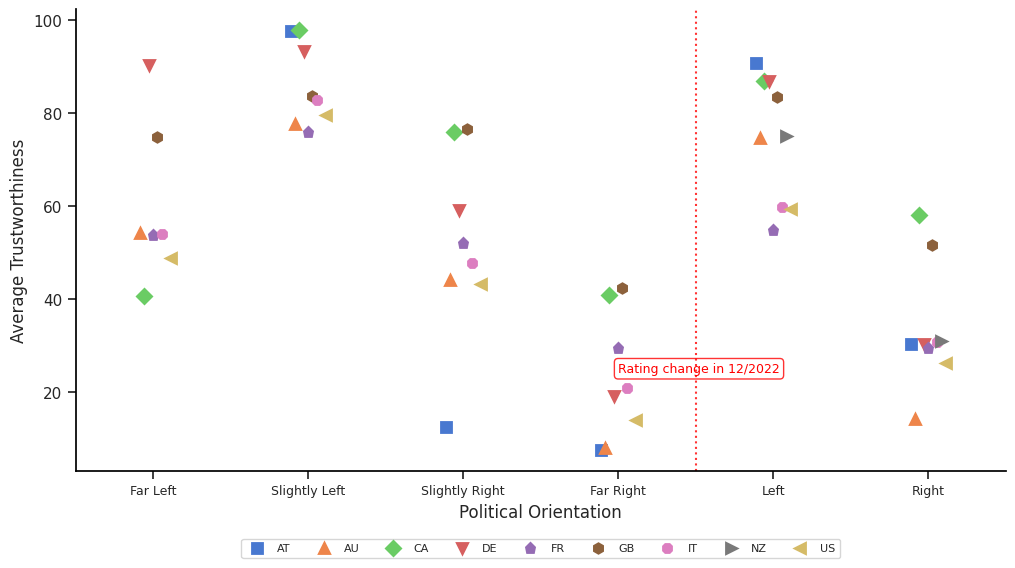

In [176]:
plt.figure(figsize=(12, 6))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Orientation", y="Score", 
               hue="Country", 
               data=df_15_ALL,
               markers=country_markers,
               order=["Far Left", "Slightly Left", 
                      "Slightly Right", "Far Right", 
                      "Left", "Right"],
               hue_order=sorted(df_15[df_15["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               linestyle="none")

plt.axvline(x=3.5,
            color="red", 
            linestyle="dotted", 
            alpha=0.8)
plt.xlabel("Political Orientation")
plt.xticks(fontsize=9)
plt.ylabel("Average Trustworthiness")

#add a text box to line
plt.text(3, 25, "Rating change in 12/2022", 
         fontsize=9, 
         color="red",
         verticalalignment="center", 
         bbox=dict(facecolor="none", edgecolor="red",
                   boxstyle="round,pad=0.3",
                   alpha=0.8))

#legend below
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=9, fontsize=8)

custom_plots()

plt.show()

### Trustworthiness over time per country

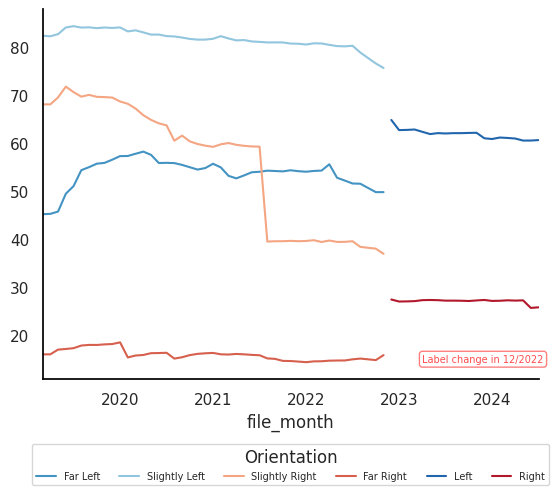

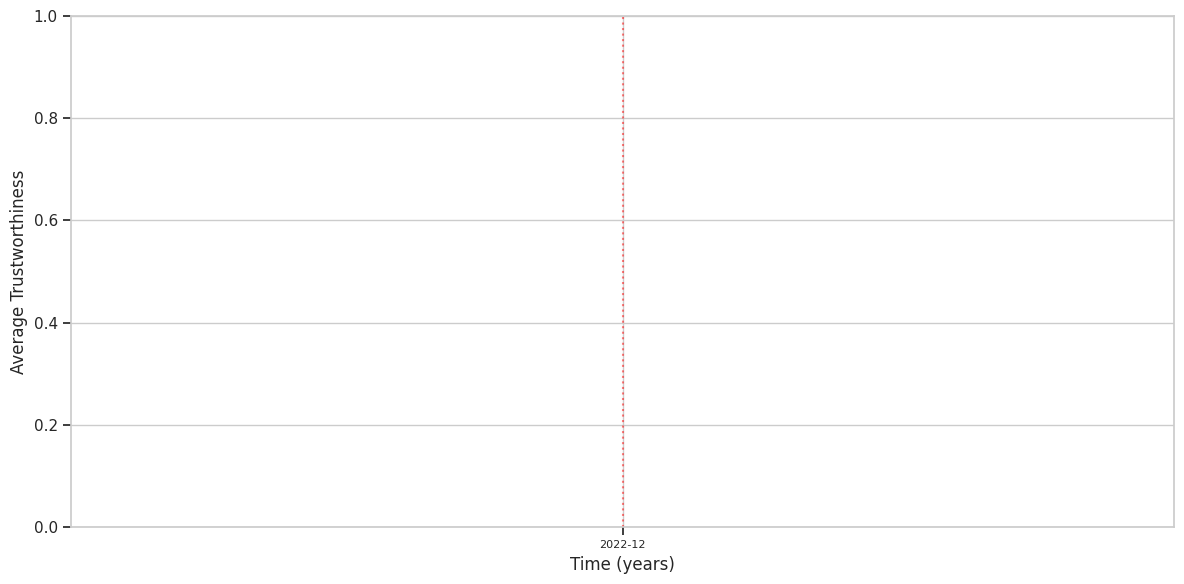

In [177]:
ax = score_x_orientation_time["mean"]\
    .unstack()\
    .plot(kind="line", 
          color=orientation_palette)

plt.figure(figsize=(12, 6))
plt.xlabel("Time (years)")
plt.ylabel("Average Trustworthiness")
plt.xticks(fontsize=8)
plt.axvline(x="2022-12", 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

xmin, xmax = ax.get_xlim()

#add text to axvline
ax.text(xmax - 15, 15, "Label change in 12/2022", 
        fontsize=7, 
        color="red",
        alpha=0.7,
        verticalalignment="center", 
        bbox=dict(facecolor="none", edgecolor="red",
                  boxstyle="round,pad=0.3",
                  alpha=0.5))

ax.legend(title="Orientation", 
          loc="lower center", 
          bbox_to_anchor=(0.5, -0.3), 
          ncol=6, 
          fontsize=7)

custom_plots(ax=ax)
plt.xticks(rotation=0)
plt.tight_layout()

In [178]:
#country average score per orientation over time
score_x_orientation_time_country = df_15\
    .groupby(["Country", "file_month", "Orientation_binary"])["Score"]\
    .agg(['mean', 'std'])\
    .reset_index()
score_x_orientation_time_country.head()

/tmp/ipykernel_4191584/3669954332.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Country", "file_month", "Orientation_binary"])["Score"]\


Country file_month Orientation_binary       mean        std
0     ALL    2019-03               Left        NaN        NaN
1     ALL    2019-03              Right        NaN        NaN
2     ALL    2019-04               Left        NaN        NaN
3     ALL    2019-04              Right        NaN        NaN
4     ALL    2019-05               Left  89.285714  10.676521

In [179]:
score_x_orientation = df_recent\
    .groupby(["Country", "Orientation"])["Score"]\
    .agg(["mean", "std"])\
    .reset_index()

score_x_orientation_sizes = df_recent\
    .groupby(["Country", "Orientation"])\
    .size()\
    .reset_index(name="size")

score_x_orientation = \
    score_x_orientation.merge(score_x_orientation_sizes, 
    on=["Country", "Orientation"])

score_x_orientation

Country Orientation       mean        std  size
0      ALL        Left  64.527027  27.968471    37
1      ALL       Right  31.631579  25.279592   114
2       AT        Left  88.750000   8.838835     2
3       AT       Right  37.166667  37.857463     9
4       AU        Left  80.937500  11.797208     8
5       AU       Right  12.846154  13.193093    13
6       CA        Left  79.375000  41.250000     4
7       CA       Right  58.222222  27.184682     9
8       DE        Left  85.000000  15.103807     9
9       DE       Right  32.646341  27.939051    41
10      FR        Left  56.093750  27.733385    16
11      FR       Right  31.269231  25.206440    26
12      GB        Left  82.690476  14.658169    21
13      GB       Right  55.043478  25.725347    23
14      IT        Left  62.045455  25.904106    11
15      IT       Right  34.062500  23.756831    40
16      NZ        Left  75.000000        NaN     1
17      NZ       Right  31.250000  22.980970     2
18      US        Left  57.690402  21.477819   323
19      US       Right  25.415179  18.591043  2352

In [180]:
#add to score_x_orientation
score_x_orientation = \
    score_x_orientation.merge(
        country_counts,
        on="Country"
    )
score_x_orientation

Country Orientation       mean        std  size  Total  Count  Percentage
0      ALL        Left  64.527027  27.968471    37   1173    151       12.87
1      ALL       Right  31.631579  25.279592   114   1173    151       12.87
2       AT        Left  88.750000   8.838835     2     40     11       27.50
3       AT       Right  37.166667  37.857463     9     40     11       27.50
4       AU        Left  80.937500  11.797208     8    141     21       14.89
5       AU       Right  12.846154  13.193093    13    141     21       14.89
6       CA        Left  79.375000  41.250000     4    440     13        2.95
7       CA       Right  58.222222  27.184682     9    440     13        2.95
8       DE        Left  85.000000  15.103807     9    309     50       16.18
9       DE       Right  32.646341  27.939051    41    309     50       16.18
10      FR        Left  56.093750  27.733385    16    314     42       13.38
11      FR       Right  31.269231  25.206440    26    314     42       13.38
12      GB        Left  82.690476  14.658169    21    499     44        8.82
13      GB       Right  55.043478  25.725347    23    499     44        8.82
14      IT        Left  62.045455  25.904106    11    467     51       10.92
15      IT       Right  34.062500  23.756831    40    467     51       10.92
16      NZ        Left  75.000000        NaN     1     19      3       15.79
17      NZ       Right  31.250000  22.980970     2     19      3       15.79
18      US        Left  57.690402  21.477819   323   6421   2675       41.66
19      US       Right  25.415179  18.591043  2352   6421   2675       41.66

In [181]:
#standardize size by total number of sources per country
score_x_orientation["Prop"] = \
    round(score_x_orientation["size"] / score_x_orientation["Total"] * 100, 2)
score_x_orientation

Country Orientation       mean        std  size  Total  Count  Percentage  \
0      ALL        Left  64.527027  27.968471    37   1173    151       12.87   
1      ALL       Right  31.631579  25.279592   114   1173    151       12.87   
2       AT        Left  88.750000   8.838835     2     40     11       27.50   
3       AT       Right  37.166667  37.857463     9     40     11       27.50   
4       AU        Left  80.937500  11.797208     8    141     21       14.89   
5       AU       Right  12.846154  13.193093    13    141     21       14.89   
6       CA        Left  79.375000  41.250000     4    440     13        2.95   
7       CA       Right  58.222222  27.184682     9    440     13        2.95   
8       DE        Left  85.000000  15.103807     9    309     50       16.18   
9       DE       Right  32.646341  27.939051    41    309     50       16.18   
10      FR        Left  56.093750  27.733385    16    314     42       13.38   
11      FR       Right  31.269231  25.206440    26    314     42       13.38   
12      GB        Left  82.690476  14.658169    21    499     44        8.82   
13      GB       Right  55.043478  25.725347    23    499     44        8.82   
14      IT        Left  62.045455  25.904106    11    467     51       10.92   
15      IT       Right  34.062500  23.756831    40    467     51       10.92   
16      NZ        Left  75.000000        NaN     1     19      3       15.79   
17      NZ       Right  31.250000  22.980970     2     19      3       15.79   
18      US        Left  57.690402  21.477819   323   6421   2675       41.66   
19      US       Right  25.415179  18.591043  2352   6421   2675       41.66   

     Prop  
0    3.15  
1    9.72  
2    5.00  
3   22.50  
4    5.67  
5    9.22  
6    0.91  
7    2.05  
8    2.91  
9   13.27  
10   5.10  
11   8.28  
12   4.21  
13   4.61  
14   2.36  
15   8.57  
16   5.26  
17  10.53  
18   5.03  
19  36.63

## Rating changes

In [182]:
#before the label changed
df_15_Orientation_diff = \
    df_15[["Domain", "file_date", 
           "Score",
           "Country", "Language", 
           "Orientation_before"]]

#convert into numerical value
df_15_Orientation_diff["Orientation_before"] = \
    df_15_Orientation_diff["Orientation_before"]\
        .replace({"Far Left": 2, "Slightly Left": 1, "Slightly Right": 3, "Far Right": 4})\
        .astype(float)

df_15_Orientation_diff.sort_values(by=["Domain", "Country", 
                                       "Language", "file_date"], 
                                   inplace=True)

df_15_Orientation_diff["Orientation_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country", "Language"])["Orientation_before"]\
        .diff()

df_15_Orientation_diff["Score_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country", "Language"])["Score"]\
        .diff()

df_15_Orientation_diff_filtered = \
        df_15_Orientation_diff[
                df_15_Orientation_diff["Orientation_diff"].notnull() 
                & (df_15_Orientation_diff["Orientation_diff"] != 0)]

df_15_Orientation_diff_filtered["Orientation_diff"].value_counts()

Orientation_diff
-1.0    61
 1.0    45
 2.0     3
Name: count, dtype: int64

In [183]:
#have domains switched labels?
df_15_Orientation_diff = \
    df_15[["Domain", "file_date", 
           "Score",
           "Country", "Language", 
           "Orientation_binary"]]

#convert into numerical value
df_15_Orientation_diff["Orientation_binary"] = \
    df_15_Orientation_diff["Orientation_binary"]\
        .replace({"Left": 1, "Right": 2})\
        .astype(float)

df_15_Orientation_diff.sort_values(by=["Domain", "Country", 
                                       "Language", "file_date"], 
                                   inplace=True)

df_15_Orientation_diff["Orientation_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country", "Language"])["Orientation_binary"]\
        .diff()

df_15_Orientation_diff["Score_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country", "Language"])["Score"]\
        .diff()

df_15_Orientation_diff_filtered = \
        df_15_Orientation_diff[
                df_15_Orientation_diff["Orientation_diff"].notnull() 
                & (df_15_Orientation_diff["Orientation_diff"] != 0)]

/tmp/ipykernel_4191584/3078608873.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Left": 1, "Right": 2})\
/tmp/ipykernel_4191584/3078608873.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace({"Left": 1, "Right": 2})\


In [184]:
#df_15_Orientation_diff[df_15_Orientation_diff["Domain"] == "newsblaze.com"].head(20)

## Full validation

In [185]:
df_15_de = df_15[df_15["Language"] == "de"]

#only until june 15
df_15_de_val = df_15_de[df_15_de["file_month"] <= "2024-07"]

#keep unique domains
df_15_de_val = df_15_de_val\
    .drop_duplicates(
        subset="Domain", 
        keep="last")

print(f'Validating {len(df_15_de_val)} domains as of {df_15_de_val.file_month.max()}')
df_15_de_val = df_15_de_val[["Domain", "Orientation_binary"]]
#df_15_de_val.to_csv("df_15_de.csv", index=False)

Validating 420 domains as of 2024-07


In [186]:
df_15_de_manual = pd.read_csv("df_15_de_manual.csv", 
                                  delimiter=";")

df_15_de_overlap = df_15_de_val.merge(df_15_de_manual, 
                                  on="Domain", 
                                  how="left")

df_15_de_overlap["Orientation_manual"]\
    .value_counts(normalize=True)

Orientation_manual
Right    0.635036
Left     0.218978
Dead     0.145985
Name: proportion, dtype: float64

In [187]:
df_15_de_overlap = df_15_de_overlap[
    df_15_de_overlap["Orientation_manual"] != "Dead"]
len(df_15_de_overlap)

400

In [188]:
print(f'Manual: ')
print(f'{df_15_de_overlap["Orientation_manual"].value_counts(normalize=True)}')

print(f'NewsGuard: ')
print(f'{df_15_de_overlap["Orientation_binary"].value_counts(normalize=True)}')

Manual: 
Orientation_manual
Right    0.74359
Left     0.25641
Name: proportion, dtype: float64
NewsGuard: 
Orientation_binary
Right    0.816901
Left     0.183099
Name: proportion, dtype: float64


In [189]:
both_present = df_15_de_overlap[
    (df_15_de_overlap['Orientation_manual'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]
len(both_present)

63

In [190]:
only_manual = df_15_de_overlap[
    (df_15_de_overlap['Orientation_manual'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].isnull())
]
len(only_manual)

54

In [191]:
only_ng = df_15_de_overlap[
    (df_15_de_overlap['Orientation_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_manual'].isnull())
]
len(only_ng)

8

In [192]:
df_15_de_overlap["Agreement"] = (
    df_15_de_overlap["Orientation_binary"].astype('string').fillna('NaN') ==
    df_15_de_overlap["Orientation_manual"].astype('string').fillna('NaN')
)
df_15_de_overlap["Agreement"] = \
    df_15_de_overlap["Agreement"]\
        .astype(int)

print(f'Agreement between domains: {df_15_de_overlap["Agreement"].mean().round(2)}')

Agreement between domains: 0.84


In [193]:
#look at the ones with no agreement
#df_15_de_overlap[df_15_de_overlap["Agreement"] == 0]

In [194]:
#df_15_de_overlap[(df_15_de_overlap["Orientation_binary"].isna()) &
#                 (df_15_de_overlap["Orientation_manual"] == "Left") & 
#                 ((df_15_de_overlap["MBFC"] == "LEFT-CENTER") | 
#                  (df_15_de_overlap["MBFC"] == "LEFT"))]

In [195]:
df_15_de_overlap["MBFC"].value_counts()

MBFC
RIGHT-CENTER                      17
LEFT-CENTER                       11
RIGHT                              4
LEAST BIASED                       3
LEFT                               3
RIGHT CONSPIRACY-PSEUDOSCIENCE     1
RIGHT-CONSPIRACY                   1
Name: count, dtype: int64

In [196]:
#recode everything containing LEFT in MBFC to Left
df_15_de_overlap["MBFC_binary"] = df_15_de_overlap["MBFC"]\
    .replace({"LEFT-CENTER": "Left", "LEFT": "Left",
              "RIGHT-CENTER": "Right", "RIGHT": "Right",
              "RIGHT-CONSPIRACY": "Right",
              "RIGHT CONSPIRACY-PSEUDOSCIENCE": "Right",
              "LEAST BIASED": None})
              
df_15_de_overlap["MBFC_binary"].value_counts()

MBFC_binary
Right    23
Left     14
Name: count, dtype: int64

In [197]:
expert_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]
mbfc_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].isnull())
]

ng_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].isnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]

print(f'Both expert ratings: {len(expert_present)}')
print(f'Only MBFC: {len(mbfc_present)}')
print(f'Only NG: {len(ng_present)}')

Both expert ratings: 6
Only MBFC: 31
Only NG: 65


In [198]:
#agreement in expert_present
expert_present["Agreement_experts"] = (
    expert_present["MBFC_binary"] == expert_present["Orientation_binary"]
)
expert_present["Agreement_experts"] = \
    expert_present["Agreement_experts"]\
        .astype(int)

print(f'Agreement: {expert_present["Agreement_experts"].mean().round(2)}')

#expert_present[expert_present["Agreement_experts"] == 0]

Agreement: 0.83


In [199]:
#merge MBFC and manual into a new column
df_15_de_overlap["Orientation_merged"] = \
    df_15_de_overlap["MBFC_binary"]\
        .combine_first(df_15_de_overlap["Orientation_binary"])

#calculate agreement
df_15_de_overlap["Agreement_merged"] = (
    df_15_de_overlap["Orientation_manual"].astype("string").fillna("NaN") ==
    df_15_de_overlap["Orientation_merged"].astype("string").fillna("NaN")
)
df_15_de_overlap["Agreement_merged"] = \
    df_15_de_overlap["Agreement_merged"]\
        .astype(int)

perc_merged = df_15_de_overlap["Agreement_merged"].mean().round(2)

print(f'Agreement when merging NG with MBFC: {perc_merged}')

Agreement when merging NG with MBFC: 0.9


In [200]:
#df_15_de_overlap[df_15_de_overlap["Agreement_merged"] == 0]

In [201]:
#is there one that is not because of NaN?
df_15_de_overlap[(df_15_de_overlap["Agreement_merged"] == 0) &
                 (df_15_de_overlap["Orientation_manual"].notnull() &
                 df_15_de_overlap["Orientation_merged"].notnull())]

Empty DataFrame
Columns: [Domain, Orientation_binary, Orientation_manual, MBFC, Europolitics, Agreement, MBFC_binary, Orientation_merged, Agreement_merged]
Index: []

In [202]:
df_15_de_overlap["Orientation_all"] = \
    df_15_de_overlap["Orientation_manual"]\
        .combine_first(df_15_de_overlap["Orientation_merged"])

df_15_de_overlap["Orientation_all"].value_counts()

Orientation_all
Right    94
Left     35
Name: count, dtype: int64

In [203]:
df_15_de_overlap["Orientation_all"] = \
    df_15_de_overlap["Orientation_all"].fillna("Neutral")

df_15_de_overlap["Orientation_all"].value_counts()

Orientation_all
Neutral    271
Right       94
Left        35
Name: count, dtype: int64

In [204]:
#save as csv
df_15_de_overlap.to_csv("df_15_de_orientation_validated.csv", index=False)

## Topics

In [205]:
print(
    f'Out of {len(df_recent)} ratings, '
    f'there are {df_recent["Topics"].isnull().sum()} without topic. ')

print(
    f'This makes up {round(df_recent["Topics"].isnull().sum()/len(df_recent)*100,2)}% ')

Out of 9823 ratings, there are 148 without topic. 
This makes up 1.51% 


In [206]:
df_15\
    .groupby("file_date")["Topics"]\
    .count()\
    .head(10)

file_date
2019-03-15 01:00:00      0
2019-04-15 01:00:00      0
2019-05-15 01:00:00      0
2019-06-15 01:00:00      0
2019-07-15 01:00:00      0
2019-08-15 01:00:00      0
2019-09-15 01:00:00      0
2019-10-15 01:00:00      4
2019-11-15 01:00:00     83
2019-12-15 01:00:00    283
Name: Topics, dtype: int64

In [207]:
recent_topics_df = \
    df_recent[[
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

recent_topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

recent_topics_df["Topics"] = \
    df_recent["Topics"]\
        .str.split(",")  #split topics into lists

#recent_topics_df.head(3)

In [208]:
recent_topics_df = \
    recent_topics_df\
        .explode("Topics")\
        .reset_index(drop=True)

recent_topics_df["Topics"] = \
    recent_topics_df["Topics"].str.capitalize()

recent_topics_df["Topics"] = recent_topics_df["Topics"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
              "Sports and athletics": "Sports",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news",
                "Business or personal finance": "Business"})

#recent_topics_df.head(3)

In [209]:
recent_topic_count = \
    recent_topics_df\
        .groupby("Topics")\
        .size()\
        .reset_index()

recent_topic_count["%"] = \
    (recent_topic_count[0] / len(df_recent) * 100)\
        .round(2)

recent_topic_count\
    .columns = ["Topics", "Count", "%"]

recent_topic_avg = \
    recent_topics_df\
        .groupby("Topics")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

recent_topic_avg\
    .columns = ["Topics", "Score", "SD"]

recent_topic_desc = \
    pd.merge(recent_topic_count,
             recent_topic_avg,
            on="Topics")

recent_topic_desc.sort_values(by="Count",
                                ascending=False,
                                inplace=True)

recent_topic_desc.head(5)

Topics  Count      %  Score     SD
11      Local news   3832  39.01  65.09  31.60
14  Political news   3682  37.48  57.43  33.31
7     General news   1969  20.04  67.91  30.53
8      Health news   1044  10.63  54.33  35.92
2     Conspiracies    965   9.82  51.66  35.88

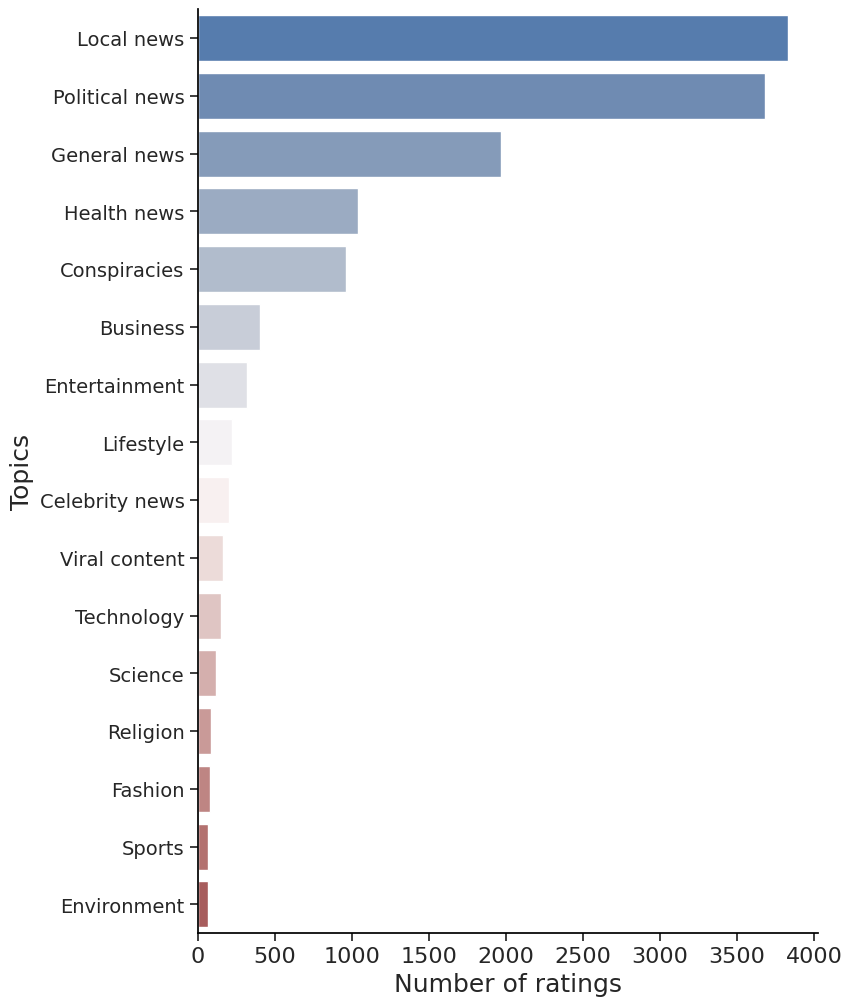

In [210]:
#bar chart with topic count in recent
fig, ax = plt.subplots(figsize=(8, 12))

#remove topics with less than 50 ratings
recent_topic_desc_50 = recent_topic_desc[recent_topic_desc["Count"] > 50]

sns.barplot(data=recent_topic_desc_50,
            x="Count",
            y="Topics",
            palette="vlag",
            hue="Topics",
            ax=ax)

plt.xlabel("Number of ratings", 
           fontsize=18)
plt.ylabel("Topics", 
           fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
custom_plots(ax=ax)

In [211]:
recent_topic_desc.sort_values(by="Score",
                                ascending=True)

Topics  Count      %  Score     SD
2              Conspiracies    965   9.82  51.66  35.88
8               Health news   1044  10.63  54.33  35.92
14           Political news   3682  37.48  57.43  33.31
16                  Science    120   1.22  64.01  33.39
18               Technology    154   1.57  64.04  32.70
5               Environment     68   0.69  65.07  33.85
11               Local news   3832  39.01  65.09  31.60
13                Parenting     36   0.37  65.46  33.35
19            Viral content    163   1.66  66.36  28.68
1            Celebrity news    205   2.09  66.80  30.72
4             Entertainment    320   3.26  67.86  30.68
7              General news   1969  20.04  67.91  30.53
12     Military and defense     48   0.49  70.91  26.30
10                Lifestyle    223   2.27  71.00  28.89
6                   Fashion     80   0.81  72.06  28.35
3                 Education     20   0.20  74.85  32.84
15                 Religion     88   0.90  74.92  24.42
17                   Sports     69   0.70  76.00  28.96
0                  Business    408   4.15  77.58  25.98
9   Law or criminal justice     34   0.35  79.66  24.58

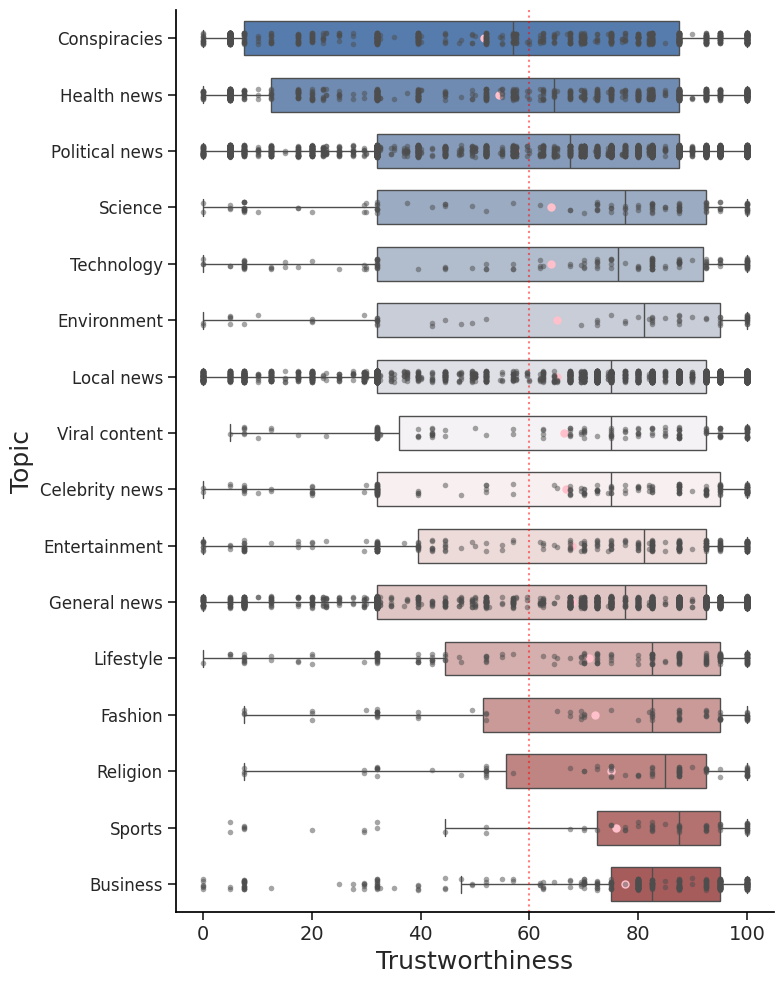

In [212]:
fig, ax = plt.subplots(figsize=(8, 10))

recent_topic_desc_50.sort_values(by="Score",
                                ascending=True,
                                inplace=True)


bp = sns.boxplot(data=recent_topics_df, 
            y="Topics", 
            x="Score",
            hue="Topics",
            order=recent_topic_desc_50["Topics"],
            hue_order=recent_topic_desc_50["Topics"],
            palette="vlag",
            width=0.6,
            #whis=0,
            fliersize=0,
            ax=ax)

sp = sns.stripplot(data=recent_topics_df, 
            y="Topics", 
            x="Score",
            order=recent_topic_desc_50["Topics"],
            color=".3",
            size=4,
            alpha=0.5,
            ax=ax)

pp = sns.pointplot(data=recent_topics_df, 
            y="Topics", 
            x="Score",
            estimator="mean",
            order=recent_topic_desc_50["Topics"],
            errorbar=None,
            color="pink",
            linestyle="none",
            markersize=4,
            ax=ax)

#no legend
plt.legend([],[], frameon=False)

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Trustworthiness",
            fontsize=18)
plt.ylabel("Topic", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.xlim(-5,105)
custom_plots()
plt.tight_layout()


plt.show()

In [213]:
#get list of domains with rating N
bad_domains = recent_topics_df\
    [recent_topics_df["Rating"] == "N"]\
    ["Domain"].unique()

len(bad_domains)

3337

In [214]:
topics_bad = recent_topics_df\
        .groupby(["Topics", "Rating"])["Domain"]\
        .nunique()\
        .unstack(fill_value=0)\
        .reset_index()\
        .sort_values(by="N", ascending=False)

#add percentage of good vs bad
topics_bad["% N"] = \
    (topics_bad["N"] / len(bad_domains) * 100)\
        .round(1)

topics_bad

Rating                   Topics     N     T   % N
14               Political news  1672  1669  50.1
11                   Local news  1380  2123  41.4
7                  General news   618  1194  18.5
8                   Health news   495   481  14.8
2                  Conspiracies   485   398  14.5
4                 Entertainment   101   192   3.0
1                Celebrity news    72   120   2.2
10                    Lifestyle    66   147   2.0
0                      Business    63   322   1.9
19                Viral content    57    95   1.7
18                   Technology    52    90   1.6
16                      Science    39    69   1.2
5                   Environment    25    42   0.7
6                       Fashion    23    55   0.7
15                     Religion    23    63   0.7
13                    Parenting    14    22   0.4
17                       Sports    14    53   0.4
12         Military and defense    13    32   0.4
9       Law or criminal justice     6    27   0.2
3                     Education     4    16   0.1

In [215]:
#how many of bad domains cover each topic?
bad_domains_topics = recent_topics_df\
    [recent_topics_df["Domain"].isin(bad_domains)]\
    .groupby("Topics")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_topics["%"] = \
    (bad_domains_topics["Domain"] / len(bad_domains) * 100)\
        .round(1)

bad_topics = bad_domains_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(5)

bad_topics

Topics  Domain     %
14  Political news    1672  50.1
11      Local news    1380  41.4
7     General news     618  18.5
8      Health news     495  14.8
2     Conspiracies     485  14.5

### Over time

In [216]:
topics_df = \
    df_15[[
        "file_date", 
        "Domain", "Country", "Language",
        "Topics", "Orientation", "Score", "Rating"]]

topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

topics_df["Topic"] = \
    topics_df["Topics"]\
        .str.split(",")  #split topics into lists

topics_df = \
    topics_df\
        .explode("Topic")\
        .reset_index(drop=True)

topics_df["Topic"] = \
    topics_df["Topic"].str.capitalize()

topics_df["Topic"] = topics_df["Topic"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
              "Sports and athletics": "Sports",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news",
                "Business or personal finance": "Business"})

#topics_df.tail(3)

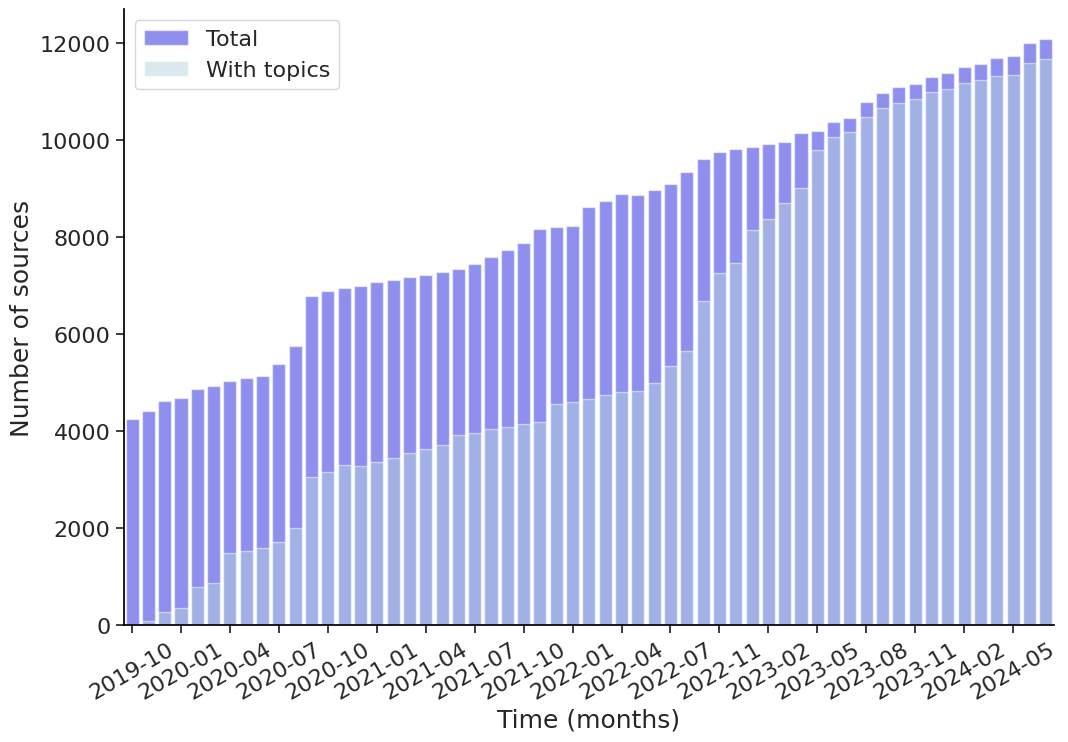

In [217]:
#sources with not a NaN in Topipcs column

topic_domains = df_15[df_15["Topics"].notnull()]

topic_domain_count = \
    topic_domains\
        .groupby("file_date")\
        .size()\
        .reset_index(name="Count")

#percentage of domains
count_month = \
    df_15\
        .groupby("file_date")\
        .size()\
        .reset_index(name="Total")

topic_domain_count = \
    topic_domain_count\
        .merge(count_month, 
               on="file_date")

topic_domain_count["Prop"] = \
    (topic_domain_count["Count"] / topic_domain_count["Total"] * 100)\
        .round(2)

topic_domain_count["file_month"] = \
    topic_domain_count["file_date"].dt.strftime("%Y-%m")

fig,ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=topic_domain_count,
            x="file_month",
            y="Total",
            color="blue",
            alpha=0.5,
            errorbar=None,
            ax=ax)

sns.barplot(data=topic_domain_count,
            x="file_month",
            y="Count",
            color="lightblue",
            alpha=0.5,
            errorbar=None,
            ax=ax)

#legend
ax.legend(["Total", "With topics"],
            loc="upper left",
            fontsize=16)

plt.xlabel("Time (months)",
              fontsize=18)

#only every few months
ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=30)
plt.ylabel("Number of sources",
                fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
custom_plots(ax=ax)

plt.savefig(join(figures_path,
                    "topic_source_over_time.png"),
                bbox_inches='tight', 
                pad_inches=0.1,
                dpi=300)

plt.savefig(join(figures_path,
                    "topic_source_over_time.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()

In [218]:
topic_freq = topics_df\
    .groupby(["file_date", "Topic"])\
    .size()\
    .reset_index(name="Count")

topic_freq\
        .groupby("file_date")["Count"]\
        .sum()\
        .reset_index()\
        .sort_values(by="Count",
                        ascending=True)\
        .head(15)

file_date  Count
0  2019-10-15 01:00:00      4
1  2019-11-15 01:00:00    108
2  2019-12-15 01:00:00    321
3  2020-01-15 01:00:00    406
4  2020-02-15 01:00:00   1416
5  2020-03-15 01:00:00   1526
6  2020-04-15 01:00:00   2913
7  2020-05-15 01:00:00   3055
8  2020-06-15 01:00:00   3177
9  2020-07-15 01:00:00   3348
10 2020-08-15 01:00:00   4019
11 2020-09-15 01:00:00   5234
12 2020-10-15 01:00:00   5394
14 2020-12-15 01:00:00   5601
13 2020-11-15 01:00:00   5655

In [219]:
#how many of bad domains cover each topic?
bad_domains_time = topics_df\
    [topics_df["Rating"] == "N"]\
    ["Domain"].unique()

bad_domains_time_topics = topics_df\
    [topics_df["Domain"].isin(bad_domains_time)]\
    .groupby("Topic")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_time_topics["%"] = \
    (bad_domains_time_topics["Domain"] / len(bad_domains_time) * 100)\
        .round(2)

bad_topics_bad_sources_time = bad_domains_time_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(7)

bad_topics_bad_sources_time

Topic  Domain      %
18        Political news    3541  76.22
1       COVID-19 misinfo    1996  42.96
3           Conspiracies    1589  34.20
14            Local news    1289  27.74
11           Health news    1105  23.78
10          General news     477  10.27
9   General / local news     187   4.02

In [220]:
topics_df\
        .groupby("Topic")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .sort_values(by="mean", ascending=True)\
        .head(20)

Topic       mean        std
3                      Conspiracies  12.465319  12.601365
1                  COVID-19 misinfo  18.223961  16.226194
11                      Health news  38.428475  35.601690
18                   Political news  41.100045  31.698428
15             Military and defense  59.228840  37.364363
23                    Viral content  63.005230  20.565462
19                         Religion  67.508403  27.685139
2                    Celebrity news  70.323386  18.075394
4                  Criminal justice  71.612426  21.395422
20                          Science  73.537571  28.089616
16                        Parenting  74.091996  17.177971
12          Law or criminal justice  74.207692  20.793133
8                           Fashion  74.778103  12.484656
7                       Environment  75.009332  24.417876
14                       Local news  75.331763  25.824651
6                     Entertainment  75.498107  17.937536
13                        Lifestyle  76.281620  14.414230
17  Personal finance news or advice  78.380019  15.966671
21                           Sports  79.927496  12.630341
10                     General news  80.540332  22.256054

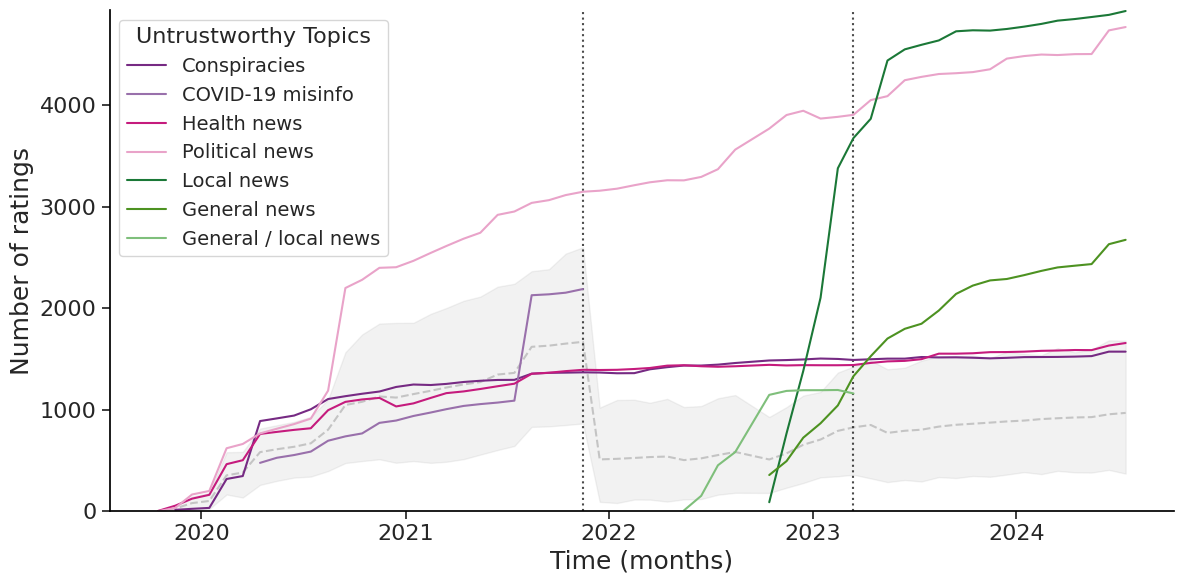

In [221]:
plt.figure(figsize=(12, 6))
bad_topics_palette = {
    "Conspiracies": "#762a83",
    "COVID-19 misinfo": "#9970ab",
    "Health news": "#c51b7d",
    "Political news": "#e9a3c9",
    "Local news": "#1b7837",
    "General news":"#4d9221",
    "General / local news": "#7fbf7b"}

bad_topics_list = \
    bad_topics_bad_sources_time["Topic"].to_list()

sns.lineplot(x="file_date", 
             y="Count", 
             estimator="mean",
             errorbar=("ci", 95),
             color="grey",
             linestyle="--",
             alpha=0.4,
             err_kws={"alpha":0.1},
             data=topic_freq)

#add vertical line
plt.axvline(x=pd.Timestamp("2021-11-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7)

plt.axvline(x=pd.Timestamp("2023-03-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7)


sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic",
             palette=bad_topics_palette,
             hue_order=bad_topics_palette.keys(),
             data=topic_freq[topic_freq["Topic"].isin(bad_topics_list)])


plt.xlabel("Time (months)", fontsize=18)
plt.ylabel("Number of ratings", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,max(topic_freq["Count"])+10)

plt.legend(title="Untrustworthy Topics",
           title_fontsize=16,
           fontsize=14,
           ncol=1)

custom_plots()
plt.tight_layout()

plt.show()

In [222]:
#show me the max count for health misinformation
topic_freq[topic_freq["Topic"] == "COVID-19 misinfo"]

file_date             Topic  Count
22  2020-04-15 01:00:00  COVID-19 misinfo    477
27  2020-05-15 01:00:00  COVID-19 misinfo    527
32  2020-06-15 01:00:00  COVID-19 misinfo    554
37  2020-07-15 01:00:00  COVID-19 misinfo    588
42  2020-08-15 01:00:00  COVID-19 misinfo    695
47  2020-09-15 01:00:00  COVID-19 misinfo    738
52  2020-10-15 01:00:00  COVID-19 misinfo    767
57  2020-11-15 01:00:00  COVID-19 misinfo    871
62  2020-12-15 01:00:00  COVID-19 misinfo    894
67  2021-01-15 01:00:00  COVID-19 misinfo    939
72  2021-02-15 01:00:00  COVID-19 misinfo    973
77  2021-03-15 01:00:00  COVID-19 misinfo   1006
82  2021-04-15 01:00:00  COVID-19 misinfo   1038
87  2021-05-15 01:00:00  COVID-19 misinfo   1056
92  2021-06-15 01:00:00  COVID-19 misinfo   1071
97  2021-07-15 01:00:00  COVID-19 misinfo   1090
102 2021-08-15 01:00:00  COVID-19 misinfo   2129
107 2021-09-15 01:00:00  COVID-19 misinfo   2138
112 2021-10-15 01:00:00  COVID-19 misinfo   2154
117 2021-11-15 01:00:00  COVID-19 misinfo   2190

### By Country

In [223]:
country_topics = recent_topics_df\
    .groupby(["Country", "Topics"])\
    .size()\
    .reset_index(name="Count")

country_topics["Percentage"] = \
    (country_topics["Count"] / recent_topics_df["Domain"].nunique() * 100)\
        .round(2)

country_topics

Country          Topics  Count  Percentage
0       ALL        Business     40        0.46
1       ALL  Celebrity news     24        0.28
2       ALL    Conspiracies    106        1.23
3       ALL       Education      1        0.01
4       ALL   Entertainment     47        0.54
..      ...             ...    ...         ...
171      US        Religion     48        0.56
172      US         Science     69        0.80
173      US          Sports     43        0.50
174      US      Technology     93        1.08
175      US   Viral content     93        1.08

[176 rows x 4 columns]

In [224]:
topic_avg = \
    recent_topics_df\
        .groupby(["Country", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

topic_avg.columns = \
    ["Country", "Topics", "Score", "SD"]

topic_descriptives = \
    pd.merge(
        country_topics, 
        topic_avg, 
        on=["Country", "Topics"])

topic_descriptives =\
    topic_descriptives\
    .sort_values(["Country", "Count"], 
                ascending=[True, False])

topic_descriptives.head(2)

Country          Topics  Count  Percentage  Score     SD
11     ALL      Local news    435        5.03  75.31  26.50
14     ALL  Political news    423        4.89  73.49  24.77

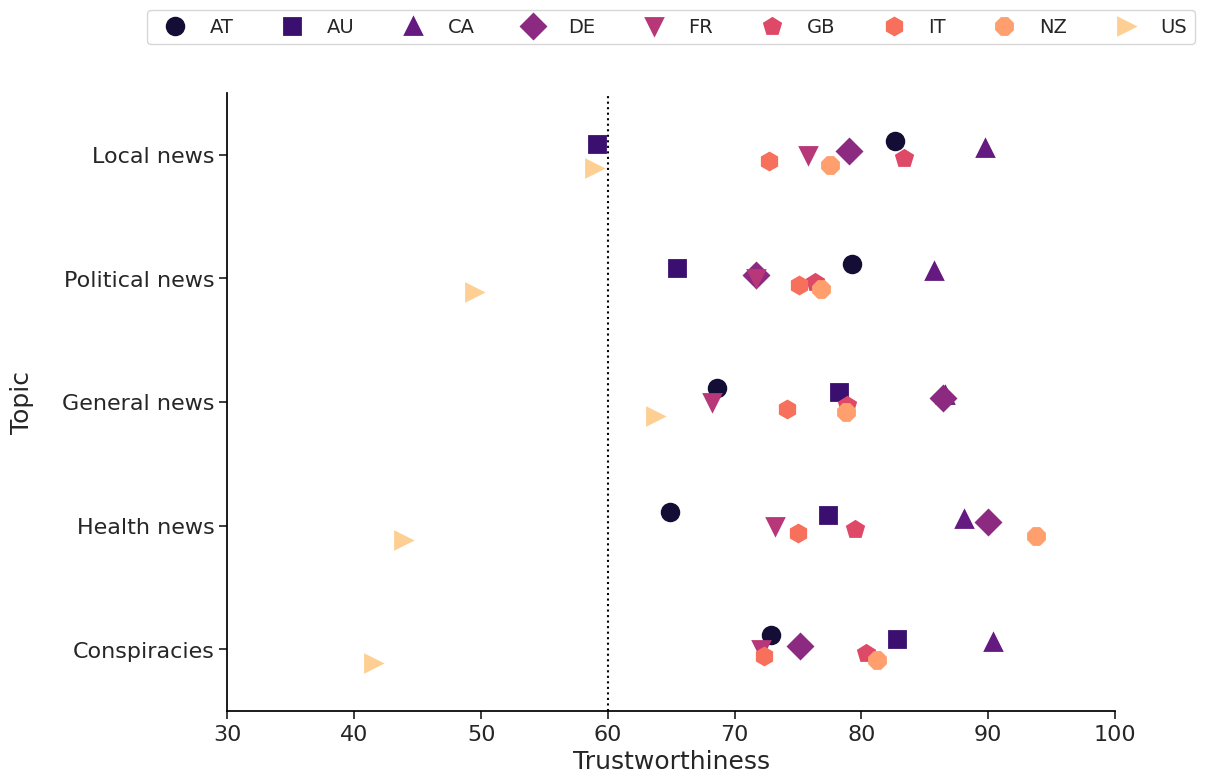

In [225]:
plt.figure(figsize=(12, 8))

top_topics = recent_topic_desc\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(5)

top_topics_country = \
    topic_descriptives[
        topic_descriptives["Topics"].isin(top_topics["Topics"])]

#remove ALL 
top_topics_country = top_topics_country[top_topics_country["Country"] != "ALL"]
country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]



top_topics_country.sort_values(by="Count", 
                                ascending=False,
                                inplace=True)
sns.pointplot(y="Topics", 
            x="Score",
            hue="Country",
            hue_order=sorted(top_topics_country["Country"].unique()),
            data=top_topics_country, 
            dodge=True,
            markers = country_markers,
            markersize = 12,
            linestyle="None",
            palette="magma")

plt.axvline(x=60,
            color="black", 
            linestyle="dotted")

plt.xlim(30,100)
plt.xlabel("Trustworthiness", fontsize=18)
plt.ylabel("Topic", 
           fontsize=18,
           labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14,
           loc="upper center", 
           bbox_to_anchor=(0.5, 1.15),
           ncol=9)
plt.tight_layout()
custom_plots()

plt.savefig(join(figures_path, "topics_score_per_country.png"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.savefig(join(figures_path, "topics_score_per_country.pdf"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.show()

In [226]:
#per country, which 5 topics are the most popular?
pop_topics_country = topic_descriptives\
    .groupby("Country")\
    .apply(lambda x: x.nlargest(5, 'Count'))\
    .reset_index(drop=True)

pop_topics_country = \
    pop_topics_country[pop_topics_country["Country"] != "ALL"]

recent_topics_df_country = pd.merge(recent_topics_df, pop_topics_country[['Country', 'Topics']], on=['Country', 'Topics'])
recent_topics_df_country\
    .groupby("Country")["Topics"]\
    .nunique()

/tmp/ipykernel_4191584/265117987.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'Count'))\


Country
AT    5
AU    5
CA    5
DE    5
FR    5
GB    5
IT    5
NZ    5
US    5
Name: Topics, dtype: int64

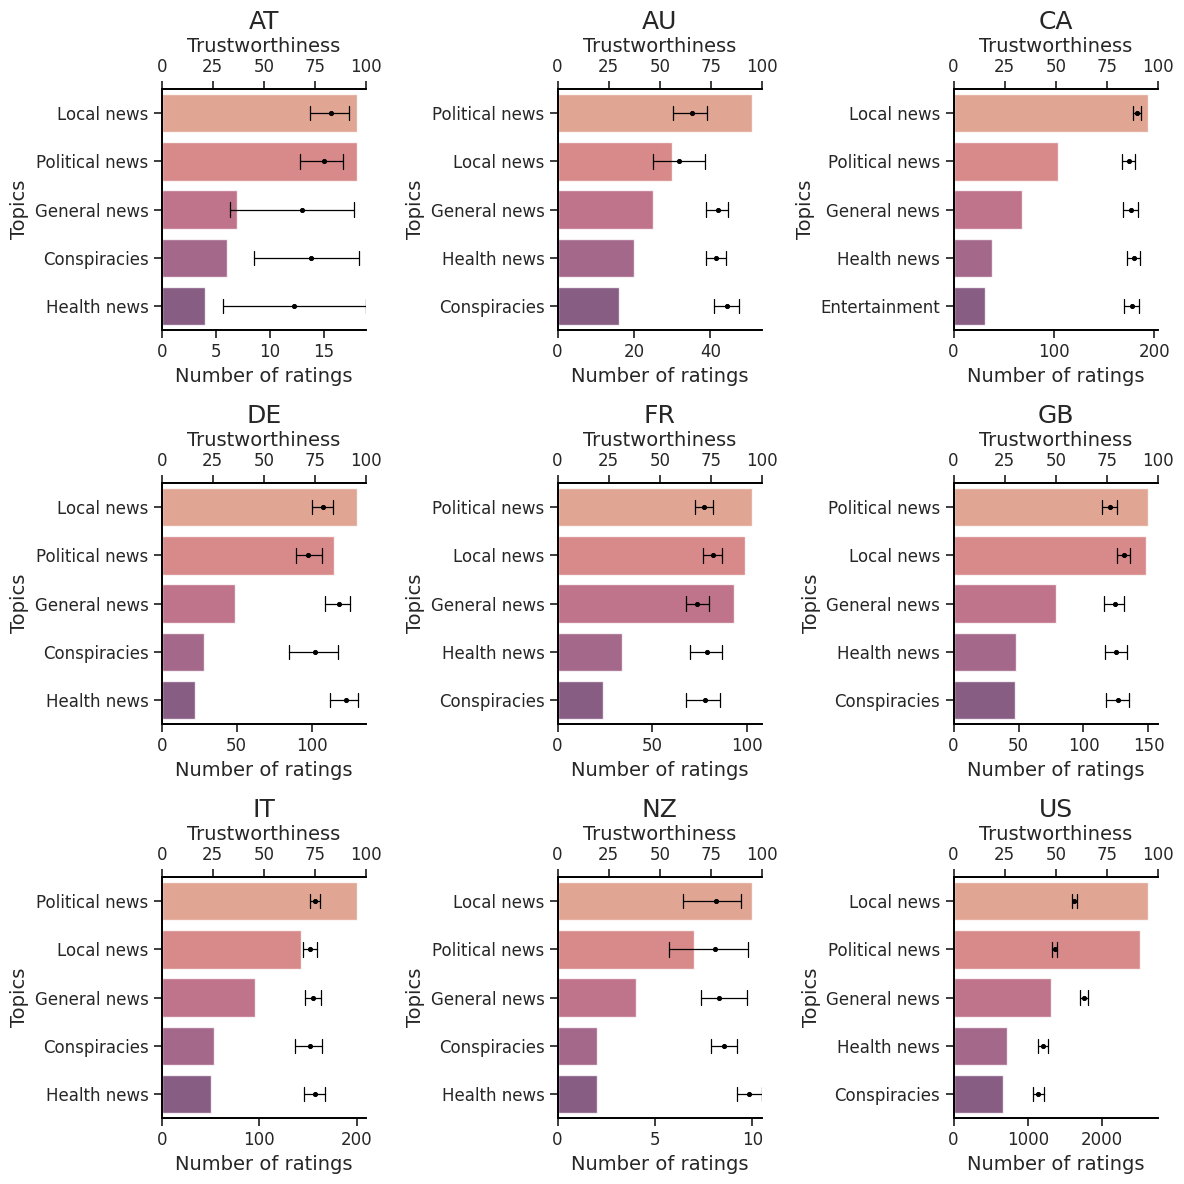

In [227]:
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, sharex=False)
plt.subplots_adjust(hspace=1, wspace=1)

for i, country in enumerate(pop_topics_country["Country"].unique()):
    row = i // 3
    col_in_row = i % 3

    country_topics = pop_topics_country[pop_topics_country["Country"] == country]
    recent_country_topics = recent_topics_df_country[recent_topics_df_country["Country"] == country]

    sns.barplot(data=country_topics, 
                x="Count", 
                y="Topics", 
                hue="Topics", 
                ax=axs[row, col_in_row], 
                alpha=0.8,
                palette="flare")
    axs[row, col_in_row].set_xlabel("Number of ratings", fontsize=14)
    axs[row, col_in_row].xaxis.set_ticks_position("bottom")
    axs[row, col_in_row].xaxis.set_label_position("bottom")
    axs[row, col_in_row].yaxis.set_ticks_position("left")
    axs[row, col_in_row].set_ylabel("Topics", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    axs[row, col_in_row].grid(False)
    axs[row, col_in_row].spines["right"].set_visible(False)
    axs[row, col_in_row].spines["top"].set_color("black")
    axs[row, col_in_row].spines["bottom"].set_color("black")
    axs[row, col_in_row].spines["left"].set_color("black")

    ax2 = axs[row, col_in_row].twiny()
    sns.pointplot(data=recent_country_topics, 
                  x="Score", 
                  y="Topics", 
                  ax=ax2, 
                  linestyle="none", 
                  color="black",
                  capsize=0.3, 
                  markersize=3, 
                  linewidth=0.9,
                  marker="o")

    ax2.xaxis.set_visible(True)
    ax2.set_xlim(0, 100)
    ax2.xaxis.set_label_position("top")
    ax2.xaxis.set_ticks_position("top")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_xlabel("Trustworthiness", fontsize=14)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.xaxis.tick_top()
    ax2.yaxis.set_visible(False)
    ax2.spines["top"].set_color("black")
    ax2.spines["bottom"].set_color("black")
    ax2.spines["left"].set_color("black")
    ax2.spines["right"].set_visible(False)
    ax2.grid(False)

plt.tight_layout()

plt.savefig(join(figures_path,
                    "topics_country.png"),
                bbox_inches='tight', 
                pad_inches=0.1,
                dpi=300)

plt.savefig(join(figures_path,
                    "topics_country.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()

In [228]:
#show for topic health information
topic_descriptives[topic_descriptives["Topics"] == "Health news"]

Country       Topics  Count  Percentage  Score     SD
8       ALL  Health news     99        1.15  75.12  23.49
26       AT  Health news      4        0.05  64.88  44.44
38       AU  Health news     20        0.23  77.35  11.37
56       CA  Health news     38        0.44  88.05  10.29
76       DE  Health news     22        0.25  89.95  17.49
95       FR  Health news     34        0.39  73.21  24.52
114      GB  Health news     48        0.56  79.47  20.39
134      IT  Health news     51        0.59  74.96  20.92
152      NZ  Health news      2        0.02  93.75   8.84
164      US  Health news    726        8.40  43.86  36.00

In [229]:
topic_descriptives[topic_descriptives["Topics"] == "Political news"]

Country          Topics  Count  Percentage  Score     SD
14      ALL  Political news    423        4.89  73.49  24.77
29       AT  Political news     18        0.21  79.25  24.66
42       AU  Political news     51        0.59  65.48  31.02
62       CA  Political news    104        1.20  85.74  16.11
81       DE  Political news    115        1.33  71.70  33.82
101      FR  Political news    103        1.19  71.71  23.54
120      GB  Political news    150        1.74  76.32  22.70
140      IT  Political news    200        2.31  75.04  19.24
155      NZ  Political news      7        0.08  76.79  29.54
170      US  Political news   2511       29.05  49.41  33.81

In [230]:
topic_descriptives[topic_descriptives["Topics"] == "Military and defense"]

Country                Topics  Count  Percentage  Score     SD
12      ALL  Military and defense      6        0.07  82.50   6.89
60       CA  Military and defense      1        0.01  80.00    NaN
99       FR  Military and defense      1        0.01  87.50    NaN
118      GB  Military and defense      3        0.03  73.17  36.20
138      IT  Military and defense      2        0.02  85.00   3.54
168      US  Military and defense     35        0.40  67.19  28.49

### By orientation

In [231]:
#topics and orientation overlap
topics_orientation = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])\
        .size()\
        .reset_index(name="Count")

mean_scores = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

mean_scores.columns = \
    ["Orientation", "Topics", "Score", "SD"]

topic_orientation_scores = pd.merge(
    topics_orientation, 
    mean_scores, 
    on=["Orientation", "Topics"])

#lowest score for left and right
topic_orientation_scores\
    .sort_values(by="Score", 
                 ascending=True)\
    .head(20)

Orientation                Topics  Count  Score     SD
23       Right             Education      3  15.67  14.15
28       Right           Health news    389  19.13  22.50
22       Right          Conspiracies    379  19.15  22.95
37       Right                Sports      8  23.94  26.28
34       Right        Political news   1397  25.34  19.26
33       Right             Parenting      9  26.17  19.24
36       Right               Science     34  26.40  24.68
25       Right           Environment     14  27.14  27.42
20       Right              Business     43  27.58  23.30
31       Right            Local news   1193  28.41  16.42
27       Right          General news    499  28.45  18.44
13        Left             Parenting      1  29.50    NaN
12        Left  Military and defense      1  29.50    NaN
38       Right            Technology     43  29.67  24.79
24       Right         Entertainment     79  31.36  22.63
30       Right             Lifestyle     44  33.35  18.00
21       Right        Celebrity news     49  33.42  20.96
39       Right         Viral content     49  34.99  18.07
32       Right  Military and defense     12  39.38  20.69
26       Right               Fashion     16  40.06  21.26

In [232]:
right_orientation = topic_orientation_scores[topic_orientation_scores["Orientation"] == "Right"]

right_orientation.sort_values(by="Count", ascending=False).head(5)

Orientation          Topics  Count  Score     SD
34       Right  Political news   1397  25.34  19.26
31       Right      Local news   1193  28.41  16.42
27       Right    General news    499  28.45  18.44
28       Right     Health news    389  19.13  22.50
22       Right    Conspiracies    379  19.15  22.95

In [233]:
left_orientation = topic_orientation_scores[topic_orientation_scores["Orientation"] == "Left"]
left_orientation.sort_values(by="Score", ascending=True).head(15)

Orientation                Topics  Count  Score     SD
13        Left             Parenting      1  29.50    NaN
12        Left  Military and defense      1  29.50    NaN
6         Left               Fashion      3  45.67  19.50
17        Left                Sports      4  54.12  29.32
0         Left              Business     16  57.41  25.17
18        Left            Technology      6  57.75  21.96
1         Left        Celebrity news     13  58.65  21.83
19        Left         Viral content      4  59.12  22.87
15        Left              Religion      4  59.88  26.25
11        Left            Local news    127  60.49  25.98
4         Left         Entertainment     15  60.80  18.52
14        Left        Political news    151  61.25  22.58
8         Left           Health news     43  63.53  22.38
5         Left           Environment      3  64.00  29.90
10        Left             Lifestyle      7  65.14  29.02

(-5.0, 105.0)

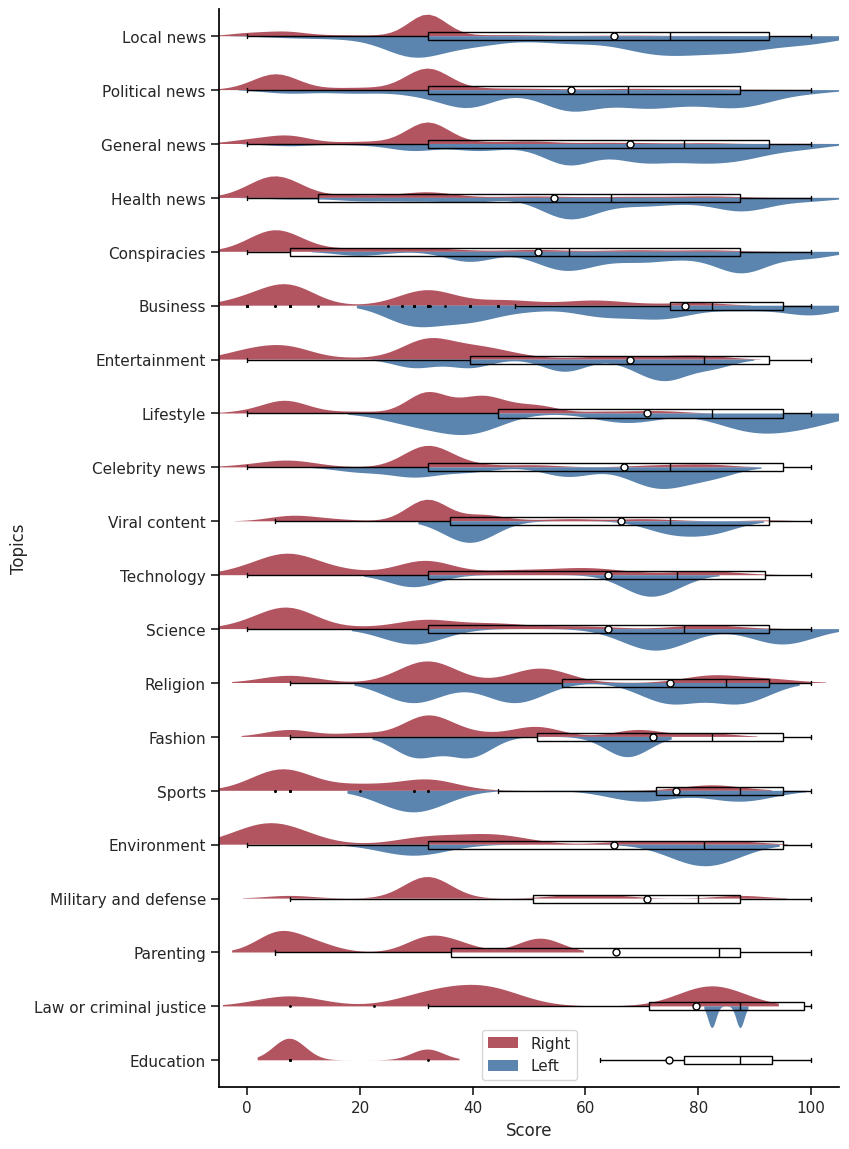

In [234]:
#violinplot
plt.figure(figsize=(8, 14))
# sns.stripplot(data=recent_topics_df, 
#             y="Topics", 
#             x="Score",
#             hue="Orientation",
#             order=recent_topic_desc_50["Topics"],
#             palette=orientation_palette_after,
#             size=3,
#             alpha=1
#             )

sns.violinplot(data=recent_topics_df,
                x="Score",
                y="Topics",
                hue="Orientation",
                order=recent_topic_desc["Topics"],
                split=True,
                density_norm="width",
                width=0.8,
                bw_method=0.2,
                alpha=0.8,
                linewidth=1,
                linecolor="none",
                palette=orientation_palette_after,
                inner=None)

sns.boxplot(data=recent_topics_df,
            x="Score",
            y="Topics",
            order=recent_topic_desc["Topics"],
            fliersize=1,
            width=0.15,
            #whis=1,
            boxprops=dict(facecolor="none",
                          linewidth=1,
                          edgecolor="black"),
        
            meanprops=dict(marker="o", 
                           markerfacecolor="white", 
                           markeredgecolor="black",
                           markersize=5),
            showmeans=True,
            linewidth=1,
            color="black")
custom_plots()


plt.xlim(-5,105)

## Updates

In [235]:
df_15_topics = df_15[["Domain", "file_date", 
                      "Last Updated",
                      "Score",
                      "Country", "Language", 
                      "Topics"]]

df_15_topics = df_15_topics\
    .groupby(["Domain", "Country", "Language"],
                    group_keys=False)\
    .apply(lambda x: x\
            .sort_values("file_date",
                            ascending=True))\
    .reset_index(drop=True)

/tmp/ipykernel_4191584/1151703117.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


In [236]:
df_15_topics["Topics_Changed"] = \
    df_15_topics\
        .groupby(["Domain", "Country", "Language"])["Topics"]\
            .apply(lambda x: x != x.shift())\
            .reset_index(level=[0, 1, 2], drop=True)

In [237]:
df_15_topics["Updated_diff"] = \
    df_15_topics\
        .groupby(["Domain", "Country", "Language"])["Last Updated"]\
            .diff()

In [238]:
df_15_topics['Actual_Change'] = df_15_topics \
    .apply(lambda row: row["Topics_Changed"] and 
            not pd.isna(row["Updated_diff"]) and 
            not pd.isna(row["Topics"]), axis=1)

In [239]:
#how many domains have changed topics?
topic_change_count = df_15_topics\
    .groupby(["Domain", "Country", "Language"])["Actual_Change"]\
    .sum()\
    .reset_index()

#topic_change_count.sort_values(by="Actual_Change",
#                                ascending=False)\
#    .head(13)

# FINAL FIGURES

## Figure 1

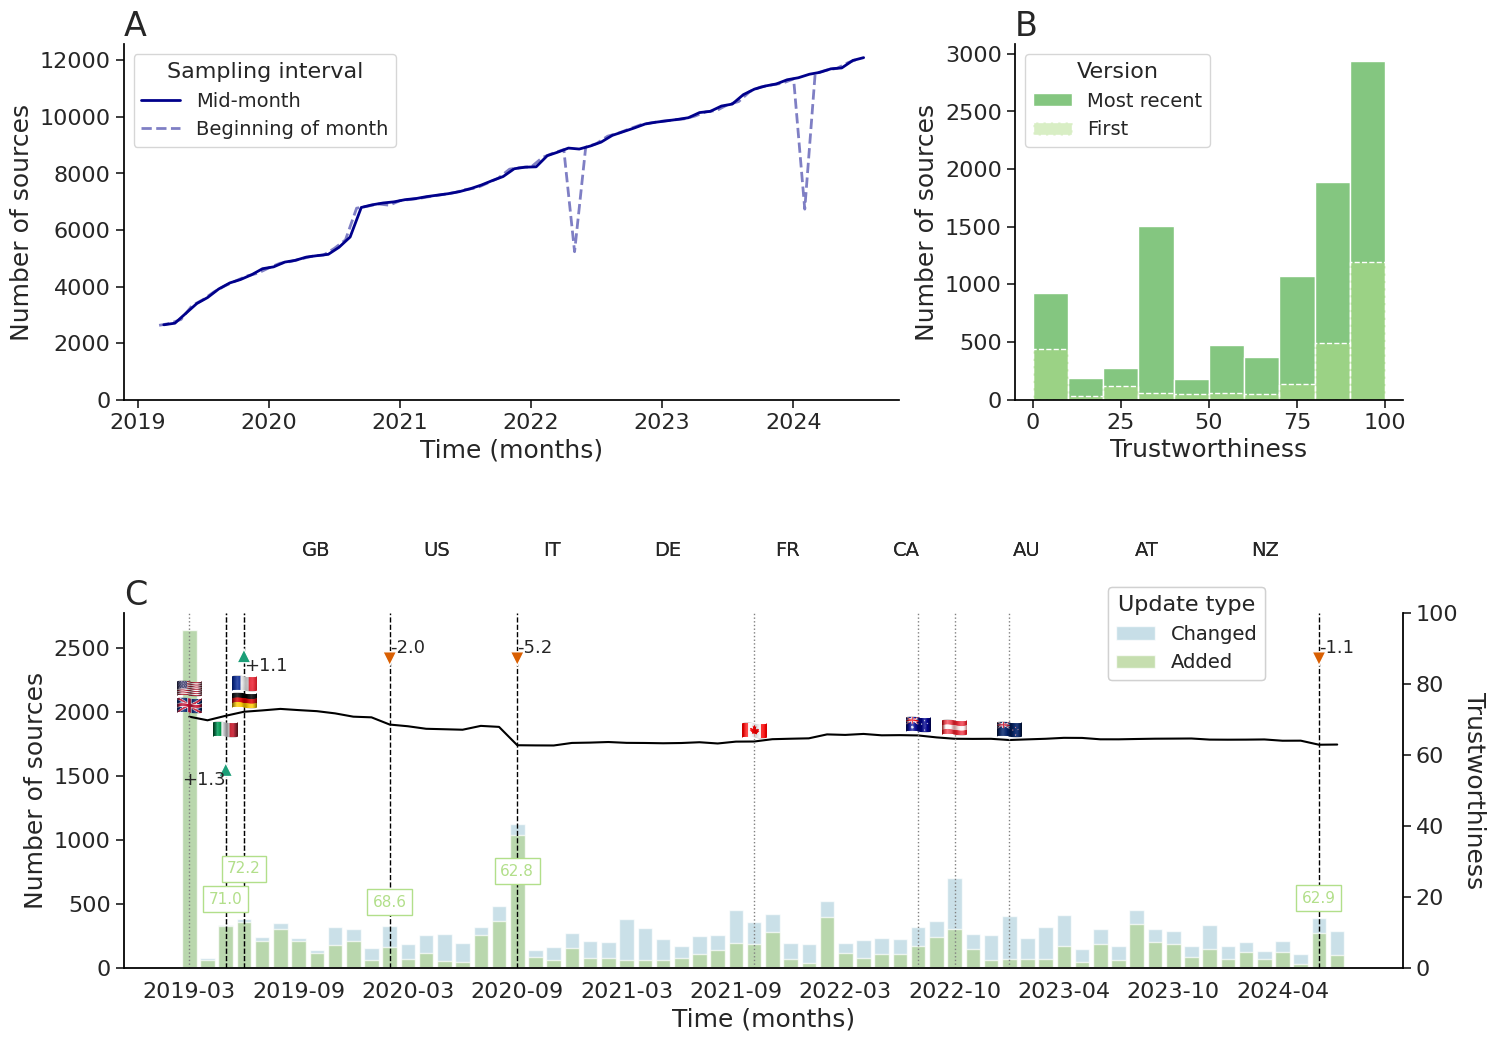

In [240]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3,
              width_ratios=[2, 1, 0],
              hspace=0.6,
              wspace=0.3
              )  

''' SUBPLOT A '''
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             color="darkblue", 
             alpha=1, 
             linewidth=2, 
             label="Mid-month", 
             ax=ax1)

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             color="darkblue", 
             alpha=0.5, 
             linewidth=2, 
             linestyle="dashed", 
             label="Beginning of month", 
             ax=ax1)

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)
ax1.set_ylim(0)
ax1.set_title("A", fontsize=24, loc="left")
ax1.set_xlabel("Time (months)", fontsize=18)
ax1.set_ylabel("Number of sources", fontsize=18)
ax1.legend(title="Sampling interval", 
           fontsize=14,
             title_fontsize=16)
custom_plots(ax=ax1)

''' SUBPLOT B '''
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=df_recent, x="Score", 
             bins=10,
             alpha=0.6, 
             edgecolor="white", 
             color="#33a02c",
             label="Most recent", 
             ax=ax2)

sns.histplot(data=df_first, x="Score", 
             bins=10, 
             edgecolor="white", 
             color= "#b2df8a",
             alpha=0.5, 
             linestyle="dashed", 
             label="First", 
             ax=ax2)

ax2.set_xlabel("Trustworthiness", fontsize=18)
ax2.set_ylabel("Number of sources", fontsize=18)
ax2.legend(fontsize=14,
           title="Version",
           title_fontsize=16)
ax2.set_title("B", fontsize=24, loc="left")
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)
custom_plots(ax=ax2)

''' SUBPLOT C '''
ax3 = fig.add_subplot(gs[1, :2])  
ax3.set_title("C", fontsize=24, loc="left")

#barplot
updates_changed["file_date_month"] = \
    updates_changed["file_date"]\
        .dt.strftime('%Y-%m')\
            .astype(str)

sns.barplot(data=updates_changed, 
            x="file_date_month", 
            y="Count_All", 
            color="lightblue",
            label="Changed", 
            alpha=0.7, 
            ax=ax3)

sns.barplot(data=updates_changed, 
            x="file_date_month", 
            y="Count_Added", 
            color="#b2df8a", 
            alpha=0.7, 
            label="Added", 
            ax=ax3)

#barplot legend
handles, labels = ax3.get_legend_handles_labels()
added_changed_legend = plt.legend(handles,
                                  labels,
                                  loc="upper right", 
                                  bbox_to_anchor=(0.9, 1.1), 
                                  title="Update type", 
                                  title_fontsize=16,
                                  fontsize=14)

ax3.add_artist(added_changed_legend)

#settings for the first y-axis
ax3.spines["right"].set_visible(True)
ax3.yaxis.set_ticks_position("right")
ax3.grid(False)
ax3.set_ylabel("Number of sources", fontsize=18)
ax3.set_xlabel("Time (months)", fontsize=18)
ax3.tick_params("y", labelsize=16)
ax3.tick_params(axis="x", labelsize=16)
ax3.set_xticks(ax3.get_xticks()[::6])


ax4 = ax3.twinx()
sns.lineplot(data=country_count, 
             x="file_date_month", 
             y="Score", 
             color="black",
             ax=ax4)

country_change["file_date_month"] = \
    country_change["file_date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

top_changes["Date_month"] = \
    top_changes["Date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

for i, date in enumerate(country_change["file_date_month"]):
    ax4.axvline(date, color="grey", linestyle=":", linewidth=1)

top_changes = top_changes\
    .sort_values(by="Date_month")\
    .reset_index(drop=True)

for i, date in enumerate(top_changes["Date_month"]):
    ax4.axvline(date, color="black", linestyle="--", linewidth=1)
    score_diff = round(top_changes["Score_diff"].iloc[i], 1)
    text = f"+{score_diff}" if score_diff > 0 else str(score_diff)

    if i == 0 or i == 1:
        arrow_color = "#1b9e77"  #green
        arrowprops = dict(facecolor=arrow_color, 
                          shrink=0.06, 
                          headwidth=10, 
                          headlength=10, 
                          width=5)
        xy = (date, 58) if i == 0 else (date, 90)
        xytext = (date, 53) if i == 0 else (date, 85)
        ha = "right" if i == 0 else "left"
    else:
        arrow_color = "#d95f02"  # Orange
        arrowprops = dict(facecolor=arrow_color, 
                          shrink=0.06, 
                          headwidth=10, 
                          headlength=10, 
                          width=5)
        xy = (date, 85)
        xytext = (date, 90)
        ha = "left"
    
    ax4.annotate(text, xy=xy, xytext=xytext,
                 arrowprops=arrowprops, fontsize=13, 
                 ha=ha, va="center")
        
for i, date in enumerate(top_changes["Date_month"]):
    if i == 1:
        ax4.text(date, 28, 
                round(top_changes["Score"].iloc[i],1), 
                fontsize=11,
                bbox=dict(facecolor="white", 
                          edgecolor="#b2df8a"), 
                color="#b2df8a",
                va="center", 
                ha="center")
    else:
        ax4.text(date, (top_changes["Added"].iloc[i]/100)+17, 
                round(top_changes["Score"].iloc[i], 1), 
                fontsize=11,
                bbox=dict(facecolor="white", 
                          edgecolor="#b2df8a"), 
                color="#b2df8a",
                va="center", 
                ha="center")


y_positions = {}
country_change_dict_str = \
    {pd.to_datetime(key)\
     .strftime("%Y-%m"): value for key, value in country_change_dict.items()}

for date, countries in country_change_dict_str.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue
        flag = plt.imread(flag_path)
        country_x = date
        country_score = country_count.loc[country_count["file_date_month"] == date, "Score"].iloc[0]
        if country == "IT":
            y_position = country_score + idx - 4
        else:
            if date in y_positions:
                y_position = country_score + idx + 7
            else:
                y_position = country_score + idx + 3
        imagebox = OffsetImage(flag, zoom=0.4)
        ab = AnnotationBbox(imagebox, (country_x, y_position), frameon=False)
        ax4.add_artist(ab)
        y_positions.setdefault(date, []).append(y_position)

legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax3.plot([], [], linestyle="none", label=c)[0])

legends_flags = ax4.legend(handles=legend_elements, loc="lower center", 
                           bbox_to_anchor=(0.5, 1.1), 
                           frameon=False,
                           fontsize=14, ncol=9, title_fontsize=16)
ax4.add_artist(legends_flags)

ax4.set_ylabel("Trustworthiness", 
               rotation=270,
               #whitespace
                labelpad=20,
               fontsize=18)
ax4.tick_params(axis="y", labelsize=16)
ax4.set_ylim(0, 100)
ax4.grid(False)

#common settings
ax3.spines["top"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_color("black")
ax4.spines["left"].set_color("black")
ax4.spines["bottom"].set_color("black")

plt.savefig(join(figures_path, 
                 "trustworthiness_panel.png"), 
                 bbox_inches='tight', 
                 pad_inches=0.1,
                 dpi=300)
plt.savefig(join(figures_path, 
                 "trustworthiness_panel.pdf"), 
                 bbox_inches='tight', pad_inches=0.1,
                 dpi=300)

plt.show()

### Figure 2

/tmp/ipykernel_4191584/2481105272.py:117: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df_15_ALL,
/tmp/ipykernel_4191584/2481105272.py:117: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.pointplot(data=df_15_ALL,


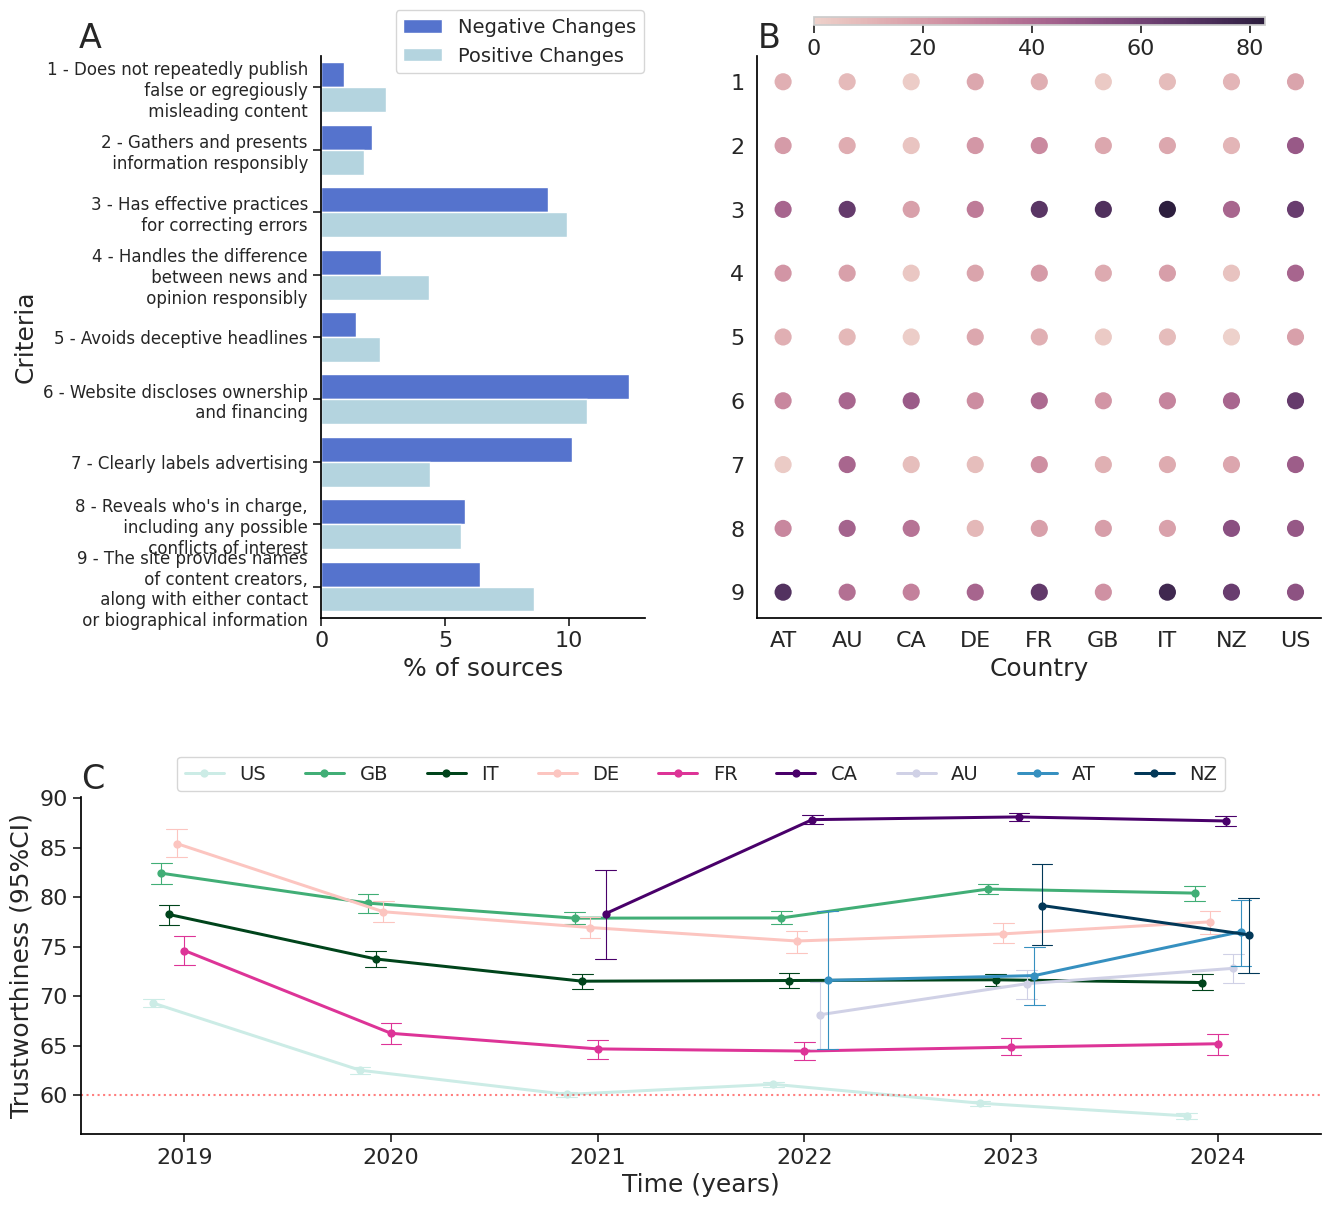

In [241]:
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(2, 2,
              width_ratios=[1, 1],
              height_ratios=[1.25, 0.75],
              hspace=0.4)  

''' SUBPLOT A '''
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_title("A", fontsize=24, 
              loc="left",
              #manually set location
                x=-0.75, y=1)

left_margin = 0.15
pos = ax0.get_position()
ax0.set_position([pos.x0 + left_margin, pos.y0, pos.width - left_margin, pos.height])

#order criteria by criteria
criteria_changes = criteria_changes\
    .sort_values(by="Criteria")

criteria_mapping = {
    "1":"1 - Does not repeatedly publish\n false or egregiously\n misleading content",
    "2":"2 - Gathers and presents\n information responsibly",
    "3":"3 - Has effective practices\n for correcting errors",
    "4":"4 - Handles the difference\n between news and\n opinion responsibly",
    "5":"5 - Avoids deceptive headlines",
    "6":"6 - Website discloses ownership\n and financing",
    "7":"7 - Clearly labels advertising",
    "8":"8 - Reveals who's in charge,\n including any possible\n conflicts of interest",
    "9":"9 - The site provides names\n of content creators,\n along with either contact\n or biographical information"
}

criteria_change_leg = criteria_changes.replace({"Criteria": criteria_mapping})

sns.barplot(data=criteria_change_leg, 
            x="Value", 
            y="Criteria", 
            hue="Change",
            palette={"Negative Changes": year_colors[3], 
                     "Positive Changes": year_colors[2]},
            ax=ax0
            )

ax0.set_xlabel("% of sources", fontsize=18)
ax0.set_ylabel("Criteria", fontsize=18)
ax0.tick_params(axis="y", labelsize=12)
ax0.legend(fontsize=14,
           loc="upper left",
           bbox_to_anchor=(0.2, 1.1))
custom_plots(ax=ax0)


''' SUBPLOT B '''
ax1 = fig.add_subplot(gs[0, 1])

#order criteria by criteria
criteria_country_miss = criteria_country_miss\
    .sort_values(by="Criteria_num")

#criteria_n_order = criteria_changes["Criteria"].unique()

#order criteria_country_sum["Criteria_num"] by criteria_n_order
#criteria_country_sum["Criteria_num"] = \
#    pd.Categorical(criteria_country_sum["Criteria_num"], 
#                   categories=criteria_n_order, 
#                   ordered=True)

#criteria_country_sum = criteria_country_sum\
#    .sort_values(by=["Country", "Criteria_num"])\
#    .reset_index(drop=True)

sns.scatterplot(data=criteria_country_miss,
                x="Country",
                y="Criteria_num",
                hue="Percentage",
                palette = sns.cubehelix_palette(as_cmap=True),
                s=180,
                ax=ax1)

ax1.set_xlabel("Country", fontsize=18)
ax1.set_ylabel("")
ax1.set_title("B", fontsize=24, loc="left")
ax1.tick_params(axis="y", labelsize=16)
#remove legend
ax1.get_legend().remove()

#add colobar
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), 
                            norm=plt.Normalize(vmin=criteria_country_miss["Percentage"].min(), 
                                               vmax=criteria_country_miss["Percentage"].max()))


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_ax = inset_axes(ax1, 
                     width="100%",  
                     height="30%",  
                     loc='upper center', 
                     bbox_to_anchor=(0.1, 1.02, 0.8, 0.05),  
                     bbox_transform=ax1.transAxes, 
                     borderpad=0)
cbar = fig.colorbar(sm, 
                    cax=cbar_ax, 
                    orientation='horizontal')

#cbar.set_label("Percentage",
#               fontsize=14)

custom_plots(ax=ax1)


''' SUBPLOT C (WIDE) '''
ax3 = fig.add_subplot(gs[1, :2])


sns.pointplot(data=df_15_ALL,
              x="file_year", 
              y="Score", 
              hue="Country",
              hue_order=df_15_ALL["Country"].unique().sort(),
              scale=0.8,
              capsize=0.1,
              errwidth=0.8,
              estimator="mean",
              dodge=0.3,
              errorbar="ci",
              palette=country_palette,
              ax=ax3  
              )

ax3.axhline(y=60, 
                 color="red", 
                 linestyle="dotted", 
                 alpha=0.5)

ax3.set_xlabel("Time (years)", 
               fontsize=18)
ax3.set_ylabel("Trustworthiness (95%CI)",
               fontsize=18)
ax3.set_title("C", fontsize=24, loc="left")
ax3.tick_params(axis="y", labelsize=16)
ax3.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.15), 
    ncol=11, 
    fontsize=14)
custom_plots(ax=ax3)

for ax in fig.get_axes():
    ax.tick_params(axis="x", labelsize=16)

plt.savefig(join(figures_path, 
                 "criteria_panel.png"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.savefig(join(figures_path, 
                 "criteria_panel.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.show()

### Figure 3

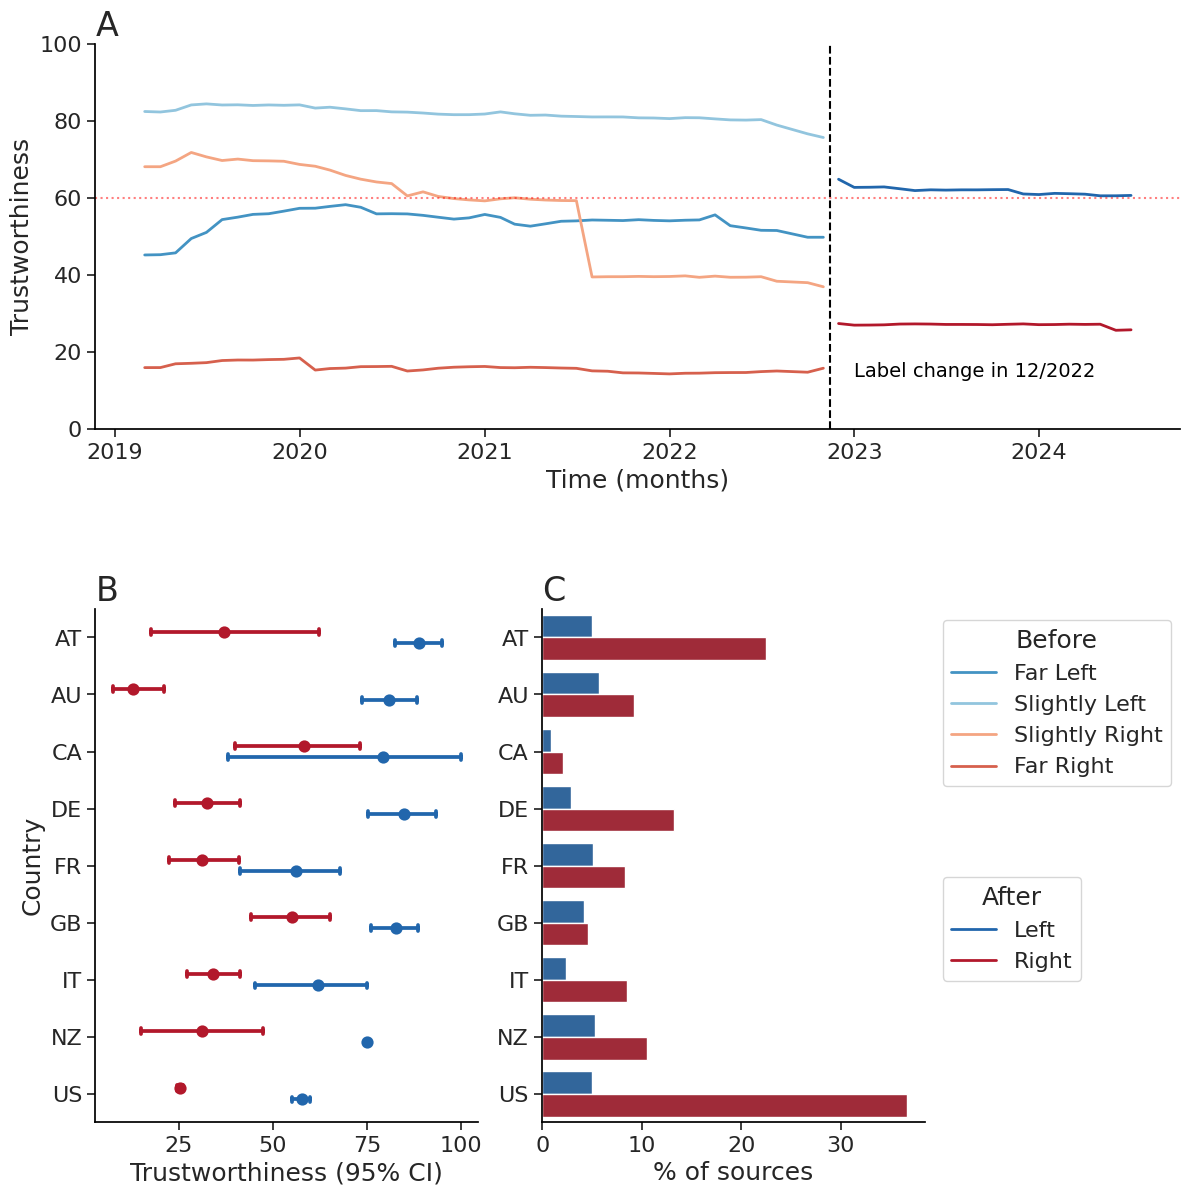

In [242]:
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 3,
              width_ratios=[1, 1, 0.5],
              height_ratios=[0.75, 1],
              hspace=0.4)  

""" SUBPLOT A """
ax0 = fig.add_subplot(gs[0, :])

score_x_orientation_time = score_x_orientation_time\
    .reset_index()

score_x_orientation_time["file_month"] = \
    score_x_orientation_time["file_month"].dt.to_timestamp()
sns.lineplot(data=score_x_orientation_time,
             x="file_month",
             y="mean",
             hue="Orientation",
             linewidth=2,
             palette=orientation_palette, 
             ax=ax0)

ax0.set_xlabel("Time (months)", fontsize=18)
ax0.set_ylabel("Trustworthiness", fontsize=18)
ax0.set_title("A", fontsize=24, loc="left")
custom_plots(ax=ax0)
ax0.tick_params(axis="both", 
                labelsize=16, 
                rotation=0)
ax0.set_ylim(0,100)

ax0.text(x=pd.Timestamp("2023-01-01"),
         y=15,
         s="Label change in 12/2022", 
         fontsize=14, 
         color="black",
         alpha=1, 
         verticalalignment="center", 
         bbox=dict(facecolor="none", 
                   edgecolor="none",
                   #boxstyle="round,pad=0.3", 
                   alpha=0.5))

#add a vertical line 
ax0.axvline(x=pd.Timestamp("2022-11-15"),
            color="black",
            linestyle="dashed",
            alpha=1)

ax0.axhline(y=60,
            color="red",
            linestyle="dotted",
            alpha=0.5)

ax0.legend().remove()

""" SUBPLOT B """
ax1 = fig.add_subplot(gs[1,0])
ax1.set_title("B", fontsize=24, loc="left")

country_diff = df_recent[df_recent["Country"] != "ALL"]

sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    capsize=0.1,
    order=sorted(country_diff["Country"].unique()),
    errorbar=("ci",95),
    palette=orientation_palette_after,
    linestyle="none",
    dodge=0.2,
    ax=ax1)

ax1.set_xlabel("Trustworthiness (95% CI)",
                fontsize=18)
ax1.set_ylabel("Country", fontsize=18)
ax1.legend().remove()
ax1.tick_params(axis="both", 
                labelsize=16, 
                rotation=0)
custom_plots(ax=ax1)

#add a count plot with dodged bars for each country and the size
ax2 = fig.add_subplot(gs[1,1])
#remove "ALL"
score_x_orientation_w_ALL = score_x_orientation[score_x_orientation["Country"] != "ALL"]
sns.barplot(data=score_x_orientation_w_ALL, 
            x="Prop", 
            y="Country", 
            hue="Orientation", 
            order=sorted(score_x_orientation_w_ALL["Country"].unique()),
            palette=orientation_palette_after,
            dodge=True,
            ax=ax2)

ax2.set_ylabel("")
ax2.set_xlabel("% of sources", fontsize=18)
ax2.tick_params(axis="both", labelsize=16)
ax2.legend().remove()
ax2.set_title("C", fontsize=24, loc="left")
custom_plots(ax=ax2)

""" LEGENDS """
ax3a = fig.add_subplot(gs[1, 2])
ax3a.plot([], [])

handles, labels = ax0.get_legend_handles_labels()
first_legend_indices = [0,1,2,3] 
second_legend_indices = [4,5]  

first_legend_handles = [handles[i] for i in first_legend_indices]
first_legend_labels = [labels[i] for i in first_legend_indices]

ax3a.legend(first_legend_handles, first_legend_labels,
            title="Before",
            title_fontsize=18,
            loc="upper left",
            bbox_to_anchor=(-0.3, 1),
            fontsize=16)
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_xticklabels([])
ax3a.set_yticklabels([])
ax3a.patch.set_alpha(0)
ax3a.set_facecolor("none")
ax3a.axis("off")

ax3b = fig.add_subplot(gs[1, 2])  
ax3b.plot([], [])  
second_legend_handles = [handles[i] for i in second_legend_indices]
second_legend_labels = [labels[i] for i in second_legend_indices]
ax3b.legend(second_legend_handles, second_legend_labels,
            title="After",
            title_fontsize=18,
            loc="upper left",
            bbox_to_anchor=(-0.3, 0.5), 
            fontsize=16)
ax3b.set_xticks([])
ax3b.set_yticks([])
ax3b.set_xticklabels([])
ax3b.set_yticklabels([])
ax3b.patch.set_alpha(0)
ax3b.set_facecolor("none")
ax3b.axis("off")

plt.savefig(join(figures_path,
                    "orientation_panel.png"),
            bbox_inches="tight", 
            pad_inches=0.1,
            dpi=300)

plt.savefig(join(figures_path,
                    "orientation_panel.pdf"),
            bbox_inches="tight", 
            pad_inches=0.1,
            dpi=300)
plt.show()

### Figure 4

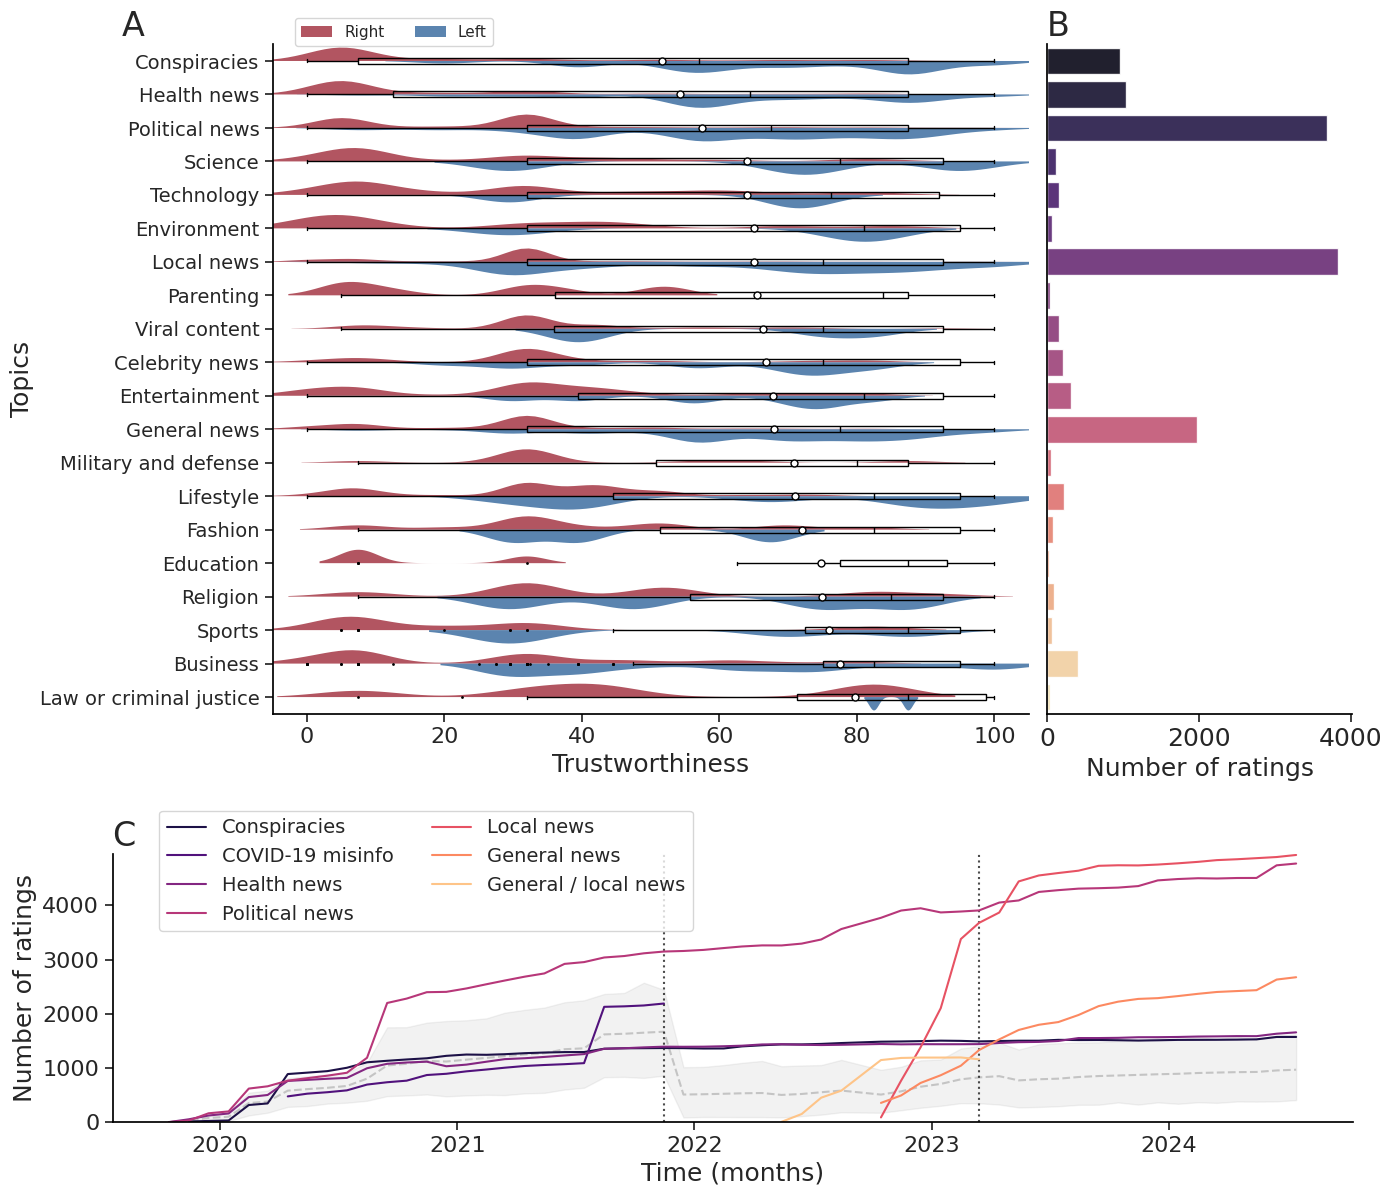

In [243]:
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(2, 2,
              width_ratios=[1.5, 0.5],
              height_ratios=[5, 2],
              hspace=0.3,
              wspace=0.03
              )  

''' SUBPLOT A '''
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("A", fontsize=24, loc="left",
                x=-0.2, y=1)
              
left_margin = 0.1
pos = ax1.get_position()
ax1.set_position([pos.x0 + left_margin, 
                  pos.y0, 
                  pos.width - left_margin, 
                  pos.height])

recent_topic_desc.sort_values(by="Score",
                                ascending=True,
                                inplace=True)

sns.violinplot(data=recent_topics_df,
                x="Score",
                y="Topics",
                hue="Orientation",
                order=recent_topic_desc["Topics"],
                split=True,
                density_norm="width",
                width=0.8,
                bw_method=0.2,
                alpha=0.8,
                linewidth=1,
                linecolor="none",
                palette=orientation_palette_after,
                inner=None,
                ax=ax1)

sns.boxplot(data=recent_topics_df,
            x="Score",
            y="Topics",
            order=recent_topic_desc["Topics"],
            fliersize=1,
            width=0.18,
            #whis=1,
            boxprops=dict(facecolor="none",
                          linewidth=1,
                          edgecolor="black"),
        
            meanprops=dict(marker="o", 
                           markerfacecolor="white", 
                           markeredgecolor="black",
                           markersize=5),
            showmeans=True,
            linewidth=1,
            color="black",
            ax=ax1)

ax1.set_xlabel("Trustworthiness",
            fontsize=18)
ax1.set_xlim(-5,105)
ax1.set_ylabel("Topics", fontsize=18)
ax1.tick_params(axis="y", labelsize=14)
ax1.tick_params(axis="x", labelsize=16)
ax1.legend(loc="upper left",
           bbox_to_anchor=(0.02,1.05),
           ncol=2)

custom_plots(ax=ax1)


''' SUBPLOT B '''
ax2 = fig.add_subplot(gs[0, 1])

ax2.set_title("B", fontsize=24, loc="left")

sns.barplot(data=recent_topic_desc,
            x="Count",
            y="Topics",
            hue="Topics",
            order=recent_topic_desc["Topics"],
            palette="magma",
            alpha=0.9,
            ax=ax2)

ax2.yaxis.set_visible(False)
ax2.set_xlabel("Number of ratings", 
           fontsize=18)
ax2.set_ylabel("Topics", 
           fontsize=18)
ax2.tick_params(axis='x', 
                labelsize=18)

custom_plots(ax=ax2)

''' SUBPLOT C '''

ax3 = fig.add_subplot(gs[1, :])
ax3.set_title("C", fontsize=24, loc="left")

# bad_topics_palette = {
#     "Conspiracies": "#762a83",
#     "COVID-19 misinfo": "#9970ab",
#     "Health news": "#c51b7d",
#     "Political news": "#e9a3c9",
#     "Local news": "#1b7837",
#     "General news":"#4d9221",
#     "General / local news": "#7fbf7b"}

bad_topics_bad_sources_time["Topic"] = bad_topics_bad_sources_time["Topic"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news"})

bad_topics_list = bad_topics_bad_sources_time["Topic"].to_list()


sns.lineplot(x="file_date", 
             y="Count", 
             estimator="mean",
             errorbar=("ci", 95),
             color="grey",
             linestyle="--",
             alpha=0.4,
             err_kws={"alpha":0.1},
             data=topic_freq,
             ax=ax3)

#add vertical line
ax3.axvline(x=pd.Timestamp("2021-11-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7
            )

ax3.axvline(x=pd.Timestamp("2023-03-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7)


sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic",
             palette="magma",
             hue_order=bad_topics_palette.keys(),
             data=topic_freq[topic_freq["Topic"].isin(bad_topics_list)],
             ax=ax3)


ax3.set_xlabel("Time (months)", 
               fontsize=18)
ax3.set_ylabel("Number of ratings", 
               fontsize=18)
ax3.tick_params(axis="both", 
                labelsize=16)

ax3.set_ylim(0, max(topic_freq["Count"]) + 10)

ax3.legend(fontsize=14, 
           ncol=2,
           loc="upper left",
           bbox_to_anchor=(0.03, 1.2))

custom_plots(ax=ax3)


plt.savefig(join(figures_path,
                    "topics_panel.png"),
                bbox_inches='tight', 
                pad_inches=0.1,
                dpi=300)

plt.savefig(join(figures_path,
                    "topics_panel.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()